In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch
from PIL import Image
import cv2
import mediapipe as mp
import numpy as np

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

model = None


def initialize_model():
    global model
    model =  mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2)


def inference(images, conf_threshold=0.5):
    """
    Perform inference on a batch of images using MediaPipe Pose to detect keypoints.

    Args:
        images (list): List of PIL.Image images.

    Returns:
        list: A list of keypoints for each image. Each element is a list of tuples (x, y, z, visibility).
              The order of keypoints matches the order of the input image list.
    """
    global model
    keypoints_list = []  # To store the keypoints for each image in the same order.

    for idx, image in enumerate(images):
        # Convert PIL.Image to numpy array and then to RGB for MediaPipe processing.
        image_np = np.array(image)
        image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

        # Process the image with MediaPipe Pose.
        results = model.process(image_rgb)

#         if results.pose_landmarks:
#             # Extract keypoints as (x, y, z, visibility).
#             keypoints = [
#                 (landmark.x, landmark.y, landmark.z, landmark.visibility)
#                 for landmark in results.pose_landmarks.landmark
#             ]
#             print('keypoints:', np.shape(keypoints))
#         else:
#             keypoints = []  # Empty list if no landmarks are detected.

#         # Append keypoints to maintain order with images
#         keypoints_list.append(keypoints)
        
        if results.pose_world_landmarks:
            keypoints = []
            for landmark in results.pose_world_landmarks.landmark:
                x = landmark.x if landmark.visibility > conf_threshold else np.nan
                y = landmark.y if landmark.visibility > conf_threshold else np.nan
                z = landmark.z if landmark.visibility > conf_threshold else np.nan

                keypoints.append([x, y,z])

            keypoints_list.append(keypoints)
        else:
            # Append an empty list if no keypoints are detected
            keypoints_list.append(np.full((33, 3), np.nan))

    return keypoints_list




def readImages(interval, localStoragePath, userId):
  pass

def postureDetect(interval=60):
  """
    Posture detection pipeline. This function reads images from the local storage, performs inference on them, and sends the results to the server.

    Args:
    - interval (int): Interval in seconds to read images from the local storage.

    """
  results = inference(images)
  return results




In [6]:
data_path = "../../AI System Data/Lean Forward/frames"
image_files = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
batch_size = 20
counter = 0
initialize_model()
keypoints_list = []  # To store the keypoints for each image in the same order.
conf_threshold=0.5
images = [Image.open(os.path.join(data_path, image_file)) for image_file in image_files[0:batch_size]]
for idx, image in enumerate(images):
    # Convert PIL.Image to numpy array and then to RGB for MediaPipe processing.
    image_np = np.array(image)
    image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

    # Process the image with MediaPipe Pose.
    results = model.process(image_rgb)

#         if results.pose_landmarks:
#             # Extract keypoints as (x, y, z, visibility).
#             keypoints = [
#                 (landmark.x, landmark.y, landmark.z, landmark.visibility)
#                 for landmark in results.pose_landmarks.landmark
#             ]
#             print('keypoints:', np.shape(keypoints))
#         else:
#             keypoints = []  # Empty list if no landmarks are detected.

#         # Append keypoints to maintain order with images
#         keypoints_list.append(keypoints)

    if results.pose_world_landmarks:
        keypoints = []
        for landmark in results.pose_world_landmarks.landmark:
            x = landmark.x if landmark.visibility > conf_threshold else np.nan
            y = landmark.y if landmark.visibility > conf_threshold else np.nan
            z = landmark.z if landmark.visibility > conf_threshold else np.nan

            keypoints.append([x, y,z])

        keypoints_list.append(keypoints)
    else:
        # Append an empty list if no keypoints are detected
        keypoints_list.append(np.full((33, 3), np.nan))

In [24]:
# Testing the function
data_path = "../../AI System Data/Lean Forward/frames"
image_files = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
batch_size = 20
counter = 0
results_forward = []

# Initialize the model
initialize_model()

for i in range(len(image_files) // batch_size):
    # Load a batch of images
    images = [Image.open(os.path.join(data_path, image_file)) for image_file in image_files[counter:counter + batch_size]]
    
    # Perform posture detection on the batch
    batch_results = postureDetect(images)
    
    #Append batch results to the main results list
    results_forward.extend(batch_results)

    # Print keypoints results for the current batch
    for idx, keypoints in enumerate(batch_results):
        print(f"Image {counter + idx}: Keypoints - {keypoints}")
    
    counter += batch_size

#Process remaining images
images = [Image.open(os.path.join(data_path, image_file)) for image_file in image_files[counter:]]
if images:
    batch_results = postureDetect(images)
    results_forward.extend(batch_results)

    # Print keypoints for remaining images
    for idx, keypoints in enumerate(batch_results):
        print(f"Image {counter + idx}: Keypoints - {keypoints}")

# Print final keypoints results
for idx, keypoints in enumerate(results_forward):
    print(f"Image {idx}: Keypoints - {keypoints}")

RuntimeError: Service "kGpuService", required by node posedetectioncpu__ImageToTensorCalculator, was not provided and cannot be created: ; RET_CHECK failure (mediapipe/gpu/gl_context_nsgl.cc:122) (err)==(kCVReturnSuccess)Error at CVOpenGLTextureCacheCreate

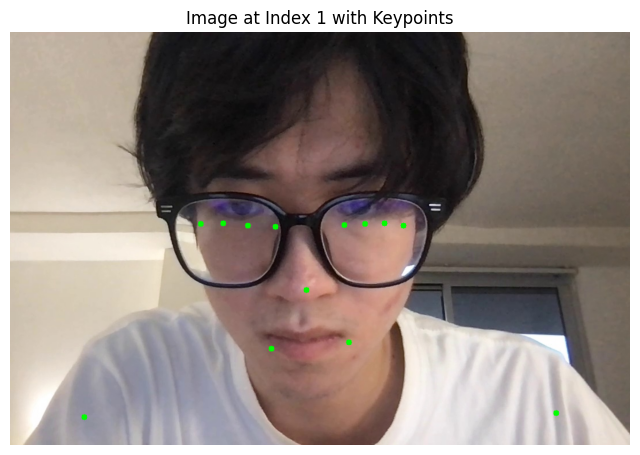

In [69]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def draw_keypoints_on_image(images, keypoints_list, index):
    """
    Draws predicted keypoints on the image at the specified index.

    Args:
    - images (list): List of PIL Image objects.
    - keypoints_list (list): List of keypoints for each image. Each element is a list of [x, y, z] keypoints.
    - index (int): Index of the image to draw keypoints on.

    Returns:
    None
    """
    if index < 0 or index >= len(images):
        print("Index out of range. Please provide a valid index.")
        return

    image = np.array(images[index])  # Convert PIL Image to numpy array
    keypoints = keypoints_list[index]

    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    for keypoint in keypoints:
        x, y, z = keypoint
        if x != 0 and y != 0:  # Skip if keypoint is [0, 0, 0]
            cv2.circle(image_bgr, (int(x), int(y)), radius=5, color=(0, 255, 0), thickness=-1)

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"Image at Index {index} with Keypoints")
    plt.show()

draw_keypoints_on_image(images, results_forward[-11:], 1)  # Replace '5' with the desired index


In [74]:
for i in range(3):
    print(f"Keypoint {i} type: {type(results_forward[i])}")
    print(f"Keypoint {i} shape/len: {np.shape(results_forward[i]) if isinstance(results_forward[i], np.ndarray) else len(results_forward[i])}")
    print(f"Keypoint {i} data: {results_forward[i]}\n")

Keypoint 0 type: <class 'list'>
Keypoint 0 shape/len: 0
Keypoint 0 data: []

Keypoint 1 type: <class 'list'>
Keypoint 1 shape/len: 33
Keypoint 1 data: [[458.85279178619385, 493.5075330734253, -1.5124504566192627], [518.9544010162354, 361.1637783050537, -1.4586881399154663], [560.1117396354675, 350.3157448768616, -1.4599939584732056], [591.4102864265442, 342.0261311531067, -1.4598335027694702], [398.53981375694275, 375.5417490005493, -1.435579538345337], [356.96353554725647, 373.4156370162964, -1.4379369020462036], [321.5355885028839, 369.6288728713989, -1.439437747001648], [641.6268396377563, 325.053927898407, -0.8870963454246521], [296.31115078926086, 351.0434818267822, -0.7806410193443298], [540.0435161590576, 572.2134590148926, -1.2570151090621948], [410.7398843765259, 579.9273204803467, -1.2390475273132324], [921.7227172851562, 666.8015813827515, -0.5076673626899719], [129.48950082063675, 677.3738193511963, -0.3339107036590576], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]

In [6]:
import json

def save_keypoints(results, save_path):
    """
    Save keypoints results handling empty lists and 33x3 keypoints
    """
    os.makedirs(save_path, exist_ok=True)
    json_serializable_results = []

    for keypoint in results:
        if len(keypoint) == 0:
            # Empty list of keypoints
            json_serializable_results.append([])  
        else:
            # Convert NumPy array (if any) to Python list
            # or assume keypoint is already a Python list of floats
            # If it's guaranteed to be a NumPy array, you can do:
            json_serializable_results.append(np.array(keypoint).tolist())

            
    # Save raw format as JSON
    with open(os.path.join(save_path, 'keypoints.json'), 'w') as f:
         json.dump(json_serializable_results, f, indent=4)
    
    # Convert to numpy with consistent shape (N, 33, 3)
    uniform_results = []
    for keypoint in results:
        if len(keypoint) == 0:  # Empty list
            uniform_results.append(np.zeros((33, 3)))
        else:
            uniform_results.append(np.array(keypoint))
    
    keypoints_array = np.array(uniform_results)
    np.save(os.path.join(save_path, 'keypoints.npy'), keypoints_array)
    
    print(f"Saved {len(results)} keypoints with shape {keypoints_array.shape}")

keypoints_path = "../keypoints/"
# Usage in main code:
save_path = os.path.join(keypoints_path, "forward_keypoints")
save_keypoints(results_forward, save_path)

In [3]:
# Testing the function
data_path = "../../AI System Data/Backwards/frames"
image_files = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
batch_size = 20
counter = 0
results_backwards = []
model = None
# Initialize the model
initialize_model()

for i in range(len(image_files) // batch_size):
    # Load a batch of images
    images = [Image.open(os.path.join(data_path, image_file)) for image_file in image_files[counter:counter + batch_size]]
    
    # Perform posture detection on the batch
    batch_results = postureDetect(images)
    
    # Append batch results to the main results list
    results_backwards.extend(batch_results)

    # Print keypoints results for the current batch
    for idx, keypoints in enumerate(batch_results):
        print(f"Image {counter + idx}: Keypoints - {keypoints}")
    
    counter += batch_size

# Process remaining images
images = [Image.open(os.path.join(data_path, image_file)) for image_file in image_files[counter:]]
if images:
    batch_results = postureDetect(images)
    results_backwards.extend(batch_results)

#     # Print keypoints for remaining images
    for idx, keypoints in enumerate(batch_results):
        print(f"Image {counter + idx}: Keypoints - {keypoints}")
# 
# # Print final keypoints results
# for idx, keypoints in enumerate(results_backwards):
#     print(f"Image {idx}: Keypoints - {keypoints}")

Image 0: Keypoints - [[-0.013381749391555786, -0.5040601491928101, -0.3854505717754364], [0.02059423364698887, -0.5317548513412476, -0.3758028745651245], [0.019461216405034065, -0.5313529968261719, -0.3662310838699341], [0.016572769731283188, -0.5308828949928284, -0.36632871627807617], [-0.021483607590198517, -0.5524412393569946, -0.38183364272117615], [-0.020984822884202003, -0.5493029356002808, -0.40110114216804504], [-0.020520273596048355, -0.5368998646736145, -0.38083377480506897], [0.13887137174606323, -0.534692645072937, -0.24919533729553223], [-0.10205797851085663, -0.5249752998352051, -0.23684251308441162], [0.0425565242767334, -0.4907020628452301, -0.32942402362823486], [-0.027261720970273018, -0.46913355588912964, -0.3459131121635437], [0.23073269426822662, -0.3758319318294525, -0.09106161445379257], [-0.14426079392433167, -0.4814743995666504, -0.07898427546024323], [nan, nan, nan], [nan, nan, nan], [0.32067859172821045, -0.5320727229118347, -0.09518545866012573], [-0.1868916

Image 20: Keypoints - [[0.06677331030368805, -0.374782532453537, -0.08346033096313477], [0.07498568296432495, -0.39254796504974365, -0.11013025790452957], [0.07511091232299805, -0.3903566598892212, -0.10158571600914001], [0.07683418691158295, -0.3934929370880127, -0.09916278719902039], [0.08659709990024567, -0.40602201223373413, -0.09541945904493332], [0.08473363518714905, -0.4012583792209625, -0.10670632869005203], [0.0813770443201065, -0.39075079560279846, -0.08356941491365433], [0.19763246178627014, -0.36782583594322205, -0.15059690177440643], [0.1518690586090088, -0.3672773241996765, -0.015571272931993008], [0.12444456666707993, -0.34700167179107666, -0.0838327631354332], [0.10264702141284943, -0.3250216245651245, -0.07277479767799377], [0.24031242728233337, -0.2562310993671417, -0.1334099918603897], [0.26727232336997986, -0.3718539774417877, 0.14026674628257751], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], 

Image 40: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 41: Keypoints - [[0.0009728819131851196, -0.5476326942443848, -0.37656018137931824], [0.021136796101927757, -0.579484760761261, -0.3748515546321869], [0.02304464392364025, -0.5767673850059509, -0.3601585626602173], [0.020022697746753693, -0.5778257250785828, -0.36646702885627747], [-0.006693236529827118, -0.5845939517021179, -0.38361045718193054], [-0.003205643966794014, -0.5852829217910767, -0.39692533016204834], [-0.00015495344996452332, -0.571291983127594, -0.379595935

Image 60: Keypoints - [[-0.031216179952025414, -0.5749668478965759, -0.33009767532348633], [-0.0077923499047756195, -0.6048232913017273, -0.3286263942718506], [-0.005203697830438614, -0.602462887763977, -0.314397931098938], [-0.008609730750322342, -0.6036227345466614, -0.3207690715789795], [-0.0344691276550293, -0.6115503907203674, -0.33288103342056274], [-0.03077062778174877, -0.6125282049179077, -0.3447796404361725], [-0.0274448674172163, -0.5985339879989624, -0.3283236622810364], [0.08092355728149414, -0.5890175104141235, -0.23453527688980103], [-0.07097535580396652, -0.5566173195838928, -0.21533477306365967], [0.012083213776350021, -0.5637733936309814, -0.28316885232925415], [-0.026704201474785805, -0.5347622036933899, -0.3031300902366638], [0.20026427507400513, -0.3974601924419403, -0.11649025976657867], [-0.16622060537338257, -0.4767869710922241, -0.05318721756339073], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 80: Keypoints - [[0.0511852502822876, -0.40974095463752747, -0.5100600123405457], [0.05390937626361847, -0.3997485041618347, -0.5442878007888794], [0.053043097257614136, -0.3989119231700897, -0.5334984660148621], [0.05124036967754364, -0.4016155004501343, -0.5336524248123169], [0.0717470645904541, -0.41048309206962585, -0.5453446507453918], [0.07426232099533081, -0.40745824575424194, -0.5591791272163391], [0.07082061469554901, -0.3970322608947754, -0.531773567199707], [0.06988842785358429, -0.34120699763298035, -0.5512246489524841], [0.08794963359832764, -0.3058277666568756, -0.49627965688705444], [0.05912282317876816, -0.38769179582595825, -0.4936155080795288], [0.06480808556079865, -0.35923656821250916, -0.5093100070953369], [0.030525624752044678, -0.3191121816635132, -0.4137011766433716], [0.20100857317447662, -0.3564031720161438, -0.33267733454704285], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 100: Keypoints - [[-0.018022727221250534, -0.5464915037155151, -0.3956429362297058], [0.010918956249952316, -0.5784227252006531, -0.391552209854126], [0.011615864932537079, -0.5751777291297913, -0.37746843695640564], [0.008919265121221542, -0.576408326625824, -0.38329052925109863], [-0.021199140697717667, -0.585347056388855, -0.39518827199935913], [-0.01929035410284996, -0.5864319205284119, -0.41003772616386414], [-0.01551104336977005, -0.5709474086761475, -0.3934023380279541], [0.09854587912559509, -0.5621642470359802, -0.2909286618232727], [-0.0740680918097496, -0.5293771028518677, -0.2756485044956207], [0.0256781205534935, -0.5346477031707764, -0.3476797640323639], [-0.018742941319942474, -0.5063992142677307, -0.3658658564090729], [0.21024613082408905, -0.371624618768692, -0.18468300998210907], [-0.16902849078178406, -0.4399062395095825, -0.1054043397307396], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], 

Image 120: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 121: Keypoints - [[0.034938644617795944, -0.25577428936958313, -0.6800063252449036], [0.0764116644859314, -0.2704089879989624, -0.6782222986221313], [0.07278616726398468, -0.2673795819282532, -0.6637006998062134], [0.07178772985935211, -0.2693086564540863, -0.6677773594856262], [0.05206398665904999, -0.3101676404476166, -0.6841115951538086], [0.051988132297992706, -0.3059830665588379, -0.7027544379234314], [0.051163218915462494, -0.2914782762527466, -0.6790210008621216],

Image 140: Keypoints - [[-0.07509363442659378, -0.42127373814582825, -0.7139177918434143], [-0.029451288282871246, -0.4605456590652466, -0.6742239594459534], [-0.028952229768037796, -0.4536435008049011, -0.6617554426193237], [-0.03189833089709282, -0.45903512835502625, -0.6645358204841614], [-0.08472011238336563, -0.4694412648677826, -0.6872567534446716], [-0.08260581642389297, -0.470295786857605, -0.7100586295127869], [-0.08253595232963562, -0.45814061164855957, -0.6833118796348572], [0.111973837018013, -0.43311625719070435, -0.4784632921218872], [-0.16566124558448792, -0.39133936166763306, -0.4829925000667572], [-0.02599773183465004, -0.3953627645969391, -0.6426311135292053], [-0.09248442202806473, -0.3680693805217743, -0.6676373481750488], [0.13676020503044128, -0.24899448454380035, -0.3410557210445404], [-0.18328645825386047, -0.30057284235954285, -0.3176262080669403], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 160: Keypoints - [[-0.029882952570915222, -0.3523525297641754, -0.0640484094619751], [-0.025919601321220398, -0.36502504348754883, -0.05339176580309868], [-0.024350494146347046, -0.3666864037513733, -0.04467590153217316], [-0.02486780285835266, -0.3658291697502136, -0.046719033271074295], [-0.03731159865856171, -0.3807441294193268, -0.0797114297747612], [-0.03481431305408478, -0.3791320323944092, -0.09122153371572495], [-0.02545115351676941, -0.3716001510620117, -0.0722731500864029], [-0.04376501590013504, -0.35253018140792847, 0.036842141300439835], [-0.09985940158367157, -0.30885201692581177, -0.04611382260918617], [-0.035142846405506134, -0.34577757120132446, -0.02445073425769806], [-0.03801901638507843, -0.3173046112060547, -0.07178200036287308], [-0.03556523472070694, -0.2738085389137268, 0.14379917085170746], [-0.20297189056873322, -0.3111402988433838, 0.029914826154708862], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]

Image 180: Keypoints - [[0.1395200490951538, -0.37636640667915344, -0.3055293560028076], [0.14075997471809387, -0.3862309455871582, -0.3447379171848297], [0.14059188961982727, -0.38425007462501526, -0.3342939615249634], [0.1408737450838089, -0.38700321316719055, -0.33248260617256165], [0.16261239349842072, -0.38534849882125854, -0.3363751769065857], [0.1621682345867157, -0.38097652792930603, -0.3489515781402588], [0.15790927410125732, -0.3703729510307312, -0.323591411113739], [0.18901103734970093, -0.32840660214424133, -0.40677401423454285], [0.18468967080116272, -0.2844909131526947, -0.2981540560722351], [0.16366615891456604, -0.3404496908187866, -0.30925992131233215], [0.1548447161912918, -0.307426780462265, -0.30947062373161316], [0.14186471700668335, -0.24470415711402893, -0.3043047785758972], [0.34724295139312744, -0.24668070673942566, -0.129710391163826], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 200: Keypoints - [[-0.013761176727712154, -0.26493552327156067, -0.6874975562095642], [0.024703694507479668, -0.30040428042411804, -0.6584253907203674], [0.024403879418969154, -0.2943580746650696, -0.6488176584243774], [0.022493846714496613, -0.29879528284072876, -0.6507509350776672], [-0.025936346501111984, -0.3255147337913513, -0.6706642508506775], [-0.024877041578292847, -0.32315653562545776, -0.687864363193512], [-0.0271415114402771, -0.3113062381744385, -0.663033127784729], [0.1627981811761856, -0.30047762393951416, -0.46578967571258545], [-0.12886305153369904, -0.3116314113140106, -0.47714996337890625], [0.03519739583134651, -0.25345784425735474, -0.6145710349082947], [-0.04478030279278755, -0.23624512553215027, -0.6380662322044373], [0.19162705540657043, -0.2031826376914978, -0.28121528029441833], [-0.1793852150440216, -0.286620169878006, -0.285698801279068], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, na

Image 220: Keypoints - [[-0.016223445534706116, -0.3792356848716736, -0.6778905987739563], [0.005728013813495636, -0.40540727972984314, -0.6779538989067078], [0.0038187801837921143, -0.40539804100990295, -0.6648905277252197], [0.003132551908493042, -0.40590378642082214, -0.6644703149795532], [-0.02671171724796295, -0.4263359010219574, -0.6789432764053345], [-0.027635395526885986, -0.4225701093673706, -0.6948792338371277], [-0.03088308870792389, -0.4087364971637726, -0.6684042811393738], [0.14788636565208435, -0.3857915997505188, -0.5417966246604919], [-0.09483855217695236, -0.39565372467041016, -0.4933774173259735], [0.042752280831336975, -0.35121649503707886, -0.6155721545219421], [-0.027706682682037354, -0.33952683210372925, -0.6243534684181213], [0.20170411467552185, -0.2971886396408081, -0.33798784017562866], [-0.005898222327232361, -0.3845447301864624, -0.3006746470928192], [nan, nan, nan], [-0.012695223093032837, -0.45186352729797363, -0.29078182578086853], [nan, nan, nan], [nan,

Image 240: Keypoints - [[0.08603082597255707, -0.35378652811050415, -0.6961777806282043], [0.10019195824861526, -0.38222602009773254, -0.6902838945388794], [0.09728328883647919, -0.38294652104377747, -0.6773806810379028], [0.09741145372390747, -0.3839971423149109, -0.6790767312049866], [0.06449468433856964, -0.39879894256591797, -0.7020852565765381], [0.06486105918884277, -0.3959747850894928, -0.7195658087730408], [0.06052554398775101, -0.381033331155777, -0.6933491230010986], [0.20001456141471863, -0.3841386139392853, -0.5416122674942017], [-0.041471414268016815, -0.36623600125312805, -0.5388118028640747], [0.13043785095214844, -0.3320619761943817, -0.6285713911056519], [0.060219377279281616, -0.31534823775291443, -0.651012659072876], [0.24137964844703674, -0.31154391169548035, -0.36756640672683716], [-0.004314906895160675, -0.3874279260635376, -0.3399011492729187], [0.3853451609611511, -0.37767255306243896, -0.3745546042919159], [-0.03722506761550903, -0.5265775322914124, -0.37867495

Image 260: Keypoints - [[-0.027489591389894485, -0.487215131521225, -0.5831365585327148], [0.005116347223520279, -0.5210472941398621, -0.5777605175971985], [0.004086580127477646, -0.5156222581863403, -0.5626541376113892], [0.002227082848548889, -0.5178612470626831, -0.5680707097053528], [-0.029378652572631836, -0.5275564789772034, -0.5810784697532654], [-0.026538154110312462, -0.5287277698516846, -0.5978543162345886], [-0.021766554564237595, -0.5134497284889221, -0.577871561050415], [0.10489621758460999, -0.4945363700389862, -0.4696892201900482], [-0.07746580243110657, -0.4636401832103729, -0.44825616478919983], [0.02057483047246933, -0.4689769446849823, -0.5321279764175415], [-0.024262093007564545, -0.444141149520874, -0.549900472164154], [0.22202202677726746, -0.3099912405014038, -0.3361828029155731], [-0.17074662446975708, -0.380533903837204, -0.24956917762756348], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], 

Image 280: Keypoints - [[0.018892742693424225, -0.47951996326446533, -0.645514965057373], [0.061208829283714294, -0.5199934840202332, -0.6062972545623779], [0.06046484410762787, -0.5155034065246582, -0.5943653583526611], [0.056797876954078674, -0.5178654789924622, -0.5957321524620056], [0.006071746349334717, -0.5246596932411194, -0.6232988238334656], [0.009725220501422882, -0.5266208052635193, -0.6454261541366577], [0.011095516383647919, -0.5156359076499939, -0.6197638511657715], [0.16797590255737305, -0.4953131377696991, -0.41071656346321106], [-0.10623641312122345, -0.4485669732093811, -0.43505963683128357], [0.0651320070028305, -0.4543839395046234, -0.5673900842666626], [-0.0035183727741241455, -0.42532777786254883, -0.6030712723731995], [0.19347207248210907, -0.281566858291626, -0.27541711926460266], [-0.15866611897945404, -0.33960771560668945, -0.23669582605361938], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [-0.268383264541626, 0.01815815642476082, -0.5787633657455444], [

Image 300: Keypoints - [[0.22365762293338776, -0.21690407395362854, -0.49823257327079773], [0.24746815860271454, -0.2205953747034073, -0.5095507502555847], [0.24341019988059998, -0.21903109550476074, -0.49722105264663696], [0.24641062319278717, -0.2198379635810852, -0.5009379982948303], [0.2529953420162201, -0.23422116041183472, -0.5105990767478943], [0.24901041388511658, -0.23004116117954254, -0.5278776288032532], [0.23998089134693146, -0.22631971538066864, -0.5010906457901001], [0.2943287193775177, -0.14072665572166443, -0.4492564797401428], [0.1987498700618744, -0.21608829498291016, -0.39588847756385803], [0.24018514156341553, -0.1726188063621521, -0.4676859974861145], [0.197109654545784, -0.18236351013183594, -0.4775022566318512], [0.23733405768871307, -0.14373186230659485, -0.29098281264305115], [0.27157431840896606, -0.08460670709609985, -0.2282726764678955], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [na

Image 320: Keypoints - [[-0.04413668438792229, -0.5776037573814392, -0.3635348677635193], [-0.02019122987985611, -0.6079895496368408, -0.3625144362449646], [-0.018076522275805473, -0.6038836240768433, -0.34672513604164124], [-0.022347360849380493, -0.6051570177078247, -0.3537489175796509], [-0.04919647052884102, -0.6095127463340759, -0.36329591274261475], [-0.04556580260396004, -0.6130542755126953, -0.37452441453933716], [-0.041543614119291306, -0.5984853506088257, -0.35787102580070496], [0.07806892693042755, -0.5798876881599426, -0.2663390338420868], [-0.08136962354183197, -0.5440099835395813, -0.237503781914711], [0.002726782113313675, -0.5611721277236938, -0.31883853673934937], [-0.039047710597515106, -0.5329527258872986, -0.33587929606437683], [0.19815689325332642, -0.3824656903743744, -0.14596450328826904], [-0.16969487071037292, -0.4551819860935211, -0.08110222965478897], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 340: Keypoints - [[-0.013512779958546162, -0.5478160977363586, -0.3953675925731659], [0.013248316943645477, -0.5798324346542358, -0.3925568163394928], [0.013965548947453499, -0.5765256881713867, -0.3775831162929535], [0.011485692113637924, -0.5777941346168518, -0.38382473587989807], [-0.01718618907034397, -0.5861358046531677, -0.397391140460968], [-0.014211471192538738, -0.5874881148338318, -0.411271870136261], [-0.01084855291992426, -0.5722780227661133, -0.39391225576400757], [0.09961339831352234, -0.5597842931747437, -0.293802946805954], [-0.06882748752832413, -0.5285753607749939, -0.2784773111343384], [0.02976684644818306, -0.533351719379425, -0.3479503393173218], [-0.014231443405151367, -0.5056565403938293, -0.367252916097641], [0.21130134165287018, -0.3693664073944092, -0.17837652564048767], [-0.15999390184879303, -0.4433371126651764, -0.11228466778993607], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], 

Image 360: Keypoints - [[-0.0011707767844200134, -0.4277419447898865, -0.6854581832885742], [0.040652208030223846, -0.4697657525539398, -0.6510725021362305], [0.03970333933830261, -0.4640262722969055, -0.6384260058403015], [0.03542187064886093, -0.4665966033935547, -0.6407185196876526], [-0.014933548867702484, -0.4788275361061096, -0.6624025106430054], [-0.012015491724014282, -0.4799124300479889, -0.684081494808197], [-0.009711503982543945, -0.46785011887550354, -0.6598657965660095], [0.1607838273048401, -0.45227116346359253, -0.4598417282104492], [-0.11898978054523468, -0.41166937351226807, -0.47084853053092957], [0.05089651048183441, -0.4059877097606659, -0.6090229153633118], [-0.019885040819644928, -0.3781167268753052, -0.6382500529289246], [0.21804553270339966, -0.26285919547080994, -0.30103322863578796], [-0.18521997332572937, -0.32809850573539734, -0.24658949673175812], [0.33032935857772827, -0.09859859943389893, -0.4038749039173126], [-0.27110812067985535, -0.042819127440452576,

Image 380: Keypoints - [[0.03961770981550217, -0.20809584856033325, -0.7579027414321899], [0.062726229429245, -0.24319306015968323, -0.7377504110336304], [0.06011340394616127, -0.23634617030620575, -0.7253262400627136], [0.05923314765095711, -0.2410551756620407, -0.7269172072410583], [0.022061984986066818, -0.2530038058757782, -0.7567809820175171], [0.024677596986293793, -0.2542339265346527, -0.777287483215332], [0.026550225913524628, -0.23781046271324158, -0.752812385559082], [0.14264550805091858, -0.2703878581523895, -0.5664234161376953], [-0.09423590451478958, -0.23813851177692413, -0.6065981984138489], [0.07237078249454498, -0.2108050286769867, -0.6833439469337463], [0.015440448187291622, -0.18486015498638153, -0.7169749736785889], [0.193110391497612, -0.23101265728473663, -0.38723450899124146], [-0.15430937707424164, -0.2934839725494385, -0.40457314252853394], [0.2488984763622284, -0.19501304626464844, -0.436897873878479], [-0.24267616868019104, -0.15681564807891846, -0.5502604246

Image 400: Keypoints - [[0.022161660715937614, -0.18543195724487305, -0.7554270029067993], [0.04408293962478638, -0.20772574841976166, -0.7602144479751587], [0.041575267910957336, -0.20401528477668762, -0.7466763854026794], [0.04025968909263611, -0.2063693106174469, -0.7494059801101685], [0.016710123047232628, -0.23361904919147491, -0.7647817730903625], [0.018326129764318466, -0.22899837791919708, -0.7815319299697876], [0.020525669679045677, -0.2133110910654068, -0.757181704044342], [0.13397526741027832, -0.2177940309047699, -0.6355331540107727], [-0.05541132763028145, -0.2135220766067505, -0.6299872398376465], [0.05761627107858658, -0.17851080000400543, -0.695545494556427], [0.010771268978714943, -0.16365666687488556, -0.7134148478507996], [0.21353331208229065, -0.17388463020324707, -0.4228633642196655], [-0.16247864067554474, -0.29085320234298706, -0.3944501280784607], [nan, nan, nan], [-0.33879947662353516, -0.2176641970872879, -0.3331449329853058], [nan, nan, nan], [nan, nan, nan],

Image 420: Keypoints - [[-0.03683711960911751, -0.5544039607048035, -0.410967081785202], [-0.010498296469449997, -0.5870349407196045, -0.40726661682128906], [-0.008996497839689255, -0.5834936499595642, -0.39162811636924744], [-0.012797296047210693, -0.5844682455062866, -0.3980472683906555], [-0.04200106859207153, -0.5904052257537842, -0.40917178988456726], [-0.038918089121580124, -0.5928529500961304, -0.42197972536087036], [-0.0352715440094471, -0.5783464908599854, -0.4048387408256531], [0.08543916046619415, -0.5653707981109619, -0.3032536506652832], [-0.08793438971042633, -0.529540479183197, -0.27906742691993713], [0.009622201323509216, -0.5400441884994507, -0.363069087266922], [-0.03522295504808426, -0.5111579298973083, -0.37993985414505005], [0.19706763327121735, -0.3771958649158478, -0.17751958966255188], [-0.17672736942768097, -0.43773528933525085, -0.11436773091554642], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 440: Keypoints - [[-0.03453750163316727, -0.07296564429998398, -0.8391628861427307], [-0.012888004072010517, -0.10418173670768738, -0.834431529045105], [-0.014392932876944542, -0.09785724431276321, -0.8203214406967163], [-0.014937005005776882, -0.10111413151025772, -0.8243586421012878], [-0.05258632078766823, -0.11941488087177277, -0.8434863090515137], [-0.049649301916360855, -0.11643195897340775, -0.8614022135734558], [-0.0504932627081871, -0.10059105604887009, -0.8364148736000061], [0.10051488876342773, -0.1305164098739624, -0.668487548828125], [-0.15594813227653503, -0.1150292232632637, -0.6759889721870422], [0.011967840604484081, -0.07398596405982971, -0.7657953500747681], [-0.0556885302066803, -0.052033454179763794, -0.7898460030555725], [0.1897171288728714, -0.11943594366312027, -0.44758105278015137], [-0.15552259981632233, -0.19305868446826935, -0.43433550000190735], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan,

Image 460: Keypoints - [[-0.01762206479907036, -0.558137059211731, -0.3702590763568878], [0.008517399430274963, -0.5897318124771118, -0.3684346079826355], [0.01007089763879776, -0.5868352055549622, -0.35430338978767395], [0.0073277391493320465, -0.5882148146629333, -0.3599354922771454], [-0.019469138234853745, -0.5982780456542969, -0.3737325072288513], [-0.01625409722328186, -0.5986323356628418, -0.38733941316604614], [-0.012788075953722, -0.5843881964683533, -0.3702653646469116], [0.0913679450750351, -0.5758625268936157, -0.27406835556030273], [-0.06399193406105042, -0.5468205809593201, -0.26042985916137695], [0.024244818836450577, -0.5477055311203003, -0.32279902696609497], [-0.014974519610404968, -0.5196555256843567, -0.34333524107933044], [0.19944322109222412, -0.39090290665626526, -0.16007813811302185], [-0.16187062859535217, -0.46296724677085876, -0.08797089010477066], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 480: Keypoints - [[-0.03838407248258591, -0.5572998523712158, -0.3774178922176361], [-0.01501614972949028, -0.587454617023468, -0.3740844428539276], [-0.012349352240562439, -0.5840453505516052, -0.35878562927246094], [-0.01684335619211197, -0.5850067734718323, -0.36542069911956787], [-0.04481273517012596, -0.5913596153259277, -0.37770482897758484], [-0.04143708199262619, -0.5937283635139465, -0.3892963230609894], [-0.037462592124938965, -0.5803651809692383, -0.37226802110671997], [0.07616893202066422, -0.5701610445976257, -0.2661840617656708], [-0.08744470030069351, -0.5343576669692993, -0.2505037784576416], [0.006129272282123566, -0.5459858179092407, -0.32775381207466125], [-0.036239542067050934, -0.5170379877090454, -0.3480685353279114], [0.18761491775512695, -0.38940945267677307, -0.13924004137516022], [-0.18339838087558746, -0.4511421322822571, -0.0845305547118187], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 500: Keypoints - [[-0.008569165132939816, -0.5201951265335083, -0.44482940435409546], [0.02497272752225399, -0.5594286322593689, -0.4134320616722107], [0.024164706468582153, -0.5578224658966064, -0.40371349453926086], [0.02134110778570175, -0.5590752363204956, -0.4059184491634369], [-0.0294539462774992, -0.5639984011650085, -0.4266515374183655], [-0.025799423456192017, -0.5648496747016907, -0.4492039978504181], [-0.024979950860142708, -0.5547260046005249, -0.4262585937976837], [0.13262735307216644, -0.5565587878227234, -0.24789489805698395], [-0.1331673562526703, -0.4999817907810211, -0.2573351263999939], [0.047597311437129974, -0.5048566460609436, -0.38043537735939026], [-0.026141909882426262, -0.47154608368873596, -0.40692198276519775], [0.2084231823682785, -0.3518260717391968, -0.11006233096122742], [-0.16551892459392548, -0.40610864758491516, -0.12429681420326233], [nan, nan, nan], [nan, nan, nan], [0.3794005215167999, -0.22854867577552795, -0.436684250831604], [-0.1879251450

Image 520: Keypoints - [[0.053290046751499176, -0.14452391862869263, -0.6640201210975647], [0.07156872749328613, -0.14640644192695618, -0.6889351010322571], [0.07136209309101105, -0.1464300900697708, -0.6756822466850281], [0.06733200699090958, -0.14699260890483856, -0.6746441125869751], [0.06328142434358597, -0.1742212474346161, -0.6935895681381226], [0.0621001273393631, -0.17165443301200867, -0.7071619629859924], [0.056195132434368134, -0.15767653286457062, -0.6837244033813477], [0.16020172834396362, -0.12703292071819305, -0.587893545627594], [-0.0026026666164398193, -0.20069335401058197, -0.5915170907974243], [0.09075786918401718, -0.13646027445793152, -0.6081140637397766], [0.03698758780956268, -0.14133472740650177, -0.6264925003051758], [0.2371213585138321, -0.13859426975250244, -0.3644951581954956], [0.0387711301445961, -0.3492244482040405, -0.3908003568649292], [nan, nan, nan], [0.10780172049999237, -0.49316123127937317, -0.28433555364608765], [nan, nan, nan], [nan, nan, nan], [n

Image 540: Keypoints - [[-0.011271923780441284, -0.5636534690856934, -0.34119993448257446], [0.010239627212285995, -0.5935254096984863, -0.3386435806751251], [0.012239396572113037, -0.59101402759552, -0.3247436583042145], [0.009377196431159973, -0.5924211144447327, -0.3306344449520111], [-0.016226816922426224, -0.6001995801925659, -0.34648630023002625], [-0.012841127812862396, -0.6007429957389832, -0.35941341519355774], [-0.009513989090919495, -0.5865311622619629, -0.3425177335739136], [0.08497391641139984, -0.5825172662734985, -0.23996365070343018], [-0.06691757589578629, -0.546726405620575, -0.23612599074840546], [0.028512760996818542, -0.5546813607215881, -0.29209381341934204], [-0.01018672063946724, -0.5246987342834473, -0.3157351315021515], [0.1972663402557373, -0.39929842948913574, -0.12591975927352905], [-0.1591435670852661, -0.4696071743965149, -0.06706342101097107], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 560: Keypoints - [[-0.020794665440917015, -0.5460354685783386, -0.42756015062332153], [0.00934276357293129, -0.5805643200874329, -0.4058424234390259], [0.009905010461807251, -0.5756662487983704, -0.3921603858470917], [0.006656896322965622, -0.5780231952667236, -0.3963329792022705], [-0.03517242521047592, -0.5863848924636841, -0.4171886146068573], [-0.03212893381714821, -0.5879543423652649, -0.4316735863685608], [-0.030427325516939163, -0.5739749670028687, -0.412928968667984], [0.119455486536026, -0.5569732189178467, -0.2551582157611847], [-0.11437319219112396, -0.523570716381073, -0.2591318190097809], [0.03159258887171745, -0.5269128084182739, -0.36621788144111633], [-0.03104727528989315, -0.49878016114234924, -0.39032256603240967], [0.2160676121711731, -0.3573630154132843, -0.12676215171813965], [-0.1882406771183014, -0.4097785949707031, -0.0994177907705307], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [n

Image 580: Keypoints - [[-0.020462453365325928, -0.49107977747917175, -0.4627971649169922], [0.018687797710299492, -0.5225362777709961, -0.4437112510204315], [0.017013851553201675, -0.5183314681053162, -0.4333086311817169], [0.015173429623246193, -0.5207808017730713, -0.4356510639190674], [-0.024954287335276604, -0.5399672985076904, -0.448402464389801], [-0.02581171505153179, -0.5390141606330872, -0.4667893350124359], [-0.026307478547096252, -0.5235302448272705, -0.44832757115364075], [0.14485082030296326, -0.5082900524139404, -0.30734139680862427], [-0.10563960671424866, -0.5088228583335876, -0.2891785800457001], [0.03807143494486809, -0.4746549725532532, -0.40379244089126587], [-0.03339146822690964, -0.4552967846393585, -0.418218731880188], [0.2493577003479004, -0.35756349563598633, -0.16425450146198273], [-0.1437602937221527, -0.4254896640777588, -0.14265809953212738], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, na

Image 600: Keypoints - [[-0.018417973071336746, -0.5396213531494141, -0.41759437322616577], [0.016142060980200768, -0.5759742856025696, -0.3919835686683655], [0.015070123597979546, -0.5747551321983337, -0.3813178837299347], [0.01297040842473507, -0.5750102400779724, -0.38317975401878357], [-0.033980708569288254, -0.5885193347930908, -0.4022669792175293], [-0.033067699521780014, -0.5858263969421387, -0.4212180972099304], [-0.03178442269563675, -0.5733405351638794, -0.4017406105995178], [0.13099835813045502, -0.5695090293884277, -0.23582065105438232], [-0.13475708663463593, -0.5279733538627625, -0.23734024167060852], [0.04088026285171509, -0.5220308303833008, -0.35501641035079956], [-0.03497181087732315, -0.49115872383117676, -0.37557920813560486], [0.22151443362236023, -0.3701111376285553, -0.10287679731845856], [-0.169900044798851, -0.4239765405654907, -0.06899013370275497], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [-0.15596812963485718, -0.2

Image 620: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 621: Keypoints - [[0.034648459404706955, -0.43782177567481995, -0.5875094532966614], [0.058464277535676956, -0.4679786264896393, -0.5805205702781677], [0.05772203207015991, -0.4644505977630615, -0.5677289366722107], [0.05677875131368637, -0.4680697023868561, -0.5710608959197998], [0.02840687334537506, -0.478929340839386, -0.5904195308685303], [0.030710957944393158, -0.4770694673061371, -0.6069284677505493], [0.029685229063034058, -0.46330976486206055, -0.5850676894187927

Image 640: Keypoints - [[0.0059937648475170135, -0.21587926149368286, -0.7468932867050171], [0.0263751782476902, -0.2303771823644638, -0.7555750012397766], [0.02432738058269024, -0.22528406977653503, -0.7411478757858276], [0.02163773775100708, -0.22694401443004608, -0.7421869039535522], [-0.0013187061995267868, -0.24649912118911743, -0.7626636028289795], [-0.0011246297508478165, -0.2447245568037033, -0.77878338098526], [0.0015638768672943115, -0.22831733524799347, -0.755653977394104], [0.09366355836391449, -0.2454502433538437, -0.6370986700057983], [-0.07774237543344498, -0.20900243520736694, -0.6582486629486084], [0.039113909006118774, -0.2160867601633072, -0.6908720135688782], [-0.002089347690343857, -0.18634845316410065, -0.7156147360801697], [0.18970812857151031, -0.2299751192331314, -0.43949460983276367], [-0.15921169519424438, -0.29846370220184326, -0.43574970960617065], [0.30904844403266907, -0.267893522977829, -0.31018978357315063], [-0.2312586009502411, -0.3294547498226166, -0

Image 660: Keypoints - [[-0.08523094654083252, -0.4818498194217682, -0.38448596000671387], [-0.06480132043361664, -0.5181332230567932, -0.39227494597435], [-0.06286370009183884, -0.5157445073127747, -0.37980324029922485], [-0.0656619668006897, -0.5181245803833008, -0.38494718074798584], [-0.08996070176362991, -0.5236403346061707, -0.39367586374282837], [-0.08692328631877899, -0.5234222412109375, -0.40785354375839233], [-0.08514482527971268, -0.5086064338684082, -0.3906845152378082], [0.027579601854085922, -0.544815182685852, -0.31037265062332153], [-0.12274329364299774, -0.49932360649108887, -0.27555376291275024], [-0.035591207444667816, -0.48705989122390747, -0.3380254805088043], [-0.07433471083641052, -0.4536465108394623, -0.3522411584854126], [0.17200742661952972, -0.41679930686950684, -0.1695774644613266], [-0.1788734495639801, -0.46217310428619385, -0.1026117280125618], [0.3185884356498718, -0.25829753279685974, -0.24248147010803223], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 680: Keypoints - [[0.21764211356639862, -0.25525325536727905, -0.457226037979126], [0.24292582273483276, -0.2590867877006531, -0.4702790379524231], [0.2392040342092514, -0.2576827108860016, -0.4588155150413513], [0.2416912466287613, -0.25747713446617126, -0.4628819227218628], [0.24963974952697754, -0.272065132856369, -0.47299110889434814], [0.2461249828338623, -0.26813122630119324, -0.48965200781822205], [0.2357458770275116, -0.26373836398124695, -0.46406272053718567], [0.29090237617492676, -0.18021062016487122, -0.4189794957637787], [0.20358818769454956, -0.25651365518569946, -0.3719847500324249], [0.2350490838289261, -0.21107149124145508, -0.43056929111480713], [0.1927655041217804, -0.21835020184516907, -0.4420658349990845], [0.22572772204875946, -0.10948269814252853, -0.25401562452316284], [0.26353415846824646, -0.15666618943214417, -0.22360289096832275], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan

Image 700: Keypoints - [[-0.01104694977402687, -0.5374242663383484, -0.420741468667984], [0.009584464132785797, -0.5715611577033997, -0.4092028737068176], [0.010424487292766571, -0.5662270188331604, -0.39319708943367004], [0.006853070110082626, -0.5687999129295349, -0.3991237282752991], [-0.03317755460739136, -0.5726684331893921, -0.4192272424697876], [-0.028815405443310738, -0.5754231810569763, -0.4325273931026459], [-0.027358228340744972, -0.5614487528800964, -0.4137625992298126], [0.09931270033121109, -0.5513911843299866, -0.27460426092147827], [-0.10948038101196289, -0.5085805654525757, -0.2785283625125885], [0.035818733274936676, -0.5239719748497009, -0.36488398909568787], [-0.018875498324632645, -0.49286165833473206, -0.3895651698112488], [0.20702457427978516, -0.3530322313308716, -0.14789408445358276], [-0.1836855113506317, -0.40673190355300903, -0.1220221221446991], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 720: Keypoints - [[-0.013391859829425812, -0.5436930060386658, -0.42235830426216125], [0.017365403473377228, -0.5762227177619934, -0.4176797568798065], [0.018022164702415466, -0.5731043815612793, -0.40277764201164246], [0.015333667397499084, -0.5736212730407715, -0.40878504514694214], [-0.014835570007562637, -0.5843443870544434, -0.4218819737434387], [-0.01238541305065155, -0.5852717757225037, -0.4365750253200531], [-0.007467169314622879, -0.5705282092094421, -0.4192839562892914], [0.1048501506447792, -0.5573046803474426, -0.3159641921520233], [-0.06501756608486176, -0.5279654264450073, -0.3019556701183319], [0.029425185173749924, -0.5300310850143433, -0.3737141191959381], [-0.013348981738090515, -0.5032262206077576, -0.39272281527519226], [0.21136203408241272, -0.3643946349620819, -0.20302090048789978], [-0.16880910098552704, -0.437995970249176, -0.1257466971874237], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 740: Keypoints - [[-0.01534239947795868, -0.5513377785682678, -0.427182137966156], [0.01475067064166069, -0.5845062136650085, -0.4069846570491791], [0.014991454780101776, -0.5803207755088806, -0.39365214109420776], [0.011593785136938095, -0.5820431709289551, -0.39758431911468506], [-0.029679253697395325, -0.5921385884284973, -0.41567865014076233], [-0.027991831302642822, -0.5932291746139526, -0.42949000000953674], [-0.02618214301764965, -0.5777715444564819, -0.4120025634765625], [0.12685386836528778, -0.5616913437843323, -0.25922560691833496], [-0.1129225343465805, -0.5283828377723694, -0.2583371102809906], [0.038811489939689636, -0.5329216718673706, -0.36674797534942627], [-0.026690248399972916, -0.5040926933288574, -0.38745442032814026], [0.22471696138381958, -0.36075839400291443, -0.12717613577842712], [-0.1776912361383438, -0.41901761293411255, -0.08659422397613525], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, na

Image 760: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 761: Keypoints - [[-0.020431891083717346, -0.5632537007331848, -0.3794688880443573], [0.0019415244460105896, -0.5945375561714172, -0.37605020403862], [0.004471983760595322, -0.5909805297851562, -0.36149829626083374], [0.0008657984435558319, -0.5926989316940308, -0.3676552474498749], [-0.026228567585349083, -0.5994066596031189, -0.3825131952762604], [-0.022465739399194717, -0.6005821824073792, -0.3950197398662567], [-0.019560817629098892, -0.5870797634124756, -0.377560436

Image 780: Keypoints - [[0.02398616448044777, -0.5063759684562683, -0.46308788657188416], [0.04377158358693123, -0.5379464030265808, -0.45310160517692566], [0.04504837095737457, -0.5364931225776672, -0.43993476033210754], [0.042766023427248, -0.5382084250450134, -0.44460469484329224], [0.014041200280189514, -0.5414307117462158, -0.4637015163898468], [0.01685979962348938, -0.5417737364768982, -0.4778357744216919], [0.017554372549057007, -0.527679443359375, -0.4588925540447235], [0.12133847177028656, -0.5397539138793945, -0.32632824778556824], [-0.06987135857343674, -0.5036792755126953, -0.32433614134788513], [0.07086825370788574, -0.4962441623210907, -0.40470296144485474], [0.01715957373380661, -0.4652334451675415, -0.42776745557785034], [0.22603946924209595, -0.37005966901779175, -0.17888090014457703], [-0.1319664716720581, -0.4603067636489868, -0.1371680349111557], [0.3606456220149994, -0.20276479423046112, -0.1993478238582611], [-0.2516036033630371, -0.22574105858802795, -0.179345905

Image 800: Keypoints - [[0.022300634533166885, -0.18507249653339386, -0.7663892507553101], [0.04326632618904114, -0.20877903699874878, -0.7705417275428772], [0.04019853100180626, -0.2032105177640915, -0.7558973431587219], [0.03867148607969284, -0.20581643283367157, -0.7588409781455994], [0.017531540244817734, -0.22893495857715607, -0.7766959071159363], [0.019108137115836143, -0.22622103989124298, -0.7939420938491821], [0.022001996636390686, -0.21033434569835663, -0.769650399684906], [0.1186673492193222, -0.2252534180879593, -0.6488264203071594], [-0.04918254166841507, -0.2072974294424057, -0.6480685472488403], [0.05495154857635498, -0.18334932625293732, -0.7090163826942444], [0.018664654344320297, -0.16152091324329376, -0.7305983304977417], [0.21974363923072815, -0.22253461182117462, -0.428838312625885], [-0.16922199726104736, -0.24041365087032318, -0.42667317390441895], [0.34793615341186523, -0.2710496187210083, -0.2763342559337616], [-0.3121621608734131, -0.05253494158387184, -0.4626

Image 820: Keypoints - [[-0.0066755181178450584, -0.23679833114147186, -0.7421526312828064], [0.02227511815726757, -0.27091923356056213, -0.732114315032959], [0.01885348930954933, -0.26653558015823364, -0.7179282903671265], [0.017583254724740982, -0.26882505416870117, -0.720554530620575], [-0.016550227999687195, -0.29344871640205383, -0.7386656403541565], [-0.015747077763080597, -0.29004234075546265, -0.7571744322776794], [-0.013686696998775005, -0.2740871012210846, -0.7333287596702576], [0.13035473227500916, -0.29035958647727966, -0.5844703316688538], [-0.09927480667829514, -0.27759143710136414, -0.5758611559867859], [0.04179416596889496, -0.2312462031841278, -0.6747573614120483], [-0.017107630148530006, -0.2115890085697174, -0.6921423673629761], [0.21107526123523712, -0.20894335210323334, -0.3657687306404114], [-0.1756555736064911, -0.2954496741294861, -0.3535431921482086], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 840: Keypoints - [[-0.023842953145503998, -0.572070300579071, -0.3443905711174011], [-0.0008466057479381561, -0.6020901203155518, -0.34272632002830505], [0.0016381070017814636, -0.5990396738052368, -0.32846778631210327], [-0.0018298812210559845, -0.6005693078041077, -0.3347598910331726], [-0.02763967216014862, -0.6081400513648987, -0.3483075499534607], [-0.023845460265874863, -0.6092902421951294, -0.3604300320148468], [-0.020529314875602722, -0.5955860614776611, -0.3436852991580963], [0.08334492146968842, -0.5846959352493286, -0.24685725569725037], [-0.0676349624991417, -0.5520728826522827, -0.23295879364013672], [0.01804598793387413, -0.5606720447540283, -0.2966617941856384], [-0.02032703533768654, -0.531736433506012, -0.318356454372406], [0.19763755798339844, -0.39828619360923767, -0.12610602378845215], [-0.16705331206321716, -0.4674518406391144, -0.06893347948789597], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, na

Image 860: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 861: Keypoints - [[-0.022096119821071625, -0.5536483526229858, -0.39140406250953674], [0.002078387886285782, -0.5853487253189087, -0.3857576549053192], [0.004338379949331284, -0.5818368792533875, -0.37088024616241455], [0.00038081035017967224, -0.5829298496246338, -0.3769724667072296], [-0.030072346329689026, -0.5895504951477051, -0.39095574617385864], [-0.026785608381032944, -0.591312050819397, -0.40352654457092285], [-0.022924624383449554, -0.5776755213737488, -0.38629

Image 880: Keypoints - [[-0.004157010465860367, -0.5642864108085632, -0.3761877417564392], [0.01927265152335167, -0.5959717631340027, -0.36402761936187744], [0.020340872928500175, -0.5906379818916321, -0.34815526008605957], [0.016576053574681282, -0.5929425358772278, -0.35430973768234253], [-0.020728057250380516, -0.5992895364761353, -0.37176966667175293], [-0.01699051447212696, -0.6021940112113953, -0.38343459367752075], [-0.015324108302593231, -0.5874976515769958, -0.36592739820480347], [0.11451784521341324, -0.5674199461936951, -0.2331438958644867], [-0.08977923542261124, -0.5364962220191956, -0.22960759699344635], [0.04212191700935364, -0.5475940108299255, -0.3224344849586487], [-0.012634075246751308, -0.5193966031074524, -0.344494104385376], [0.21956509351730347, -0.36750543117523193, -0.11354251950979233], [-0.17576393485069275, -0.43200239539146423, -0.07359055429697037], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 900: Keypoints - [[0.05754232034087181, -0.4854735732078552, -0.6019322276115417], [0.10100360214710236, -0.5236506462097168, -0.5596895813941956], [0.09894435107707977, -0.520273745059967, -0.5482316017150879], [0.09650782495737076, -0.5235165357589722, -0.5520675182342529], [0.045618731528520584, -0.5348570346832275, -0.580941915512085], [0.048448819667100906, -0.5365520715713501, -0.6033878922462463], [0.0491560623049736, -0.5231559872627258, -0.5802276134490967], [0.1956564486026764, -0.501913845539093, -0.3557198941707611], [-0.08487137407064438, -0.4727962613105774, -0.39816054701805115], [0.10113444924354553, -0.46117907762527466, -0.5207133293151855], [0.02666371315717697, -0.4362494647502899, -0.5568366050720215], [0.21643079817295074, -0.29537326097488403, -0.20949430763721466], [-0.16507317125797272, -0.372963011264801, -0.21820323169231415], [nan, nan, nan], [-0.2922476530075073, -0.10174012184143066, -0.3557822108268738], [nan, nan, nan], [-0.3445245027542114, 0.0895

Image 920: Keypoints - [[-0.01780378818511963, -0.060765888541936874, -0.8335157632827759], [0.01639367826282978, -0.0883961096405983, -0.8321889042854309], [0.012968760915100574, -0.08278492093086243, -0.818305492401123], [0.012806572020053864, -0.0867958813905716, -0.8220292925834656], [-0.024605125188827515, -0.1112525686621666, -0.839329183101654], [-0.019147761166095734, -0.10926840454339981, -0.8620667457580566], [-0.02196217142045498, -0.094882532954216, -0.8343167304992676], [0.11887995153665543, -0.11480417847633362, -0.6789405941963196], [-0.11341585218906403, -0.13283243775367737, -0.6869463920593262], [0.02373654395341873, -0.061007075011730194, -0.7643246054649353], [-0.03921984136104584, -0.05087905377149582, -0.7917558550834656], [0.20622387528419495, -0.09926018118858337, -0.4806455075740814], [-0.16079667210578918, -0.24956783652305603, -0.45956698060035706], [0.29948627948760986, -0.02600691094994545, -0.5989128947257996], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 940: Keypoints - [[-0.015971247106790543, -0.536452054977417, -0.41237130761146545], [0.011005159467458725, -0.5685491561889648, -0.4107342064380646], [0.012333899736404419, -0.564002513885498, -0.39790990948677063], [0.00917775183916092, -0.5668210387229919, -0.402580589056015], [-0.018515806645154953, -0.5744913220405579, -0.41505980491638184], [-0.016894079744815826, -0.5758146047592163, -0.4307626187801361], [-0.014394160360097885, -0.560327410697937, -0.4139425456523895], [0.09176269918680191, -0.5525306463241577, -0.31482988595962524], [-0.07400808483362198, -0.5216761827468872, -0.3073546886444092], [0.02410660684108734, -0.5266113877296448, -0.3646920323371887], [-0.017530269920825958, -0.4985772967338562, -0.38629111647605896], [0.2036156952381134, -0.3680863082408905, -0.2045329511165619], [-0.17250806093215942, -0.43606722354888916, -0.13048036396503448], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, na

Image 960: Keypoints - [[-0.00010326993651688099, -0.18105699121952057, -0.8491484522819519], [0.03584936261177063, -0.2144911289215088, -0.8277628421783447], [0.032672420144081116, -0.20718081295490265, -0.8151112794876099], [0.029701272025704384, -0.21343164145946503, -0.817022979259491], [-0.008627165108919144, -0.2415832281112671, -0.8378759622573853], [-0.004845651797950268, -0.2412630319595337, -0.8575882911682129], [-0.008028180338442326, -0.22580397129058838, -0.8334161639213562], [0.15661484003067017, -0.22437091171741486, -0.6401057243347168], [-0.1007658839225769, -0.2515910565853119, -0.664056658744812], [0.0395907424390316, -0.17484095692634583, -0.7736325263977051], [-0.02690608985722065, -0.16167223453521729, -0.8011749386787415], [0.2086796760559082, -0.16924048960208893, -0.4218812882900238], [-0.17573639750480652, -0.29540663957595825, -0.4483489990234375], [nan, nan, nan], [-0.28721991181373596, -0.16388723254203796, -0.5662395358085632], [nan, nan, nan], [nan, nan, 

Image 980: Keypoints - [[-0.02533280849456787, -0.5598532557487488, -0.3500146269798279], [-0.0018610171973705292, -0.5905373096466064, -0.34546905755996704], [-0.0001078285276889801, -0.58857661485672, -0.33181899785995483], [-0.002307616174221039, -0.5894733667373657, -0.3378169536590576], [-0.028607342392206192, -0.5982379913330078, -0.35279157757759094], [-0.025526095181703568, -0.5981111526489258, -0.3667372763156891], [-0.021978162229061127, -0.584171712398529, -0.34991422295570374], [0.0740131139755249, -0.5760197639465332, -0.2468859702348709], [-0.080628901720047, -0.5412952899932861, -0.24137850105762482], [0.014871474355459213, -0.5495175719261169, -0.3013257682323456], [-0.024521665647625923, -0.5193496346473694, -0.3238026797771454], [0.18979966640472412, -0.3886464238166809, -0.13576118648052216], [-0.17411649227142334, -0.4560035765171051, -0.0721423327922821], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 1000: Keypoints - [[-0.04183993861079216, -0.5790081024169922, -0.27347835898399353], [-0.016649389639496803, -0.6055033802986145, -0.27176082134246826], [-0.013904150575399399, -0.6049395203590393, -0.2580592930316925], [-0.01735568232834339, -0.6052624583244324, -0.2644515335559845], [-0.04043741524219513, -0.6156890392303467, -0.2727404236793518], [-0.03710891306400299, -0.6152281761169434, -0.28459322452545166], [-0.034418802708387375, -0.6025816798210144, -0.26869356632232666], [0.07705317437648773, -0.5917644500732422, -0.181465283036232], [-0.06630036234855652, -0.5638924241065979, -0.15099747478961945], [0.004812795668840408, -0.5692540407180786, -0.22887569665908813], [-0.033012595027685165, -0.5397638082504272, -0.24460792541503906], [0.19247062504291534, -0.4016091823577881, -0.06278283149003983], [-0.1506398469209671, -0.4914376735687256, 0.006531940307468176], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 1020: Keypoints - [[-0.03226710110902786, -0.5411288142204285, -0.4235905408859253], [-0.0042805299162864685, -0.5736833810806274, -0.41808179020881653], [-0.002549678087234497, -0.5703858137130737, -0.40260598063468933], [-0.0063212551176548, -0.5709620118141174, -0.409160315990448], [-0.03730349987745285, -0.5780268311500549, -0.41997283697128296], [-0.034611817449331284, -0.5800797939300537, -0.4332011342048645], [-0.029801733791828156, -0.5658225417137146, -0.41599398851394653], [0.09262794256210327, -0.5579321980476379, -0.30764490365982056], [-0.08500035107135773, -0.5200966000556946, -0.28531140089035034], [0.014748606830835342, -0.5292261242866516, -0.37332698702812195], [-0.030645906925201416, -0.5002650618553162, -0.39018017053604126], [0.2061825692653656, -0.36802342534065247, -0.1919059306383133], [-0.18027816712856293, -0.43139052391052246, -0.11046308279037476], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [na

Image 1040: Keypoints - [[-0.05419737100601196, -0.43400871753692627, -0.7346869111061096], [-0.006963402032852173, -0.4790654182434082, -0.6943790316581726], [-0.008398354053497314, -0.4736183285713196, -0.6820586323738098], [-0.01126290112733841, -0.47741955518722534, -0.6846989989280701], [-0.06743782758712769, -0.48617541790008545, -0.7085114121437073], [-0.06383299082517624, -0.48915714025497437, -0.7320549488067627], [-0.0626089796423912, -0.47574687004089355, -0.7055764198303223], [0.1246592178940773, -0.4581824541091919, -0.4956420660018921], [-0.17056190967559814, -0.4140457808971405, -0.5039021968841553], [-0.00040193647146224976, -0.40901753306388855, -0.6571518778800964], [-0.07369376718997955, -0.3821282386779785, -0.6860202550888062], [0.1691216677427292, -0.2646712362766266, -0.353241503238678], [-0.21164104342460632, -0.31575584411621094, -0.30764731764793396], [0.27700284123420715, -0.17044022679328918, -0.518925666809082], [-0.2991962134838104, -0.0633576512336731, -0

Image 1060: Keypoints - [[0.07669908553361893, -0.47601014375686646, -0.5254167914390564], [0.08657411485910416, -0.5106572508811951, -0.5129681825637817], [0.08609640598297119, -0.5082725286483765, -0.5020144581794739], [0.08562488108873367, -0.5115435123443604, -0.5048802495002747], [0.06084402650594711, -0.5129932761192322, -0.535596489906311], [0.06353046745061874, -0.5123689770698547, -0.5517688393592834], [0.06319811940193176, -0.4986800253391266, -0.53086918592453], [0.12158733606338501, -0.5224103331565857, -0.383181095123291], [-0.05402997136116028, -0.47439324855804443, -0.4243224561214447], [0.11116732656955719, -0.4685675799846649, -0.4631325602531433], [0.06193350628018379, -0.4344290494918823, -0.49991899728775024], [0.20605039596557617, -0.36919212341308594, -0.23715521395206451], [-0.1293347179889679, -0.4418751001358032, -0.20518900454044342], [0.34914106130599976, -0.20114226639270782, -0.24192169308662415], [-0.27114200592041016, -0.22023949027061462, -0.263744652271

Image 1080: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 1081: Keypoints - [[-0.03388229012489319, -0.5707493424415588, -0.33937549591064453], [-0.01088530570268631, -0.6012070775032043, -0.33729007840156555], [-0.008331358432769775, -0.5991462469100952, -0.32337719202041626], [-0.011734552681446075, -0.6002187728881836, -0.3295668065547943], [-0.037737760692834854, -0.6081676483154297, -0.3431353271007538], [-0.03415769338607788, -0.608701229095459, -0.35524582862854004], [-0.030572518706321716, -0.5950146913528442, -0.33876

Image 1100: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 1101: Keypoints - [[-0.023729119449853897, -0.5397277474403381, -0.4191400408744812], [-0.0006651207804679871, -0.5732001066207886, -0.40579336881637573], [-0.00014529190957546234, -0.5690649747848511, -0.3905010521411896], [-0.003518247976899147, -0.5708763003349304, -0.39602839946746826], [-0.04507681727409363, -0.574454665184021, -0.4128497540950775], [-0.041009411215782166, -0.5769166350364685, -0.4273485839366913], [-0.03938278928399086, -0.563571572303772, -0.4084

Image 1120: Keypoints - [[0.005328143015503883, -0.1515335738658905, -0.8183526396751404], [0.039160266518592834, -0.18259009718894958, -0.8183034062385559], [0.03577128425240517, -0.17801205813884735, -0.8057183623313904], [0.03468017280101776, -0.17905423045158386, -0.8049455285072327], [0.005015334114432335, -0.21333248913288116, -0.8226816058158875], [0.008827514946460724, -0.20892579853534698, -0.8413892388343811], [0.01136142946779728, -0.19335304200649261, -0.8149155378341675], [0.13792431354522705, -0.1835515797138214, -0.6739955544471741], [-0.07229015976190567, -0.2042900025844574, -0.6678079962730408], [0.04206811636686325, -0.14025291800498962, -0.7515753507614136], [-0.00947401113808155, -0.13240887224674225, -0.7706314325332642], [0.21415641903877258, -0.12617503106594086, -0.43705320358276367], [-0.1825844645500183, -0.27652934193611145, -0.4077010154724121], [0.3175826072692871, -0.13404883444309235, -0.33803510665893555], [-0.31265968084335327, -0.22033441066741943, -0

Image 1140: Keypoints - [[-0.02705409750342369, -0.5355036854743958, -0.43560317158699036], [-0.0009271353483200073, -0.57278972864151, -0.4180656969547272], [-0.00013413280248641968, -0.5670589208602905, -0.4031311869621277], [-0.003362402319908142, -0.5696843862533569, -0.4086202085018158], [-0.046078670769929886, -0.5730485320091248, -0.4242343008518219], [-0.04391752928495407, -0.5766064524650574, -0.4371722936630249], [-0.041295938193798065, -0.5597019195556641, -0.4204033315181732], [0.11351238936185837, -0.5516752004623413, -0.2725454568862915], [-0.12774056196212769, -0.5067937970161438, -0.2653517723083496], [0.025444582104682922, -0.5191610455513, -0.37668001651763916], [-0.03765261545777321, -0.4881187081336975, -0.396154522895813], [0.22483132779598236, -0.3397454023361206, -0.15436241030693054], [-0.1927994191646576, -0.3989107608795166, -0.09668387472629547], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 1160: Keypoints - [[0.002556353807449341, -0.49600133299827576, -0.3435458242893219], [-0.0009759590029716492, -0.4948666989803314, -0.38002628087997437], [-0.004244700074195862, -0.4952048361301422, -0.36874639987945557], [-0.0041474029421806335, -0.49564796686172485, -0.37016749382019043], [0.024176299571990967, -0.5099186301231384, -0.3895716965198517], [0.028064310550689697, -0.5088483691215515, -0.4045245945453644], [0.030398789793252945, -0.4973770081996918, -0.3793272078037262], [-0.023113321512937546, -0.41371941566467285, -0.4396092891693115], [0.0805591493844986, -0.3766656219959259, -0.4196750521659851], [-0.0016885548830032349, -0.4589259624481201, -0.34477344155311584], [0.03067004680633545, -0.43140190839767456, -0.36977678537368774], [-0.1009792685508728, -0.3527859151363373, -0.34157416224479675], [0.13727645576000214, -0.3648751676082611, -0.2914685904979706], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [n

Image 1180: Keypoints - [[0.020532330498099327, -0.21345296502113342, -0.7005847096443176], [0.04332271218299866, -0.22703489661216736, -0.7139313817024231], [0.04151648283004761, -0.22361595928668976, -0.7008198499679565], [0.039303816854953766, -0.2247268706560135, -0.7019772529602051], [0.01880313828587532, -0.2513311803340912, -0.7193068265914917], [0.019896792247891426, -0.2480514943599701, -0.7340869903564453], [0.02399042807519436, -0.23219773173332214, -0.7104644775390625], [0.12591397762298584, -0.24970439076423645, -0.6060774922370911], [-0.04291054233908653, -0.24532300233840942, -0.606004536151886], [0.05450674518942833, -0.21776582300662994, -0.6428548693656921], [0.013587120920419693, -0.20055562257766724, -0.6639403104782104], [0.20588257908821106, -0.25662901997566223, -0.3827734589576721], [-0.14381098747253418, -0.33696845173835754, -0.3838809132575989], [0.3326643407344818, -0.28609412908554077, -0.22372859716415405], [-0.24787288904190063, -0.3018035888671875, -0.32

Image 1200: Keypoints - [[0.013112261891365051, -0.09193882346153259, -0.8405286073684692], [0.03734569996595383, -0.12837691605091095, -0.8356156349182129], [0.0341658852994442, -0.12237412482500076, -0.8227805495262146], [0.03390903398394585, -0.12547610700130463, -0.8270801901817322], [-0.0008415766060352325, -0.1443270593881607, -0.844735324382782], [0.0018308702856302261, -0.14221210777759552, -0.8657041192054749], [0.0012676725164055824, -0.12752588093280792, -0.8400610089302063], [0.1332056075334549, -0.1488465517759323, -0.6905595660209656], [-0.10069859027862549, -0.13616785407066345, -0.6928417682647705], [0.05708754435181618, -0.08656759560108185, -0.7736142873764038], [-0.003953238949179649, -0.06660985946655273, -0.7966938018798828], [0.22905296087265015, -0.10322624444961548, -0.48797428607940674], [-0.15821713209152222, -0.18845516443252563, -0.45334288477897644], [0.3705618381500244, -0.051898401230573654, -0.5461299419403076], [nan, nan, nan], [nan, nan, nan], [nan, na

Image 1220: Keypoints - [[0.2478613406419754, -0.4437113106250763, -0.6260628700256348], [0.27320897579193115, -0.4778703451156616, -0.5892828106880188], [0.27086305618286133, -0.47443726658821106, -0.5757110714912415], [0.2702670991420746, -0.47724390029907227, -0.5786869525909424], [0.23219351470470428, -0.4945354163646698, -0.6173933744430542], [0.23204267024993896, -0.4937375485897064, -0.6357889771461487], [0.22833581268787384, -0.4790908694267273, -0.6121674180030823], [0.31814828515052795, -0.4549146890640259, -0.38886237144470215], [0.04919486492872238, -0.4688184857368469, -0.4640979468822479], [0.2769564688205719, -0.4158467948436737, -0.542556881904602], [0.1980019509792328, -0.40232500433921814, -0.5872707962989807], [0.26800569891929626, -0.28300023078918457, -0.22125908732414246], [-0.008088238537311554, -0.38055694103240967, -0.27633899450302124], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 1240: Keypoints - [[0.27947765588760376, -0.10293968766927719, -0.5617706179618835], [0.30225712060928345, -0.1200653538107872, -0.5687999725341797], [0.2991108298301697, -0.11852481961250305, -0.5565401315689087], [0.30188843607902527, -0.11944454163312912, -0.5605030655860901], [0.299314945936203, -0.13444221019744873, -0.5825794339179993], [0.2967013716697693, -0.13103625178337097, -0.5997733473777771], [0.2858583927154541, -0.12452224642038345, -0.5738158226013184], [0.3662258982658386, -0.09930682182312012, -0.47299060225486755], [0.23385797441005707, -0.1707952469587326, -0.4833008646965027], [0.3043506145477295, -0.07787960767745972, -0.5124481320381165], [0.2533647418022156, -0.0872512012720108, -0.5408369898796082], [0.3362702429294586, -0.08113078773021698, -0.28872784972190857], [0.3101682662963867, -0.15222983062267303, -0.2959010601043701], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 1260: Keypoints - [[0.015414291992783546, -0.18703517317771912, -0.7562035322189331], [0.035411279648542404, -0.20718446373939514, -0.7645561695098877], [0.03310137614607811, -0.20251186192035675, -0.7511187791824341], [0.03142279013991356, -0.20394904911518097, -0.7496587038040161], [0.010599641129374504, -0.2291775494813919, -0.768951416015625], [0.010548451915383339, -0.2266073375940323, -0.7830143570899963], [0.011216080747544765, -0.20996272563934326, -0.758912980556488], [0.12278130650520325, -0.2213219255208969, -0.6340145468711853], [-0.06520281732082367, -0.20452161133289337, -0.6414169669151306], [0.056876350194215775, -0.18018534779548645, -0.6946655511856079], [0.009336873888969421, -0.15774394571781158, -0.714357316493988], [0.2178775519132614, -0.19693854451179504, -0.40821558237075806], [-0.16842232644557953, -0.2698145806789398, -0.4230843186378479], [0.28117209672927856, -0.2539113461971283, -0.2346930056810379], [-0.2918616831302643, -0.1691698133945465, -0.3701

Image 1280: Keypoints - [[0.08288939297199249, -0.4132893681526184, -0.7080269455909729], [0.10848027467727661, -0.4543731212615967, -0.6806222200393677], [0.10583329200744629, -0.44938498735427856, -0.666594386100769], [0.10554049909114838, -0.4535141587257385, -0.6698819398880005], [0.060512199997901917, -0.4618261158466339, -0.6940417885780334], [0.06290527433156967, -0.46080490946769714, -0.7142080664634705], [0.05966567248106003, -0.4469381868839264, -0.6891082525253296], [0.20212732255458832, -0.4387317895889282, -0.49639207124710083], [-0.07660990208387375, -0.42007699608802795, -0.5109292268753052], [0.1364922672510147, -0.3888757526874542, -0.6314391493797302], [0.057478394359350204, -0.3651258051395416, -0.6589712500572205], [0.23753640055656433, -0.25999826192855835, -0.30872341990470886], [-0.07572293281555176, -0.3433644771575928, -0.32384636998176575], [nan, nan, nan], [-0.16501162946224213, -0.10452159494161606, -0.43834570050239563], [nan, nan, nan], [nan, nan, nan], [n

Image 1300: Keypoints - [[-0.08852815628051758, -0.49629127979278564, -0.5565358996391296], [-0.051443085074424744, -0.5143917202949524, -0.5490795969963074], [-0.05389303341507912, -0.5115906596183777, -0.5365961790084839], [-0.05464036762714386, -0.512871265411377, -0.5385997891426086], [-0.08064305037260056, -0.5368331074714661, -0.5546757578849792], [-0.0801009014248848, -0.535822868347168, -0.5724056363105774], [-0.07624988257884979, -0.5215640068054199, -0.5468936562538147], [0.04147627577185631, -0.4629337191581726, -0.44073542952537537], [-0.110471710562706, -0.4651644229888916, -0.4261246621608734], [-0.056589752435684204, -0.46480005979537964, -0.5112259387969971], [-0.09387519955635071, -0.45022884011268616, -0.5312669277191162], [0.06169780343770981, -0.3203171491622925, -0.311767578125], [-0.10598663985729218, -0.4219333827495575, -0.2686707675457001], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [na

Image 1320: Keypoints - [[-0.0067101456224918365, -0.43804505467414856, -0.6586617827415466], [0.03418098762631416, -0.4743858873844147, -0.6194446682929993], [0.0327359177172184, -0.4701659083366394, -0.608863890171051], [0.031364552676677704, -0.47357359528541565, -0.6095108985900879], [-0.023340266197919846, -0.48515862226486206, -0.6394002437591553], [-0.021358879283070564, -0.4858703911304474, -0.6610355973243713], [-0.02111007086932659, -0.47382494807243347, -0.6334749460220337], [0.15231940150260925, -0.44742006063461304, -0.413359671831131], [-0.13917434215545654, -0.4149512052536011, -0.44131848216056824], [0.041754093021154404, -0.41054055094718933, -0.5817528963088989], [-0.03331910818815231, -0.3855961859226227, -0.6146636605262756], [0.1546701341867447, -0.2607935667037964, -0.2643061876296997], [-0.13870088756084442, -0.3231249153614044, -0.2700706124305725], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 1340: Keypoints - [[-0.00881154090166092, -0.562355637550354, -0.36408960819244385], [0.00887269526720047, -0.5926480889320374, -0.3611792027950287], [0.011763714253902435, -0.5895299315452576, -0.34642380475997925], [0.007829312235116959, -0.590917706489563, -0.35298988223075867], [-0.017667431384325027, -0.5960177779197693, -0.3702223300933838], [-0.013752106577157974, -0.5974931120872498, -0.38197121024131775], [-0.01060260459780693, -0.5838592052459717, -0.3648018538951874], [0.08157353103160858, -0.5794858932495117, -0.2586984634399414], [-0.07248258590698242, -0.5386525988578796, -0.2592284083366394], [0.02966240793466568, -0.5529356002807617, -0.314019113779068], [-0.00947001576423645, -0.5216416716575623, -0.3396475315093994], [0.19022591412067413, -0.39628568291664124, -0.1365092247724533], [-0.1673467457294464, -0.46142327785491943, -0.09559302031993866], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan

Image 1360: Keypoints - [[-0.013850990682840347, -0.5693771839141846, -0.35266122221946716], [0.008629780262708664, -0.5982975959777832, -0.3513506352901459], [0.010213110595941544, -0.5957857966423035, -0.33699285984039307], [0.007906343787908554, -0.5970875024795532, -0.3432895839214325], [-0.016591081395745277, -0.6057357788085938, -0.3586229979991913], [-0.013538405299186707, -0.6062763333320618, -0.37234798073768616], [-0.010545048862695694, -0.591854989528656, -0.35552114248275757], [0.0797303318977356, -0.5788137912750244, -0.25850507616996765], [-0.06782357394695282, -0.5484645366668701, -0.2547469437122345], [0.02354881539940834, -0.5575451850891113, -0.3052446246147156], [-0.014132002368569374, -0.5288237929344177, -0.3289579749107361], [0.1908598393201828, -0.39207738637924194, -0.14693385362625122], [-0.16282841563224792, -0.464713454246521, -0.08617468178272247], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 1380: Keypoints - [[0.05369365215301514, -0.17239654064178467, -0.7203128933906555], [0.08470410108566284, -0.20365950465202332, -0.7184002995491028], [0.08436578512191772, -0.1969262808561325, -0.7078428268432617], [0.08225881308317184, -0.20065724849700928, -0.7104880809783936], [0.045714594423770905, -0.22037771344184875, -0.7253961563110352], [0.04744257405400276, -0.2187638282775879, -0.744998574256897], [0.04637259244918823, -0.20389333367347717, -0.723195493221283], [0.19241765141487122, -0.22602654993534088, -0.5828527212142944], [-0.044539060443639755, -0.21340176463127136, -0.5813008546829224], [0.09725230187177658, -0.17195060849189758, -0.6534850597381592], [0.03319087624549866, -0.15354113280773163, -0.6763193011283875], [0.23845550417900085, -0.19042034447193146, -0.3860413134098053], [-0.13051673769950867, -0.24618378281593323, -0.3438778221607208], [0.33780330419540405, -0.15750321745872498, -0.41274890303611755], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan],

Image 1400: Keypoints - [[0.04826255515217781, -0.20175082981586456, -0.672874927520752], [0.07897116243839264, -0.2287226766347885, -0.6741995811462402], [0.07817437499761581, -0.22243988513946533, -0.6631641387939453], [0.07669816166162491, -0.2258390486240387, -0.6661085486412048], [0.04322626441717148, -0.24642759561538696, -0.6814592480659485], [0.044765982776880264, -0.24410833418369293, -0.6997750401496887], [0.045502107590436935, -0.22865064442157745, -0.6796286106109619], [0.1831180453300476, -0.25134649872779846, -0.5519862771034241], [-0.03743334114551544, -0.23957200348377228, -0.55141282081604], [0.09091832488775253, -0.202906996011734, -0.6090462803840637], [0.03218836337327957, -0.18429017066955566, -0.631132185459137], [0.2457277923822403, -0.20794488489627838, -0.35959193110466003], [-0.12373541295528412, -0.29638299345970154, -0.31100448966026306], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [n

Image 1420: Keypoints - [[-0.014156851917505264, -0.5720251202583313, -0.33762526512145996], [0.008216684684157372, -0.6014672517776489, -0.32877373695373535], [0.010550374165177345, -0.5978280901908875, -0.31394627690315247], [0.006908770650625229, -0.5999322533607483, -0.3200657069683075], [-0.024539098143577576, -0.6063012480735779, -0.3364739418029785], [-0.020754406228661537, -0.60777348279953, -0.3476828336715698], [-0.01923362910747528, -0.5937361121177673, -0.33063986897468567], [0.10060659795999527, -0.5770564079284668, -0.21071313321590424], [-0.07960712909698486, -0.5452963709831238, -0.20156550407409668], [0.03155865892767906, -0.5571132302284241, -0.28641337156295776], [-0.016156930476427078, -0.5273828506469727, -0.30769824981689453], [0.20600996911525726, -0.37583601474761963, -0.09283071756362915], [-0.16597811877727509, -0.4482335150241852, -0.04521436616778374], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan,

Image 1440: Keypoints - [[-0.06650042533874512, -0.46331557631492615, -0.4043387770652771], [-0.04675639793276787, -0.49975281953811646, -0.40903300046920776], [-0.0449182465672493, -0.49817004799842834, -0.3960474133491516], [-0.04741013050079346, -0.499695748090744, -0.40139973163604736], [-0.07441850006580353, -0.5061624050140381, -0.41340428590774536], [-0.07109886407852173, -0.5054090619087219, -0.4272843599319458], [-0.06844847649335861, -0.49135899543762207, -0.4096905589103699], [0.03931355103850365, -0.5366201996803284, -0.31122085452079773], [-0.12102853506803513, -0.4889305531978607, -0.2868385314941406], [-0.01882650889456272, -0.47182565927505493, -0.3517742156982422], [-0.05998219549655914, -0.4377967119216919, -0.3685084283351898], [0.1752263605594635, -0.4194796681404114, -0.16240617632865906], [-0.1823904812335968, -0.4628751873970032, -0.10448122769594193], [0.31576961278915405, -0.25938814878463745, -0.23478065431118011], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 1460: Keypoints - [[-0.02819318324327469, -0.573107123374939, -0.36793047189712524], [-0.003695376217365265, -0.6004021763801575, -0.36097776889801025], [-0.0012152493000030518, -0.5970101356506348, -0.3462108075618744], [-0.005691565573215485, -0.5980092287063599, -0.3524240553379059], [-0.033965643495321274, -0.6026633381843567, -0.36175012588500977], [-0.030695362016558647, -0.6057537794113159, -0.37255775928497314], [-0.02659466862678528, -0.5910123586654663, -0.35583239793777466], [0.09999053180217743, -0.5783419609069824, -0.2502172291278839], [-0.0713001936674118, -0.5418493747711182, -0.21889983117580414], [0.02188388630747795, -0.5587338805198669, -0.3184932768344879], [-0.023583607748150826, -0.530356764793396, -0.33410272002220154], [0.2149977833032608, -0.3848384618759155, -0.1298573911190033], [-0.16275784373283386, -0.46087923645973206, -0.05676855891942978], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 1480: Keypoints - [[-0.01876075007021427, -0.52757728099823, -0.4763672649860382], [0.016066845506429672, -0.5634244680404663, -0.4498315155506134], [0.014644134789705276, -0.5614262223243713, -0.4368787407875061], [0.012012388557195663, -0.5613681077957153, -0.4400216042995453], [-0.02978379838168621, -0.574695885181427, -0.45853227376937866], [-0.02951376885175705, -0.5736886262893677, -0.47430655360221863], [-0.026617195457220078, -0.5580522418022156, -0.4565361440181732], [0.13357532024383545, -0.5484742522239685, -0.28966978192329407], [-0.12318911403417587, -0.5096085071563721, -0.28978461027145386], [0.03939153254032135, -0.5070725679397583, -0.41084542870521545], [-0.03211161494255066, -0.4777981638908386, -0.4300316274166107], [0.2347884476184845, -0.3490878641605377, -0.14796683192253113], [-0.17760005593299866, -0.395962655544281, -0.11048319935798645], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]

Image 1500: Keypoints - [[0.04290022701025009, -0.17074456810951233, -0.7418316602706909], [0.0632159411907196, -0.1903291642665863, -0.7506438493728638], [0.06127319484949112, -0.18510663509368896, -0.7359086871147156], [0.05940956622362137, -0.18673235177993774, -0.7392343282699585], [0.036373287439346313, -0.21061785519123077, -0.7603052258491516], [0.0385017991065979, -0.2077094465494156, -0.7775871753692627], [0.043049752712249756, -0.19164370000362396, -0.7543266415596008], [0.13035279512405396, -0.21660856902599335, -0.6372947692871094], [-0.04231342300772667, -0.19771982729434967, -0.6523498296737671], [0.07270898669958115, -0.1764148771762848, -0.6822419762611389], [0.03295827656984329, -0.15547509491443634, -0.7092306613922119], [0.21328875422477722, -0.2316434383392334, -0.4169987142086029], [-0.16060084104537964, -0.2680884301662445, -0.4081000089645386], [0.3769690990447998, -0.2832249402999878, -0.2802666425704956], [-0.3110799193382263, -0.12204387784004211, -0.396529167

Image 1520: Keypoints - [[-0.047994986176490784, -0.45786356925964355, -0.3899575173854828], [-0.028672246262431145, -0.49299782514572144, -0.3950456380844116], [-0.026517853140830994, -0.49157750606536865, -0.3817863464355469], [-0.02854485996067524, -0.4929698407649994, -0.3876539170742035], [-0.0559183731675148, -0.5021427869796753, -0.40059685707092285], [-0.0524628721177578, -0.5001099705696106, -0.4147959053516388], [-0.04982978105545044, -0.48665881156921387, -0.39710870385169983], [0.05299682170152664, -0.535096287727356, -0.294325590133667], [-0.10620210319757462, -0.49383488297462463, -0.2772265374660492], [-0.0028009749948978424, -0.46960633993148804, -0.3353344202041626], [-0.043359193950891495, -0.43689730763435364, -0.3546764850616455], [0.17777596414089203, -0.41408297419548035, -0.15556590259075165], [-0.17419201135635376, -0.48205873370170593, -0.08861833065748215], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [n

Image 1540: Keypoints - [[-0.025273552164435387, -0.5553817749023438, -0.4055219888687134], [0.00045146793127059937, -0.5855168104171753, -0.38918837904930115], [0.0011184103786945343, -0.5841064453125, -0.3768135607242584], [-0.001736912876367569, -0.5847464799880981, -0.38023558259010315], [-0.04192863404750824, -0.5948221683502197, -0.3961881101131439], [-0.03956928104162216, -0.5932262539863586, -0.41218459606170654], [-0.03914644941687584, -0.5803194642066956, -0.3933630883693695], [0.10933402925729752, -0.5687415599822998, -0.2548465430736542], [-0.11669965088367462, -0.5224542617797852, -0.2434803545475006], [0.03148194029927254, -0.539821445941925, -0.34970641136169434], [-0.03126602619886398, -0.5069333910942078, -0.36789470911026], [0.20807915925979614, -0.3698296546936035, -0.13075239956378937], [-0.1806446611881256, -0.4163379967212677, -0.08117876201868057], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan

Image 1560: Keypoints - [[0.05512436106801033, -0.18695366382598877, -0.7672590613365173], [0.07907018065452576, -0.20950095355510712, -0.7715224027633667], [0.07548168301582336, -0.2047545611858368, -0.7576231956481934], [0.07412850856781006, -0.20716169476509094, -0.7605429887771606], [0.05073944479227066, -0.22843916714191437, -0.7846783399581909], [0.05410490930080414, -0.22677570581436157, -0.8024351596832275], [0.05895209684967995, -0.21087707579135895, -0.7779251933097839], [0.13534638285636902, -0.22050178050994873, -0.6401035189628601], [-0.03179461508989334, -0.2052582949399948, -0.6757453680038452], [0.07368209213018417, -0.18460477888584137, -0.7049059271812439], [0.038288842886686325, -0.16604083776474, -0.7363263964653015], [0.20201140642166138, -0.20712028443813324, -0.43198731541633606], [-0.18051303923130035, -0.2982364594936371, -0.45247507095336914], [0.32912448048591614, -0.2186790406703949, -0.308761328458786], [-0.2841011583805084, -0.32620057463645935, -0.5019147

Image 1580: Keypoints - [[0.05477353185415268, -0.255632609128952, -0.7326757907867432], [0.0726066380739212, -0.27817675471305847, -0.7264125943183899], [0.06912122666835785, -0.27339234948158264, -0.7120804190635681], [0.06695518642663956, -0.2758035659790039, -0.7144559025764465], [0.04724305868148804, -0.2939743995666504, -0.7415336966514587], [0.048628099262714386, -0.2932460904121399, -0.7591227889060974], [0.0520419105887413, -0.27688440680503845, -0.7357249855995178], [0.12784071266651154, -0.286403626203537, -0.5909801125526428], [-0.04406869783997536, -0.26848304271698, -0.6232486963272095], [0.08028266578912735, -0.253083199262619, -0.6687455177307129], [0.04323633015155792, -0.23011824488639832, -0.6983373761177063], [0.20796987414360046, -0.26092857122421265, -0.38386642932891846], [-0.15741939842700958, -0.2910141348838806, -0.4077643156051636], [nan, nan, nan], [-0.3061085045337677, -0.11946174502372742, -0.4762444794178009], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 1600: Keypoints - [[-0.3897799253463745, -0.4011479318141937, -0.08692023903131485], [-0.3914787173271179, -0.42829862236976624, -0.11026754975318909], [-0.39158639311790466, -0.42874035239219666, -0.10085336863994598], [-0.3927989602088928, -0.429782509803772, -0.10519503057003021], [-0.4004296362400055, -0.42918047308921814, -0.09078498184680939], [-0.3972102999687195, -0.4275461435317993, -0.10516982525587082], [-0.3925163745880127, -0.41687262058258057, -0.08418559283018112], [-0.2647242248058319, -0.4860840439796448, -0.13132360577583313], [-0.3062497675418854, -0.3931522071361542, 0.0011338379699736834], [-0.3105183243751526, -0.426401287317276, -0.08524512499570847], [-0.31890836358070374, -0.3780916631221771, -0.07226672023534775], [-0.04753263667225838, -0.4183356761932373, -0.021596074104309082], [-0.20344212651252747, -0.42470505833625793, 0.06492862850427628], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 1620: Keypoints - [[-0.017292896285653114, -0.5484695434570312, -0.39256948232650757], [0.009422387927770615, -0.5823540687561035, -0.3775024712085724], [0.00951777771115303, -0.5796992182731628, -0.3637893497943878], [0.007305838167667389, -0.5808885097503662, -0.36823052167892456], [-0.03521161898970604, -0.5880081057548523, -0.3864923417568207], [-0.032252199947834015, -0.5884085893630981, -0.4020576477050781], [-0.030072785913944244, -0.5745933055877686, -0.3836268186569214], [0.10658101737499237, -0.5686919689178467, -0.24594417214393616], [-0.11526939272880554, -0.5223726630210876, -0.24406199157238007], [0.033481720834970474, -0.5361455678939819, -0.33864468336105347], [-0.025471501052379608, -0.5034021139144897, -0.35973837971687317], [0.21067942678928375, -0.3657670021057129, -0.1311914324760437], [-0.18366727232933044, -0.4217427968978882, -0.08624722063541412], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 1640: Keypoints - [[-0.025684699416160583, -0.46309471130371094, -0.15010695159435272], [-0.006556235253810883, -0.4780588746070862, -0.14159820973873138], [-0.0038581788539886475, -0.4768560230731964, -0.13090510666370392], [-0.004341825842857361, -0.47940579056739807, -0.132667675614357], [-0.01802004873752594, -0.4931533932685852, -0.1376277655363083], [-0.02303444594144821, -0.49085503816604614, -0.14649203419685364], [-0.02358124405145645, -0.4756563901901245, -0.1263904720544815], [0.12648458778858185, -0.4591794013977051, -0.065511554479599], [-0.034761667251586914, -0.4561491310596466, 0.01095571368932724], [0.031226202845573425, -0.44347116351127625, -0.11444161832332611], [-0.01802840083837509, -0.4200245141983032, -0.11761058121919632], [0.23139554262161255, -0.3681905269622803, 0.017024746164679527], [-0.026221148669719696, -0.43085864186286926, 0.14361871778964996], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], 

Image 1660: Keypoints - [[-0.029303699731826782, -0.5784068703651428, -0.3132258951663971], [-0.007006015628576279, -0.6069768667221069, -0.31342223286628723], [-0.004213336855173111, -0.6046479940414429, -0.2980344593524933], [-0.008070318028330803, -0.6055927872657776, -0.3053416907787323], [-0.03314146399497986, -0.6135425567626953, -0.3168107569217682], [-0.029379937797784805, -0.6150188446044922, -0.3276033401489258], [-0.026926115155220032, -0.6008341312408447, -0.31144022941589355], [0.0826844722032547, -0.5889168381690979, -0.21844816207885742], [-0.069613516330719, -0.5602427124977112, -0.1981351673603058], [0.013445772230625153, -0.566379725933075, -0.2670281231403351], [-0.026915883645415306, -0.5383722186088562, -0.2860048711299896], [0.1945722997188568, -0.4021216034889221, -0.10057950019836426], [-0.15875791013240814, -0.4789743721485138, -0.04207316413521767], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 1680: Keypoints - [[-0.019502243027091026, -0.5648159980773926, -0.3500573933124542], [0.0020249858498573303, -0.5945621132850647, -0.3472279906272888], [0.004912041127681732, -0.5910596251487732, -0.3325452506542206], [0.0010278448462486267, -0.5926612615585327, -0.3391972780227661], [-0.025445913895964622, -0.5997157692909241, -0.35322141647338867], [-0.02165697142481804, -0.6013603806495667, -0.36449211835861206], [-0.018283430486917496, -0.5877150893211365, -0.34786441922187805], [0.08667261153459549, -0.5771233439445496, -0.243538498878479], [-0.07083307206630707, -0.5449697971343994, -0.23321780562400818], [0.02196386456489563, -0.553633451461792, -0.30033615231513977], [-0.01839623600244522, -0.5250750780105591, -0.32269349694252014], [0.19510963559150696, -0.3938075304031372, -0.12092213332653046], [-0.1702827513217926, -0.460414320230484, -0.06862721592187881], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 1700: Keypoints - [[-0.0038447054103016853, -0.1366840898990631, -0.7868971228599548], [0.014738037250936031, -0.16383273899555206, -0.7937597632408142], [0.01309759821742773, -0.1586153507232666, -0.7779993414878845], [0.01175535749644041, -0.1611335277557373, -0.7799978852272034], [-0.020077131688594818, -0.1768704503774643, -0.8022400736808777], [-0.01785624586045742, -0.17414432764053345, -0.8209723830223083], [-0.01742861419916153, -0.15843550860881805, -0.79510897397995], [0.10490594059228897, -0.2025475651025772, -0.6521772146224976], [-0.11009570211172104, -0.1654394418001175, -0.6641788482666016], [0.03896024078130722, -0.14565333724021912, -0.7203651070594788], [-0.01478106714785099, -0.11832042783498764, -0.7471194863319397], [0.18505309522151947, -0.2025054693222046, -0.43569454550743103], [-0.14633093774318695, -0.26966795325279236, -0.43424585461616516], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 1720: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 1721: Keypoints - [[-0.011802364140748978, -0.5548796653747559, -0.3776315450668335], [0.012066472321748734, -0.5850940346717834, -0.37329062819480896], [0.014041140675544739, -0.5816850066184998, -0.3584880530834198], [0.010323461145162582, -0.5830070972442627, -0.36451470851898193], [-0.018265675753355026, -0.5906453132629395, -0.3789374530315399], [-0.014816192910075188, -0.5920681357383728, -0.39187487959861755], [-0.011715909466147423, -0.5784863829612732, -0.37429

Image 1740: Keypoints - [[-0.0013320837169885635, -0.5495378375053406, -0.3876141905784607], [0.01950124278664589, -0.5816478133201599, -0.3848770260810852], [0.021854761987924576, -0.5785702466964722, -0.3699117600917816], [0.018550101667642593, -0.5797495245933533, -0.37629055976867676], [-0.008953992277383804, -0.5865068435668945, -0.3927058279514313], [-0.0053468067198991776, -0.5872920155525208, -0.4056623876094818], [-0.002342620864510536, -0.5733908414840698, -0.3881876468658447], [0.09374591708183289, -0.571503221988678, -0.2808067500591278], [-0.06795097142457962, -0.5336554050445557, -0.2795616388320923], [0.03789474070072174, -0.5408040285110474, -0.33719661831855774], [-0.003432987257838249, -0.510321855545044, -0.3614422380924225], [0.20340363681316376, -0.3869992196559906, -0.16529856622219086], [-0.164218932390213, -0.4525051414966583, -0.11284890025854111], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 1760: Keypoints - [[-0.00498234573751688, -0.5568835735321045, -0.39350390434265137], [0.01934986561536789, -0.5864859223365784, -0.38839077949523926], [0.021286386996507645, -0.5822374820709229, -0.37292182445526123], [0.017200298607349396, -0.584100067615509, -0.37900808453559875], [-0.010202509351074696, -0.5905331373214722, -0.3940269351005554], [-0.006578813306987286, -0.5931509137153625, -0.40588414669036865], [-0.0038852307479828596, -0.5789545774459839, -0.38838884234428406], [0.10427665710449219, -0.5599474310874939, -0.27713125944137573], [-0.0655817836523056, -0.5357106924057007, -0.26764896512031555], [0.035905834287405014, -0.5410647988319397, -0.3427676856517792], [-0.008914324454963207, -0.515117883682251, -0.3651086986064911], [0.201910600066185, -0.3740571141242981, -0.15008750557899475], [-0.16607511043548584, -0.4523565173149109, -0.1051202043890953], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 1780: Keypoints - [[0.06365775316953659, -0.21347282826900482, -0.7567131519317627], [0.0660051703453064, -0.24915175139904022, -0.7514597177505493], [0.06495720148086548, -0.24761417508125305, -0.7388786673545837], [0.06549379974603653, -0.24842828512191772, -0.7399221062660217], [0.0388941615819931, -0.25982242822647095, -0.768118143081665], [0.03885245323181152, -0.2571955919265747, -0.7840437889099121], [0.03616248071193695, -0.241612046957016, -0.7572122812271118], [0.1374579519033432, -0.2516067922115326, -0.5941826701164246], [-0.09791542589664459, -0.22646856307983398, -0.6265199780464172], [0.10313962399959564, -0.19655339419841766, -0.6865654587745667], [0.03889165818691254, -0.17305076122283936, -0.7160930037498474], [0.1931840479373932, -0.16475751996040344, -0.3932809829711914], [-0.04834584891796112, -0.27087193727493286, -0.39884045720100403], [0.3119651973247528, -0.1480761021375656, -0.3369006812572479], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, na

Image 1800: Keypoints - [[-0.015550710260868073, -0.5617600679397583, -0.35600829124450684], [0.00781276822090149, -0.5921463370323181, -0.3549676239490509], [0.0098259337246418, -0.589550793170929, -0.34069058299064636], [0.006766036152839661, -0.5909290313720703, -0.3468204438686371], [-0.018536273390054703, -0.6006683707237244, -0.3617466986179352], [-0.01492936909198761, -0.6012101173400879, -0.37438035011291504], [-0.011489339172840118, -0.5870322585105896, -0.3574642539024353], [0.0869709849357605, -0.5795142650604248, -0.25957128405570984], [-0.06298842281103134, -0.5516935586929321, -0.25155818462371826], [0.023125149309635162, -0.5514801144599915, -0.30693018436431885], [-0.0144900381565094, -0.524055540561676, -0.33015134930610657], [0.19564764201641083, -0.39645856618881226, -0.142592653632164], [-0.16625314950942993, -0.4754173159599304, -0.08295919746160507], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, na

Image 1820: Keypoints - [[-0.024567175656557083, -0.5651856660842896, -0.35565826296806335], [-0.00033952295780181885, -0.5956776738166809, -0.354451984167099], [0.001916445791721344, -0.5928571820259094, -0.34003549814224243], [-0.0013687387108802795, -0.5942054986953735, -0.346361368894577], [-0.027845367789268494, -0.6032218933105469, -0.36061540246009827], [-0.024298205971717834, -0.6040659546852112, -0.3730761706829071], [-0.020720135420560837, -0.590101957321167, -0.35629332065582275], [0.08210571110248566, -0.5822908282279968, -0.2577377259731293], [-0.07119695097208023, -0.5522140860557556, -0.24664883315563202], [0.015814196318387985, -0.5552234649658203, -0.30691537261009216], [-0.022676974534988403, -0.5270963907241821, -0.32895374298095703], [0.1909177005290985, -0.4016117453575134, -0.13674457371234894], [-0.16865642368793488, -0.47263678908348083, -0.07871858030557632], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [

Image 1840: Keypoints - [[-0.03459067642688751, -0.42538386583328247, -0.6699748039245605], [0.006847597658634186, -0.46351000666618347, -0.6300995349884033], [0.0076081156730651855, -0.45848414301872253, -0.6195417046546936], [0.004267334938049316, -0.4618305265903473, -0.6206417083740234], [-0.049686431884765625, -0.47128522396087646, -0.6498720645904541], [-0.04714508354663849, -0.4724633991718292, -0.6699806451797485], [-0.044731952250003815, -0.46157392859458923, -0.6416990756988525], [0.1316860169172287, -0.4429003894329071, -0.42829445004463196], [-0.1558058261871338, -0.40177977085113525, -0.448435515165329], [0.01410483568906784, -0.40247970819473267, -0.5938611626625061], [-0.05628108233213425, -0.3758252263069153, -0.6267442107200623], [0.11967860162258148, -0.2626913785934448, -0.2823687195777893], [-0.150163471698761, -0.3129942715167999, -0.2630271315574646], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 1860: Keypoints - [[-0.024543702602386475, -0.5414296388626099, -0.419347882270813], [0.00017545931041240692, -0.5753042697906494, -0.40722692012786865], [0.0007333457469940186, -0.5720893740653992, -0.39282044768333435], [-0.0019557662308216095, -0.5736110806465149, -0.3978051543235779], [-0.04383204132318497, -0.5801793336868286, -0.4153432548046112], [-0.040313273668289185, -0.580758273601532, -0.4306690990924835], [-0.038886331021785736, -0.5676169395446777, -0.4117579758167267], [0.09846144914627075, -0.5618927478790283, -0.27698948979377747], [-0.1193830594420433, -0.514715850353241, -0.27118754386901855], [0.026867616921663284, -0.5295758247375488, -0.3656710684299469], [-0.03147269785404205, -0.4969548285007477, -0.38625428080558777], [0.20172826945781708, -0.3669980764389038, -0.15482018887996674], [-0.18508891761302948, -0.415090411901474, -0.11036625504493713], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 1880: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 1881: Keypoints - [[-0.005608655512332916, -0.5561145544052124, -0.35577481985092163], [0.013477806001901627, -0.5866590738296509, -0.35337576270103455], [0.016070790588855743, -0.5838838219642639, -0.33894431591033936], [0.012593075633049011, -0.5851278901100159, -0.3453441560268402], [-0.014312513172626495, -0.5917155742645264, -0.36158108711242676], [-0.010665562003850937, -0.5925477743148804, -0.3741101026535034], [-0.007231295108795166, -0.5790184140205383, -0.3571

Image 1900: Keypoints - [[-0.020923878997564316, -0.5676167011260986, -0.3468146026134491], [-0.00021775439381599426, -0.5973055362701416, -0.34435680508613586], [0.0025777816772460938, -0.593981921672821, -0.32936891913414], [-0.0014579780399799347, -0.595276951789856, -0.33620256185531616], [-0.027880266308784485, -0.6013537049293518, -0.3494253158569336], [-0.024197295308113098, -0.6032662987709045, -0.3605654239654541], [-0.021080873906612396, -0.5892665386199951, -0.34391897916793823], [0.08699260652065277, -0.5795435905456543, -0.24132299423217773], [-0.0730201005935669, -0.5453414916992188, -0.22864580154418945], [0.022130191326141357, -0.5559259653091431, -0.29764828085899353], [-0.019770674407482147, -0.526941180229187, -0.3193111717700958], [0.20010465383529663, -0.39386168122291565, -0.11729011684656143], [-0.1676155924797058, -0.46448463201522827, -0.07045647501945496], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [na

Image 1920: Keypoints - [[-0.10428185015916824, -0.5107718110084534, -0.4461573660373688], [-0.07146193087100983, -0.5323597192764282, -0.42474931478500366], [-0.07311642169952393, -0.5300386548042297, -0.4131256639957428], [-0.07481405138969421, -0.5312493443489075, -0.4165426194667816], [-0.1076291874051094, -0.5512967705726624, -0.43356287479400635], [-0.10727211833000183, -0.5500126481056213, -0.4501340985298157], [-0.10109783709049225, -0.5364356637001038, -0.42751580476760864], [0.02896025776863098, -0.504162609577179, -0.29200664162635803], [-0.15560148656368256, -0.4832797050476074, -0.2973545789718628], [-0.06344819068908691, -0.4904067814350128, -0.3937849700450897], [-0.10964037477970123, -0.4691748023033142, -0.41846296191215515], [0.10991810262203217, -0.34733396768569946, -0.15939722955226898], [-0.22241419553756714, -0.43118980526924133, -0.16602680087089539], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 1940: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 1941: Keypoints - [[-0.004032528027892113, -0.08595499396324158, -0.8858076930046082], [0.020629510283470154, -0.11808878928422928, -0.8746727705001831], [0.018975915387272835, -0.11117474734783173, -0.86244797706604], [0.015755154192447662, -0.1146446242928505, -0.8614832162857056], [-0.02296401374042034, -0.14415930211544037, -0.8808014392852783], [-0.019941287115216255, -0.14109443128108978, -0.8955587148666382], [-0.020539605990052223, -0.12526127696037292, -0.87219

Image 1960: Keypoints - [[0.0070211682468652725, -0.1368943154811859, -0.8417303562164307], [0.04495507851243019, -0.17463071644306183, -0.821740984916687], [0.04322229325771332, -0.16665427386760712, -0.8078555464744568], [0.040310680866241455, -0.1719793677330017, -0.8113968372344971], [-0.0014250576496124268, -0.19356098771095276, -0.8317840099334717], [0.0020660236477851868, -0.1935073435306549, -0.8529211282730103], [0.0030951648950576782, -0.17761625349521637, -0.8283305168151855], [0.16446171700954437, -0.19173845648765564, -0.6459789276123047], [-0.09381549805402756, -0.1898060142993927, -0.6534271836280823], [0.048396140336990356, -0.13446535170078278, -0.7683356404304504], [-0.014844387769699097, -0.11528428643941879, -0.7909959554672241], [0.22308282554149628, -0.15852276980876923, -0.44581007957458496], [-0.1678970903158188, -0.24024608731269836, -0.43857407569885254], [0.30630090832710266, -0.1503695249557495, -0.5024546384811401], [-0.3061586916446686, -0.0986959487199783

Image 1980: Keypoints - [[0.09925975650548935, -0.3373153805732727, -0.7483108639717102], [0.13238146901130676, -0.3772504925727844, -0.7134379744529724], [0.1310429871082306, -0.3721019923686981, -0.6983777284622192], [0.13064587116241455, -0.37614306807518005, -0.7030218839645386], [0.0846073254942894, -0.39365044236183167, -0.7334458231925964], [0.08656081557273865, -0.39311516284942627, -0.7547836899757385], [0.08504771441221237, -0.3807529807090759, -0.728061318397522], [0.21967023611068726, -0.3697637915611267, -0.5013548731803894], [-0.06362223625183105, -0.37647464871406555, -0.5450292825698853], [0.141937255859375, -0.3214508593082428, -0.6617226600646973], [0.06474848091602325, -0.30450549721717834, -0.6980587840080261], [0.2022714614868164, -0.23750701546669006, -0.3173200488090515], [-0.09885092824697495, -0.3219723105430603, -0.34456515312194824], [0.16376282274723053, -0.07242467254400253, -0.31834203004837036], [-0.1736949235200882, -0.04553899168968201, -0.4815465509891

Image 2000: Keypoints - [[-0.0682561919093132, -0.5700544714927673, -0.3328526020050049], [-0.036042772233486176, -0.5979054570198059, -0.32891836762428284], [-0.03338416665792465, -0.5958166122436523, -0.3157501518726349], [-0.03709517419338226, -0.5972402691841125, -0.3211503326892853], [-0.06326789408922195, -0.6088569164276123, -0.3271242082118988], [-0.060479212552309036, -0.6087033152580261, -0.3396156132221222], [-0.05747651308774948, -0.5957554578781128, -0.3225334584712982], [0.07940985262393951, -0.5828304886817932, -0.23203833401203156], [-0.07899526506662369, -0.5578269958496094, -0.18563610315322876], [-0.013480279594659805, -0.5589309930801392, -0.2871163487434387], [-0.05532775819301605, -0.5308804512023926, -0.29754072427749634], [0.18186624348163605, -0.390953928232193, -0.11255114525556564], [-0.1434943675994873, -0.4776826798915863, -0.015105613507330418], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 2020: Keypoints - [[0.29280710220336914, -0.2559032142162323, -0.5502803921699524], [0.3038255274295807, -0.26033997535705566, -0.5600975751876831], [0.30061712861061096, -0.25859546661376953, -0.5468749403953552], [0.30291229486465454, -0.2596171200275421, -0.5521418452262878], [0.3110108971595764, -0.2694844603538513, -0.5629009008407593], [0.30744194984436035, -0.26498788595199585, -0.579631507396698], [0.298951655626297, -0.2622406780719757, -0.5526560544967651], [0.30840393900871277, -0.18249383568763733, -0.4953307509422302], [0.22292587161064148, -0.23922094702720642, -0.45821595191955566], [0.2955934405326843, -0.21442332863807678, -0.52152419090271], [0.25641465187072754, -0.2189617156982422, -0.5344457030296326], [0.2237706333398819, -0.1551075577735901, -0.3181804120540619], [0.25177785754203796, -0.11144527047872543, -0.30455052852630615], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 2040: Keypoints - [[0.01300869882106781, -0.3521628677845001, -0.6556037068367004], [0.03877981752157211, -0.3864588439464569, -0.6453270316123962], [0.03569532930850983, -0.38346055150032043, -0.6325656175613403], [0.036585696041584015, -0.3860798478126526, -0.6352683901786804], [0.009897395968437195, -0.402305543422699, -0.6529634594917297], [0.00971628725528717, -0.4003060758113861, -0.6696200966835022], [0.005763068795204163, -0.3855854272842407, -0.6474032998085022], [0.14740139245986938, -0.3735891878604889, -0.5065034627914429], [-0.07730994373559952, -0.3868948817253113, -0.4901031255722046], [0.06926923245191574, -0.32949531078338623, -0.5917378067970276], [0.002319641411304474, -0.3155684471130371, -0.60639488697052], [0.22688904404640198, -0.2563789486885071, -0.3041611909866333], [-0.09175531566143036, -0.3550807535648346, -0.29322218894958496], [nan, nan, nan], [-0.28161871433258057, -0.22871431708335876, -0.3682997524738312], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 2060: Keypoints - [[0.03693949431180954, -0.45417284965515137, -0.593895435333252], [0.04991402477025986, -0.49022483825683594, -0.5789035558700562], [0.04882453754544258, -0.4868116080760956, -0.5668787360191345], [0.04803820699453354, -0.4902569651603699, -0.5706890821456909], [0.021110061556100845, -0.4915083944797516, -0.5977940559387207], [0.023943666368722916, -0.4913005232810974, -0.6152150630950928], [0.024101093411445618, -0.4772180914878845, -0.5932222008705139], [0.09866723418235779, -0.4928344488143921, -0.4437597692012787], [-0.08683785051107407, -0.4426538646221161, -0.471474289894104], [0.07556577026844025, -0.44244134426116943, -0.5306244492530823], [0.02473468706011772, -0.40881985425949097, -0.5634011626243591], [0.19197088479995728, -0.33273452520370483, -0.2879558205604553], [-0.15503841638565063, -0.3967568874359131, -0.25752121210098267], [0.334151029586792, -0.16993775963783264, -0.30255693197250366], [-0.2650631070137024, -0.1559293419122696, -0.2997194230

Image 2080: Keypoints - [[0.027226723730564117, -0.10791410505771637, -0.8715823888778687], [0.06644587218761444, -0.1496155858039856, -0.8442255854606628], [0.06336677074432373, -0.1411644071340561, -0.8321912288665771], [0.0627882331609726, -0.14725039899349213, -0.8368683457374573], [0.016860153526067734, -0.16177906095981598, -0.8580653071403503], [0.022134961560368538, -0.16331037878990173, -0.8816187977790833], [0.021954312920570374, -0.14683213829994202, -0.8555098176002502], [0.17849306762218475, -0.16208411753177643, -0.6599547266960144], [-0.08882074803113937, -0.14756913483142853, -0.6648634076118469], [0.06985057890415192, -0.09902812540531158, -0.7927247881889343], [0.005123189650475979, -0.07676856219768524, -0.8173178434371948], [0.24019813537597656, -0.11017025262117386, -0.4655293822288513], [-0.14841245114803314, -0.18303319811820984, -0.4591534435749054], [0.3134279251098633, -0.07506369054317474, -0.6238031387329102], [-0.3272239863872528, -0.020959552377462387, -0.

Image 2100: Keypoints - [[-0.016617216169834137, -0.5351312160491943, -0.4473673403263092], [0.0015260055661201477, -0.5666283369064331, -0.4364760220050812], [0.0030111223459243774, -0.5635256767272949, -0.42222490906715393], [9.901821613311768e-06, -0.5657305121421814, -0.42709895968437195], [-0.03070496767759323, -0.5673922300338745, -0.4416375756263733], [-0.02783835679292679, -0.5684712529182434, -0.4546263813972473], [-0.027035996317863464, -0.5537979602813721, -0.435580313205719], [0.09977354109287262, -0.5557488799095154, -0.3092680871486664], [-0.10106243193149567, -0.5158118605613708, -0.286851704120636], [0.038432806730270386, -0.5204837322235107, -0.3910730481147766], [-0.018459253013134003, -0.48934152722358704, -0.4074488878250122], [0.2169557362794876, -0.3685511648654938, -0.16172176599502563], [-0.1509585976600647, -0.44682157039642334, -0.10945650190114975], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 2120: Keypoints - [[-0.004534780979156494, -0.5439890027046204, -0.38545650243759155], [0.016872700303792953, -0.5759375691413879, -0.3839290142059326], [0.018980029970407486, -0.5729416608810425, -0.3692115843296051], [0.015784218907356262, -0.574222981929779, -0.3755823075771332], [-0.011232350021600723, -0.5822536945343018, -0.3916618227958679], [-0.0076213255524635315, -0.5827502012252808, -0.4051194489002228], [-0.004571601748466492, -0.5690696835517883, -0.3876493275165558], [0.09065018594264984, -0.5658599138259888, -0.28262701630592346], [-0.06690991669893265, -0.5300987958908081, -0.2818830907344818], [0.03477675840258598, -0.5353221893310547, -0.3353065550327301], [-0.005587851628661156, -0.505549967288971, -0.3597566485404968], [0.20214049518108368, -0.3831953704357147, -0.16262313723564148], [-0.16225355863571167, -0.4533674418926239, -0.1131819635629654], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 2140: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 2141: Keypoints - [[-0.01294090785086155, -0.5201933979988098, -0.3762746751308441], [0.021916426718235016, -0.5467637181282043, -0.36265960335731506], [0.02182847261428833, -0.545142650604248, -0.35121801495552063], [0.019314127042889595, -0.54494708776474, -0.35553979873657227], [-0.012918109074234962, -0.5658406019210815, -0.36978474259376526], [-0.012741528451442719, -0.5643455386161804, -0.3853050172328949], [-0.010291684418916702, -0.5494532585144043, -0.368354618

Image 2160: Keypoints - [[0.021263226866722107, -0.15522520244121552, -0.7841865420341492], [0.05075918138027191, -0.1795867383480072, -0.7872750163078308], [0.04792794585227966, -0.1717481166124344, -0.771640956401825], [0.04772577062249184, -0.17533940076828003, -0.7739527821540833], [0.020138146355748177, -0.19880077242851257, -0.7904159426689148], [0.02216644026339054, -0.1955069601535797, -0.8113350868225098], [0.025330182164907455, -0.18074028193950653, -0.7901902794837952], [0.1352006047964096, -0.1910526156425476, -0.6682378649711609], [-0.04290524125099182, -0.17465056478977203, -0.6623252630233765], [0.05599186196923256, -0.15320293605327606, -0.7258304953575134], [0.016101257875561714, -0.13144159317016602, -0.7476013898849487], [0.22266629338264465, -0.18607306480407715, -0.4337077736854553], [-0.16070592403411865, -0.20507358014583588, -0.4382694661617279], [0.34129825234413147, -0.23464509844779968, -0.3140921890735626], [-0.32837197184562683, -0.02186686173081398, -0.528

Image 2180: Keypoints - [[-0.013077661395072937, -0.45214909315109253, -0.4593648910522461], [0.017314724624156952, -0.4834284484386444, -0.4540695250034332], [0.016803033649921417, -0.4806053936481476, -0.4418224096298218], [0.014569021761417389, -0.482185035943985, -0.44539275765419006], [-0.017030291259288788, -0.5002065896987915, -0.46127942204475403], [-0.01650969311594963, -0.49924832582473755, -0.47728851437568665], [-0.016738399863243103, -0.4841924011707306, -0.45894432067871094], [0.11726732552051544, -0.48848769068717957, -0.3340426981449127], [-0.09361441433429718, -0.48805785179138184, -0.32748526334762573], [0.03619435802102089, -0.4441356956958771, -0.40342268347740173], [-0.02364952117204666, -0.42419981956481934, -0.4216577708721161], [0.22283238172531128, -0.37313756346702576, -0.18808689713478088], [-0.1565820872783661, -0.44408541917800903, -0.15997911989688873], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [n

Image 2200: Keypoints - [[-0.03580373525619507, -0.526623010635376, -0.49560728669166565], [-0.006247156299650669, -0.5606658458709717, -0.47355762124061584], [-0.007865008898079395, -0.5590617060661316, -0.4620470702648163], [-0.010633048601448536, -0.5595054030418396, -0.4635043144226074], [-0.055563829839229584, -0.5669951438903809, -0.48153409361839294], [-0.053116410970687866, -0.5663959980010986, -0.5022966265678406], [-0.05201377719640732, -0.554746687412262, -0.48041629791259766], [0.1049293652176857, -0.5490873456001282, -0.3217770755290985], [-0.1459609419107437, -0.49137696623802185, -0.31915873289108276], [0.024181939661502838, -0.50848388671875, -0.43489450216293335], [-0.045538220554590225, -0.4745768904685974, -0.45788291096687317], [0.20721839368343353, -0.3409041464328766, -0.16325312852859497], [-0.17854344844818115, -0.40480759739875793, -0.1635468453168869], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [-0.17453482747077942, -0.269293874502182, -0.459866851568

Image 2220: Keypoints - [[0.07289527356624603, -0.5587093830108643, -0.24404551088809967], [0.10971881449222565, -0.5555000901222229, -0.2631198465824127], [0.11178439110517502, -0.5550395846366882, -0.25185057520866394], [0.1092645525932312, -0.5566179156303406, -0.2530662417411804], [0.11283384263515472, -0.5806125402450562, -0.2504609227180481], [0.11242339015007019, -0.5784654021263123, -0.2627406120300293], [0.11284114420413971, -0.5651265978813171, -0.2387043535709381], [0.20906585454940796, -0.48029547929763794, -0.25461116433143616], [0.1563558578491211, -0.5027554035186768, -0.14199237525463104], [0.10627968609333038, -0.5230778455734253, -0.2326764315366745], [0.08886754512786865, -0.5092352628707886, -0.22705358266830444], [0.17712587118148804, -0.34980523586273193, -0.20777051150798798], [0.13486824929714203, -0.48934218287467957, 0.02589297480881214], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan

Image 2240: Keypoints - [[0.020230993628501892, -0.19265106320381165, -0.6455140113830566], [0.027497325092554092, -0.2195277363061905, -0.6475705504417419], [0.02479792758822441, -0.2156684696674347, -0.6375098824501038], [0.02551935985684395, -0.21792316436767578, -0.6376823782920837], [0.002932981587946415, -0.2347101867198944, -0.6616092920303345], [0.0036868955940008163, -0.23057980835437775, -0.6786201596260071], [0.004587116651237011, -0.21783529222011566, -0.6547747254371643], [0.07909452170133591, -0.23687753081321716, -0.52994704246521], [-0.08182467520236969, -0.19253799319267273, -0.5564370155334473], [0.048932142555713654, -0.1857580840587616, -0.5916187763214111], [0.008765671402215958, -0.1570969521999359, -0.6204988956451416], [0.16534316539764404, -0.17427502572536469, -0.35935282707214355], [-0.151662677526474, -0.22206352651119232, -0.3520048260688782], [0.2736431956291199, -0.05285955220460892, -0.3515698313713074], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan],

Image 2260: Keypoints - [[0.22585582733154297, -0.36741480231285095, -0.7133331298828125], [0.25291261076927185, -0.40355902910232544, -0.6754577159881592], [0.25076189637184143, -0.3987381160259247, -0.6619365215301514], [0.25061267614364624, -0.4028448760509491, -0.6665223836898804], [0.20779961347579956, -0.417524129152298, -0.7055197358131409], [0.21060296893119812, -0.41771453619003296, -0.7275536060333252], [0.20742934942245483, -0.40476447343826294, -0.7013459801673889], [0.29250699281692505, -0.3881016671657562, -0.47021299600601196], [0.028518609702587128, -0.3867260217666626, -0.5521531105041504], [0.2507917284965515, -0.34813791513442993, -0.6279091238975525], [0.1786719113588333, -0.32808804512023926, -0.6774514317512512], [0.25554993748664856, -0.24538496136665344, -0.3073901832103729], [-0.037758007645606995, -0.31709080934524536, -0.35901978611946106], [nan, nan, nan], [-0.1434742510318756, -0.07733166217803955, -0.5236706137657166], [nan, nan, nan], [nan, nan, nan], [na

Image 2280: Keypoints - [[0.039779648184776306, -0.17065566778182983, -0.7111272215843201], [0.04954914003610611, -0.19568249583244324, -0.7175808548927307], [0.0480538010597229, -0.1931546926498413, -0.7054775357246399], [0.04659239202737808, -0.1947324573993683, -0.7052932977676392], [0.02537229284644127, -0.21696263551712036, -0.7284888029098511], [0.026519624516367912, -0.21278367936611176, -0.7431803345680237], [0.02994384989142418, -0.19629314541816711, -0.7191618084907532], [0.1259544938802719, -0.2279461920261383, -0.5853955149650574], [-0.06642475724220276, -0.19809184968471527, -0.6045171618461609], [0.07580021768808365, -0.16967886686325073, -0.6456624865531921], [0.026650942862033844, -0.14747127890586853, -0.6700987815856934], [0.2132575660943985, -0.18462401628494263, -0.349839985370636], [-0.178179532289505, -0.2885674834251404, -0.3603912591934204], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [na

Image 2300: Keypoints - [[-0.02329590916633606, -0.5755019783973694, -0.34566718339920044], [-0.002714976668357849, -0.6046057939529419, -0.344044029712677], [0.0002719014883041382, -0.6014069318771362, -0.32881176471710205], [-0.0037528499960899353, -0.6026380062103271, -0.3359532952308655], [-0.029320847243070602, -0.6095417737960815, -0.3500143885612488], [-0.0254120584577322, -0.6113265752792358, -0.36108094453811646], [-0.02236325293779373, -0.5975382924079895, -0.34439322352409363], [0.08005905151367188, -0.5833026170730591, -0.24469877779483795], [-0.07364125549793243, -0.5516321063041687, -0.23499318957328796], [0.01700352132320404, -0.5629863739013672, -0.297076553106308], [-0.0225055031478405, -0.5343716144561768, -0.3200908303260803], [0.19236735999584198, -0.3960219621658325, -0.12135383486747742], [-0.171298548579216, -0.46667495369911194, -0.07579346746206284], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 2320: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 2321: Keypoints - [[-0.009475668892264366, -0.5089398622512817, -0.4791291058063507], [0.014808205887675285, -0.5411326885223389, -0.4756157398223877], [0.01474820263683796, -0.5356284379959106, -0.4609139561653137], [0.012642830610275269, -0.5387510061264038, -0.46670401096343994], [-0.01797543652355671, -0.5463284850120544, -0.4825347065925598], [-0.015560477040708065, -0.5479786992073059, -0.49807438254356384], [-0.013702974654734135, -0.5322348475456238, -0.48002362

Image 2340: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 2341: Keypoints - [[-0.012171689420938492, -0.539375364780426, -0.40261444449424744], [0.010470263659954071, -0.5719183087348938, -0.3976852297782898], [0.011605538427829742, -0.5684481263160706, -0.38241568207740784], [0.008648671209812164, -0.569472074508667, -0.38872066140174866], [-0.019723888486623764, -0.576431393623352, -0.40546804666519165], [-0.016886865720152855, -0.5777708888053894, -0.41921496391296387], [-0.013249531388282776, -0.563284695148468, -0.4017331

Image 2360: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 2361: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan 

Image 2380: Keypoints - [[-0.013027889654040337, -0.5397619605064392, -0.3798592686653137], [0.0189664326608181, -0.5691852569580078, -0.35723090171813965], [0.019550133496522903, -0.5686421394348145, -0.3484860062599182], [0.01582369953393936, -0.5693507194519043, -0.3500833809375763], [-0.024863410741090775, -0.5827556848526001, -0.365293025970459], [-0.022706620395183563, -0.5790160298347473, -0.38801267743110657], [-0.021570052951574326, -0.5699536204338074, -0.3669365644454956], [0.12836241722106934, -0.5622490644454956, -0.21737240254878998], [-0.10362006723880768, -0.521501898765564, -0.2180180549621582], [0.04344187676906586, -0.5245187282562256, -0.32425111532211304], [-0.022972898557782173, -0.4919731914997101, -0.3449614942073822], [0.22509197890758514, -0.3616960942745209, -0.07406041771173477], [-0.1573828160762787, -0.4354809820652008, -0.05216836929321289], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [-0.19510392844676971, -0.1848369985818863, -0.3089424967765808]

Image 2400: Keypoints - [[-0.02378705143928528, -0.5399342179298401, -0.45496878027915955], [0.004919521510601044, -0.5758073925971985, -0.4323635995388031], [0.004522491246461868, -0.5717276930809021, -0.4183693826198578], [0.0016492195427417755, -0.5732924342155457, -0.42251649498939514], [-0.041180431842803955, -0.5815767049789429, -0.4422292113304138], [-0.03916606679558754, -0.5827368497848511, -0.45717963576316833], [-0.03704873472452164, -0.5674723386764526, -0.43888911604881287], [0.11529408395290375, -0.5534300208091736, -0.2786352336406708], [-0.12954923510551453, -0.5115147233009338, -0.28152501583099365], [0.031993478536605835, -0.5200865864753723, -0.39355799555778503], [-0.03484350070357323, -0.4897782504558563, -0.41523635387420654], [0.21526671946048737, -0.3475326895713806, -0.14472253620624542], [-0.1909254491329193, -0.39847075939178467, -0.11661024391651154], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 2420: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 2421: Keypoints - [[0.0013668164610862732, -0.4954189658164978, -0.5280696749687195], [0.04251259192824364, -0.5311906933784485, -0.5022914409637451], [0.040143877267837524, -0.5281735062599182, -0.49099940061569214], [0.03855634853243828, -0.5290802717208862, -0.49351659417152405], [-0.007496193051338196, -0.5488629341125488, -0.5132139325141907], [-0.007014285773038864, -0.5457811951637268, -0.5311861634254456], [-0.00432664155960083, -0.5316264033317566, -0.511915564

Image 2440: Keypoints - [[-0.007765626534819603, -0.5650323033332825, -0.35919421911239624], [0.016204731538891792, -0.597068727016449, -0.3453102111816406], [0.017549362033605576, -0.5922102332115173, -0.3301519453525543], [0.01409880630671978, -0.5945619344711304, -0.3356292247772217], [-0.023969128727912903, -0.6000324487686157, -0.35380199551582336], [-0.020275674760341644, -0.6028464436531067, -0.3655949831008911], [-0.0183537807315588, -0.5883121490478516, -0.3479559123516083], [0.11430849134922028, -0.5721878409385681, -0.21317510306835175], [-0.09285441040992737, -0.5384218692779541, -0.20800447463989258], [0.03960159048438072, -0.5491201281547546, -0.30497169494628906], [-0.015468473546206951, -0.5199393033981323, -0.3267748951911926], [0.21883055567741394, -0.37039250135421753, -0.10094521194696426], [-0.17213484644889832, -0.43768617510795593, -0.05126284807920456], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, na

Image 2460: Keypoints - [[0.31264838576316833, -0.19539031386375427, -0.5030028820037842], [0.3330211639404297, -0.20183615386486053, -0.509614884853363], [0.33057481050491333, -0.20051123201847076, -0.4976544976234436], [0.33324167132377625, -0.20041775703430176, -0.5011191964149475], [0.33781829476356506, -0.21737009286880493, -0.5169289112091064], [0.33188408613204956, -0.21340864896774292, -0.5320606231689453], [0.32319334149360657, -0.21010461449623108, -0.5060415863990784], [0.367574542760849, -0.14056581258773804, -0.4198510944843292], [0.2624376118183136, -0.22970050573349, -0.3978055715560913], [0.3246532380580902, -0.15628981590270996, -0.46305158734321594], [0.2784847617149353, -0.17203393578529358, -0.4799979627132416], [0.28599613904953003, -0.1302858293056488, -0.24400568008422852], [0.31671833992004395, -0.10730239003896713, -0.22592753171920776], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 2480: Keypoints - [[-0.02323627844452858, -0.5384507179260254, -0.42574211955070496], [0.0053147003054618835, -0.5682970881462097, -0.4141535460948944], [0.007134661078453064, -0.5658839344978333, -0.3998897671699524], [0.003551151603460312, -0.5666017532348633, -0.4052532911300659], [-0.02829797752201557, -0.5750302672386169, -0.41753730177879333], [-0.025857925415039062, -0.5756404399871826, -0.4314122200012207], [-0.02159106358885765, -0.561837911605835, -0.413657546043396], [0.10377423465251923, -0.5581570863723755, -0.2909688949584961], [-0.08125791698694229, -0.5206414461135864, -0.27248650789260864], [0.025829382240772247, -0.5288841128349304, -0.37105706334114075], [-0.02131838910281658, -0.49878740310668945, -0.3883104622364044], [0.21027551591396332, -0.36132192611694336, -0.1691443771123886], [-0.16875934600830078, -0.43918392062187195, -0.09251493215560913], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 2500: Keypoints - [[-0.07145359367132187, -0.43259379267692566, -0.6344112157821655], [-0.04281999170780182, -0.4704972803592682, -0.5965628623962402], [-0.04202774912118912, -0.4664606750011444, -0.5853970050811768], [-0.04460122436285019, -0.4692527651786804, -0.5867530107498169], [-0.0966036319732666, -0.4723273813724518, -0.614630937576294], [-0.09530207514762878, -0.4723648130893707, -0.633701741695404], [-0.09293588995933533, -0.4597700834274292, -0.6054211854934692], [0.08126527070999146, -0.4687771201133728, -0.3960435092449188], [-0.2007026970386505, -0.3897258937358856, -0.4101884961128235], [-0.017749231308698654, -0.4174042046070099, -0.5593439340591431], [-0.08742907643318176, -0.37902435660362244, -0.5885562896728516], [0.08784231543540955, -0.3026588261127472, -0.23417815566062927], [-0.1509413868188858, -0.3044303357601166, -0.25981852412223816], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], 

Image 2520: Keypoints - [[0.020540988072752953, -0.332073837518692, -0.550916314125061], [0.05218466743826866, -0.3639003038406372, -0.521160900592804], [0.05165728181600571, -0.36116206645965576, -0.5134572386741638], [0.05165952444076538, -0.3633906841278076, -0.5134105086326599], [0.005819205194711685, -0.3858492970466614, -0.5378226041793823], [0.005088722333312035, -0.3826823830604553, -0.5523185729980469], [0.004330323077738285, -0.3701258599758148, -0.5289220213890076], [0.1629236936569214, -0.3520175516605377, -0.33470675349235535], [-0.11929012835025787, -0.34822362661361694, -0.3567284941673279], [0.0634566992521286, -0.31210121512413025, -0.4784354567527771], [-0.015120215713977814, -0.29205942153930664, -0.5041555166244507], [0.19027180969715118, -0.22486376762390137, -0.18548543751239777], [-0.1658400446176529, -0.30767640471458435, -0.17493776977062225], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], 

Image 2540: Keypoints - [[-0.023680634796619415, -0.5741796493530273, -0.35137736797332764], [-0.003039613366127014, -0.6035313606262207, -0.35014137625694275], [-0.00041031092405319214, -0.6004676222801208, -0.33476361632347107], [-0.004431933164596558, -0.6016058325767517, -0.34187039732933044], [-0.030378546565771103, -0.6080976128578186, -0.35563525557518005], [-0.026689263060688972, -0.6098152995109558, -0.3670634925365448], [-0.02355382777750492, -0.5958595275878906, -0.3502185344696045], [0.08000192791223526, -0.5848801732063293, -0.2507718503475189], [-0.0756414383649826, -0.5502714514732361, -0.2404336929321289], [0.017923548817634583, -0.5625169277191162, -0.3030256927013397], [-0.022773582488298416, -0.5333653092384338, -0.32540279626846313], [0.1928713470697403, -0.3969074487686157, -0.1276150792837143], [-0.16814672946929932, -0.469922810792923, -0.082862988114357], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 2560: Keypoints - [[-0.036497026681900024, -0.3903047740459442, -0.453135222196579], [-0.014861064031720161, -0.4183499813079834, -0.4621519446372986], [-0.012693483382463455, -0.4190356433391571, -0.4495658576488495], [-0.014481645077466965, -0.419068306684494, -0.4538734257221222], [-0.03657681122422218, -0.42855510115623474, -0.47037675976753235], [-0.03419124707579613, -0.42533695697784424, -0.48506343364715576], [-0.03272169828414917, -0.41152551770210266, -0.46641433238983154], [0.06860128045082092, -0.47408926486968994, -0.3691193759441376], [-0.08750095218420029, -0.4339178800582886, -0.3612557649612427], [0.010883908718824387, -0.4069228768348694, -0.40031683444976807], [-0.03095066547393799, -0.3738707900047302, -0.421285480260849], [0.19069330394268036, -0.3962452709674835, -0.21492528915405273], [-0.14285758137702942, -0.47549358010292053, -0.1488504856824875], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 2580: Keypoints - [[-0.025097444653511047, -0.5585079193115234, -0.3847739100456238], [0.00047673285007476807, -0.5888074040412903, -0.37801751494407654], [0.0030835121870040894, -0.5851328372955322, -0.36298975348472595], [-0.0012945979833602905, -0.5861093401908875, -0.36922687292099], [-0.03108369931578636, -0.5927448868751526, -0.38196077942848206], [-0.02781461551785469, -0.5951283574104309, -0.393827348947525], [-0.02349328249692917, -0.5816947221755981, -0.3767510950565338], [0.09462934732437134, -0.569002091884613, -0.2650580108165741], [-0.07839705049991608, -0.5345590710639954, -0.24945470690727234], [0.019584208726882935, -0.5461190938949585, -0.33330675959587097], [-0.024526599794626236, -0.5174998641014099, -0.35362541675567627], [0.20323222875595093, -0.3834274113178253, -0.14468133449554443], [-0.17745321989059448, -0.4436003267765045, -0.08230450004339218], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 2600: Keypoints - [[-0.021309897303581238, -0.5635879039764404, -0.36620858311653137], [0.003353394567966461, -0.5943061113357544, -0.36480966210365295], [0.0050600022077560425, -0.5912914872169495, -0.3499930500984192], [0.0019858703017234802, -0.5923638939857483, -0.3562300503253937], [-0.025187455117702484, -0.6009294986724854, -0.36932939291000366], [-0.022035840898752213, -0.6019594669342041, -0.3820674419403076], [-0.018019601702690125, -0.5876204371452332, -0.36544010043144226], [0.08825276792049408, -0.5790638327598572, -0.26791420578956604], [-0.06793335825204849, -0.5457987785339355, -0.25322458148002625], [0.020943261682987213, -0.5525670647621155, -0.3180182874202728], [-0.018326688557863235, -0.5239034295082092, -0.3386562466621399], [0.20007246732711792, -0.392863392829895, -0.15158821642398834], [-0.16571781039237976, -0.4601452350616455, -0.08293096721172333], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [na

Image 2620: Keypoints - [[0.025472745299339294, -0.41835257411003113, -0.6735237836837769], [0.047597527503967285, -0.4503748118877411, -0.6674292087554932], [0.045402370393276215, -0.44634467363357544, -0.6535284519195557], [0.04513362795114517, -0.4501241445541382, -0.6564763188362122], [0.018189631402492523, -0.46044859290122986, -0.6744332313537598], [0.019046440720558167, -0.4581742584705353, -0.692064642906189], [0.01661323755979538, -0.44408971071243286, -0.6692380309104919], [0.13985072076320648, -0.44064342975616455, -0.5339694619178772], [-0.06823406368494034, -0.42607414722442627, -0.5245566964149475], [0.07947881519794464, -0.398398756980896, -0.6115154027938843], [0.01969446986913681, -0.37650370597839355, -0.6315616369247437], [0.2273431122303009, -0.2926872968673706, -0.32922494411468506], [-0.09857398271560669, -0.39015716314315796, -0.31713539361953735], [nan, nan, nan], [-0.18978695571422577, -0.16006314754486084, -0.3594285249710083], [nan, nan, nan], [nan, nan, nan]

Image 2640: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 2641: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan 

Image 2660: Keypoints - [[-0.07049501687288284, -0.5727815628051758, -0.3285534977912903], [-0.03943192586302757, -0.5994914174079895, -0.32803332805633545], [-0.03655008599162102, -0.5971264243125916, -0.31409481167793274], [-0.04061921685934067, -0.5981781482696533, -0.31994837522506714], [-0.06493071466684341, -0.6099830269813538, -0.32404786348342896], [-0.06184202805161476, -0.6104916334152222, -0.3355024456977844], [-0.05842636898159981, -0.5973968505859375, -0.31889772415161133], [0.07683587819337845, -0.5813511610031128, -0.23732492327690125], [-0.07316742092370987, -0.5596000552177429, -0.18412365019321442], [-0.01613885909318924, -0.5609250664710999, -0.28476718068122864], [-0.05524683743715286, -0.5340012311935425, -0.29369673132896423], [0.18154466152191162, -0.387543648481369, -0.11337581276893616], [-0.14125816524028778, -0.48312732577323914, -0.01123654842376709], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 2680: Keypoints - [[0.005344992037862539, -0.1694653183221817, -0.7808288931846619], [0.03126952052116394, -0.19697001576423645, -0.7696029543876648], [0.02860744670033455, -0.19060276448726654, -0.7557839155197144], [0.02678924798965454, -0.19426937401294708, -0.7567973732948303], [-0.0014208839274942875, -0.21654897928237915, -0.7802510857582092], [0.0001700245775282383, -0.2152978777885437, -0.7990716099739075], [0.001035577617585659, -0.19982925057411194, -0.7759653329849243], [0.12892204523086548, -0.20090116560459137, -0.619659423828125], [-0.08442964404821396, -0.19794203341007233, -0.6402395963668823], [0.04150087386369705, -0.16488376259803772, -0.7157806754112244], [-0.010515504516661167, -0.1456877440214157, -0.7420297265052795], [0.18798083066940308, -0.15943500399589539, -0.4158962368965149], [-0.14487476646900177, -0.2490319162607193, -0.4302786588668823], [0.21859368681907654, -0.13020485639572144, -0.37802889943122864], [-0.24371153116226196, -0.10946709662675858,

Image 2700: Keypoints - [[-0.006629748269915581, -0.561526358127594, -0.35387155413627625], [0.008795402944087982, -0.5925310850143433, -0.3528999388217926], [0.011587128043174744, -0.5895625352859497, -0.33771246671676636], [0.008131787180900574, -0.5911853313446045, -0.34457895159721375], [-0.017170114442706108, -0.5968836545944214, -0.3622150421142578], [-0.01301954872906208, -0.5976552963256836, -0.37411847710609436], [-0.011147048324346542, -0.5841026306152344, -0.3569212853908539], [0.07710191607475281, -0.5810813903808594, -0.2504687011241913], [-0.07577759027481079, -0.5433701872825623, -0.25437164306640625], [0.03085622377693653, -0.5528790950775146, -0.3033845126628876], [-0.008911477401852608, -0.5218833684921265, -0.3300178647041321], [0.18717262148857117, -0.3947095572948456, -0.1316325068473816], [-0.16743618249893188, -0.46674832701683044, -0.0895378440618515], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 2720: Keypoints - [[0.014173188246786594, -0.18019962310791016, -0.7834138870239258], [0.04463793337345123, -0.20134519040584564, -0.7853955626487732], [0.042551349848508835, -0.19605609774589539, -0.7714436054229736], [0.04039160907268524, -0.19810381531715393, -0.7723769545555115], [0.011236087419092655, -0.22421669960021973, -0.7909961938858032], [0.012019927613437176, -0.22193732857704163, -0.8069643974304199], [0.013326670974493027, -0.20522095263004303, -0.7826597094535828], [0.14637723565101624, -0.21142861247062683, -0.6400203704833984], [-0.06896331906318665, -0.20957617461681366, -0.6455994844436646], [0.0575433187186718, -0.17552387714385986, -0.7168645262718201], [0.0026730578392744064, -0.15683968365192413, -0.7384780049324036], [0.22552649676799774, -0.18347574770450592, -0.42288464307785034], [-0.15067072212696075, -0.29186737537384033, -0.41445237398147583], [0.3125089704990387, -0.2123875468969345, -0.30557045340538025], [-0.26000088453292847, -0.2768553793430328

Image 2740: Keypoints - [[0.025452017784118652, -0.2760186791419983, -0.7060264348983765], [0.03601021319627762, -0.29610902070999146, -0.7045741677284241], [0.03413364291191101, -0.29162153601646423, -0.6917958855628967], [0.03377128392457962, -0.29365912079811096, -0.6938254833221436], [0.008451789617538452, -0.30826717615127563, -0.7228990197181702], [0.010398127138614655, -0.30730628967285156, -0.740243673324585], [0.017338156700134277, -0.29101628065109253, -0.7162994742393494], [0.07597394287586212, -0.29238587617874146, -0.5841020941734314], [-0.0835871696472168, -0.24506601691246033, -0.6253547072410583], [0.04548131301999092, -0.26607826352119446, -0.6469310522079468], [0.010582588613033295, -0.24038295447826385, -0.6815546751022339], [0.14181268215179443, -0.23881351947784424, -0.4293730556964874], [-0.16997765004634857, -0.29320213198661804, -0.39804863929748535], [0.3133358955383301, -0.202382892370224, -0.37933751940727234], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan

Image 2760: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 2761: Keypoints - [[-0.019596830010414124, -0.5619419813156128, -0.3682330250740051], [0.002709846943616867, -0.5921259522438049, -0.36690351366996765], [0.005413355305790901, -0.5886839628219604, -0.35203126072883606], [0.001190975308418274, -0.5900593400001526, -0.35861337184906006], [-0.024091148748993874, -0.596580982208252, -0.3721509575843811], [-0.02029973641037941, -0.5984177589416504, -0.38400545716285706], [-0.017203284427523613, -0.5849983096122742, -0.366716

Image 2780: Keypoints - [[-0.01943613775074482, -0.5694534182548523, -0.35176169872283936], [0.0018325615674257278, -0.599585771560669, -0.3512529730796814], [0.0044564176350831985, -0.5965086221694946, -0.3360389173030853], [0.0006285272538661957, -0.5977458357810974, -0.3430136740207672], [-0.025001194328069687, -0.604407787322998, -0.3564750552177429], [-0.021254118531942368, -0.6058959364891052, -0.3681963384151459], [-0.01872924715280533, -0.5919507145881653, -0.3512762784957886], [0.08545452356338501, -0.5805278420448303, -0.25330138206481934], [-0.07042786478996277, -0.5480490326881409, -0.24104034900665283], [0.022661859169602394, -0.5572155714035034, -0.3039814233779907], [-0.018586747348308563, -0.5284690856933594, -0.3256520926952362], [0.19890910387039185, -0.3929407596588135, -0.13037632405757904], [-0.1636166274547577, -0.4660138487815857, -0.08138582110404968], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 2800: Keypoints - [[-0.022293545305728912, -0.5592979788780212, -0.3646398186683655], [0.00014976784586906433, -0.5909438729286194, -0.36158138513565063], [0.0025274232029914856, -0.5870139598846436, -0.3460785448551178], [-0.0015854835510253906, -0.5882331132888794, -0.35258662700653076], [-0.03060423582792282, -0.5944962501525879, -0.3658522367477417], [-0.02719094604253769, -0.5968223810195923, -0.37744686007499695], [-0.023568755015730858, -0.5827328562736511, -0.36069053411483765], [0.09094931930303574, -0.5734012126922607, -0.2550358772277832], [-0.07930132746696472, -0.5380077958106995, -0.24164897203445435], [0.02223072201013565, -0.5474826097488403, -0.3152001202106476], [-0.022169625386595726, -0.5184698104858398, -0.33567014336586], [0.20399387180805206, -0.3863256275653839, -0.13148121535778046], [-0.1703520119190216, -0.45277777314186096, -0.08137799799442291], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan,

Image 2820: Keypoints - [[-0.025289226323366165, -0.5790410041809082, -0.3124668598175049], [-0.0032498911023139954, -0.6079229116439819, -0.3102598488330841], [3.223121166229248e-05, -0.6051128506660461, -0.29534223675727844], [-0.0038677752017974854, -0.6063719987869263, -0.30238062143325806], [-0.02921493723988533, -0.6148452758789062, -0.3156110942363739], [-0.02542293816804886, -0.6160685420036316, -0.3262895345687866], [-0.02302582934498787, -0.6023716926574707, -0.3098790645599365], [0.08523661643266678, -0.5878634452819824, -0.20996791124343872], [-0.06977850198745728, -0.5616670846939087, -0.19644391536712646], [0.016479160636663437, -0.5667484998703003, -0.2642744779586792], [-0.024506419897079468, -0.5390443205833435, -0.28562474250793457], [0.1922074258327484, -0.4027610421180725, -0.09379994124174118], [-0.16800235211849213, -0.47548067569732666, -0.03850255906581879], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [na

Image 2840: Keypoints - [[-0.02507464587688446, -0.5716343522071838, -0.324226975440979], [-0.0017946846783161163, -0.6006006598472595, -0.3197585344314575], [0.0013087168335914612, -0.5983144640922546, -0.3061832785606384], [-0.002261817455291748, -0.5997406840324402, -0.31235209107398987], [-0.028645502403378487, -0.6085026860237122, -0.3262651860713959], [-0.024994302541017532, -0.6090041399002075, -0.33805906772613525], [-0.02182745561003685, -0.5956071019172668, -0.32154688239097595], [0.08379322290420532, -0.5870348215103149, -0.21640555560588837], [-0.07195001095533371, -0.556387722492218, -0.20613811910152435], [0.01688644289970398, -0.5620315074920654, -0.2744966745376587], [-0.02303936704993248, -0.5330744981765747, -0.2966575026512146], [0.19262933731079102, -0.40236181020736694, -0.0968327596783638], [-0.17274314165115356, -0.472381055355072, -0.04481508955359459], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, na

Image 2860: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 2861: Keypoints - [[-0.010129354894161224, -0.37493613362312317, -0.5821695923805237], [0.007512792944908142, -0.4058550000190735, -0.5920106768608093], [0.008374135941267014, -0.40381819009780884, -0.5793479681015015], [0.006954170763492584, -0.40607601404190063, -0.5825096368789673], [-0.01304849237203598, -0.4146549701690674, -0.6031712293624878], [-0.011049263179302216, -0.4117477834224701, -0.6190401911735535], [-0.012592457234859467, -0.39864638447761536, -0.59840

Image 2880: Keypoints - [[-0.03436511009931564, -0.5714600682258606, -0.36290106177330017], [-0.006323374807834625, -0.5995575785636902, -0.3566007912158966], [-0.003616422414779663, -0.5965893268585205, -0.34177055954933167], [-0.008119814097881317, -0.597510576248169, -0.3479996919631958], [-0.03620719537138939, -0.6043863296508789, -0.35697412490844727], [-0.03334478288888931, -0.606867790222168, -0.3682442009449005], [-0.029513224959373474, -0.5930655598640442, -0.3514547646045685], [0.09931813925504684, -0.5759678483009338, -0.2466128170490265], [-0.07137799263000488, -0.5459424257278442, -0.21503539383411407], [0.014985829591751099, -0.5563364028930664, -0.31415149569511414], [-0.030479196459054947, -0.5289831757545471, -0.32940807938575745], [0.2040756195783615, -0.38194701075553894, -0.12745973467826843], [-0.1649491786956787, -0.46260374784469604, -0.04251611977815628], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 2900: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 2901: Keypoints - [[0.0019428413361310959, -0.42191579937934875, -0.7354971766471863], [0.027532003819942474, -0.4541684091091156, -0.7185354232788086], [0.024894744157791138, -0.447855144739151, -0.7046167850494385], [0.023519247770309448, -0.4523172378540039, -0.7086098194122314], [-0.005696025677025318, -0.462359219789505, -0.7290356755256653], [-0.0029298271983861923, -0.46231552958488464, -0.7491539120674133], [-0.000256270170211792, -0.447502464056015, -0.72534972

Image 2920: Keypoints - [[-0.007480300962924957, -0.5398287177085876, -0.3813925087451935], [0.016627663746476173, -0.5717728137969971, -0.37728351354599], [0.018056808039546013, -0.5689489245414734, -0.3630145490169525], [0.015780434012413025, -0.5702239871025085, -0.3690323531627655], [-0.012385733425617218, -0.5795344114303589, -0.3849128186702728], [-0.009189395233988762, -0.5795962810516357, -0.3990296423435211], [-0.006133740767836571, -0.5654306411743164, -0.38171637058258057], [0.09330754727125168, -0.5583832859992981, -0.27364152669906616], [-0.07128453254699707, -0.5271368026733398, -0.2700420320034027], [0.03306557983160019, -0.5294603705406189, -0.33128687739372253], [-0.009545974433422089, -0.5005919337272644, -0.3537416160106659], [0.20741671323776245, -0.3726280927658081, -0.15852868556976318], [-0.1644958108663559, -0.44586995244026184, -0.10117611289024353], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 2940: Keypoints - [[-0.03067445196211338, -0.5711483955383301, -0.332682728767395], [-0.00962144136428833, -0.5996395349502563, -0.3299725353717804], [-0.005984373390674591, -0.5973060131072998, -0.3149520456790924], [-0.010377328842878342, -0.59829181432724, -0.3218499720096588], [-0.036440037190914154, -0.6050052046775818, -0.3352641463279724], [-0.03249572217464447, -0.6064817905426025, -0.3459816575050354], [-0.03046230785548687, -0.5933321714401245, -0.329374760389328], [0.07853300869464874, -0.5832304358482361, -0.22349813580513], [-0.08025669306516647, -0.553450882434845, -0.20968054234981537], [0.012337712571024895, -0.5602189898490906, -0.2832135558128357], [-0.029966361820697784, -0.5313133001327515, -0.30427172780036926], [0.1855320930480957, -0.4018120765686035, -0.09808488935232162], [-0.17386643588542938, -0.47384700179100037, -0.050331830978393555], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]

Image 2960: Keypoints - [[-0.01667993701994419, -0.5680357217788696, -0.3319050669670105], [0.004502043128013611, -0.5974356532096863, -0.3292395770549774], [0.00733039528131485, -0.5943222045898438, -0.3145681917667389], [0.003481615334749222, -0.5957351922988892, -0.32111769914627075], [-0.022664498537778854, -0.603358805179596, -0.33603933453559875], [-0.01907278411090374, -0.6047292947769165, -0.3472635746002197], [-0.016035791486501694, -0.5909172892570496, -0.3307848572731018], [0.08595741540193558, -0.5821828246116638, -0.22598065435886383], [-0.07115599513053894, -0.551504909992218, -0.21904924511909485], [0.023736607283353806, -0.5578296780586243, -0.28239408135414124], [-0.016947798430919647, -0.5293151140213013, -0.30534911155700684], [0.19224782288074493, -0.40175673365592957, -0.10843120515346527], [-0.1699296087026596, -0.469382643699646, -0.05652130767703056], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 2980: Keypoints - [[-0.021454911679029465, -0.5188233852386475, -0.376475989818573], [0.0004634447395801544, -0.5498955845832825, -0.37177175283432007], [0.0009955689311027527, -0.5469724535942078, -0.35707220435142517], [-0.0016740858554840088, -0.548683226108551, -0.36262285709381104], [-0.0326688177883625, -0.5583944320678711, -0.3790968954563141], [-0.030560273677110672, -0.5593770742416382, -0.3926411271095276], [-0.030838727951049805, -0.5434859991073608, -0.37572771310806274], [0.08354215323925018, -0.5397868156433105, -0.2566763162612915], [-0.10926515609025955, -0.523932933807373, -0.256204754114151], [0.021265558898448944, -0.50852370262146, -0.3252294361591339], [-0.03262848034501076, -0.48401787877082825, -0.3469645380973816], [0.19126468896865845, -0.378682404756546, -0.13984620571136475], [-0.1952616274356842, -0.45281359553337097, -0.10306481271982193], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 3000: Keypoints - [[0.05104796588420868, 0.2714429795742035, 0.1553763449192047], [0.047878898680210114, 0.2840195894241333, 0.15801578760147095], [0.04756646230816841, 0.2828032076358795, 0.1666729897260666], [0.048878178000450134, 0.28575244545936584, 0.16167739033699036], [0.0522678978741169, 0.2868571877479553, 0.14919814467430115], [0.05315691605210304, 0.2855742871761322, 0.13755826652050018], [0.044885288923978806, 0.2761160731315613, 0.1564595103263855], [0.00834668055176735, 0.3269944190979004, 0.19439218938350677], [0.07047871500253677, 0.2534659504890442, 0.20866304636001587], [0.014869537204504013, 0.29317042231559753, 0.17439594864845276], [0.028164884075522423, 0.2507282793521881, 0.15672731399536133], [-0.10534987598657608, 0.29599907994270325, 0.20994925498962402], [0.13254712522029877, 0.312384694814682, 0.28321513533592224], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [-0.08024820685386658, 0.1442430019378662, 0.037846338003873825], [nan,

Image 3020: Keypoints - [[0.18209855258464813, -0.33583563566207886, -0.7479052543640137], [0.19864299893379211, -0.373261958360672, -0.7184264659881592], [0.1948603391647339, -0.36863797903060913, -0.7030087113380432], [0.19493931531906128, -0.3711078464984894, -0.7050144672393799], [0.15962955355644226, -0.3881279528141022, -0.7416805624961853], [0.15826943516731262, -0.38502490520477295, -0.7608888149261475], [0.15352627635002136, -0.37170296907424927, -0.7349541783332825], [0.24954989552497864, -0.3610946834087372, -0.5140484571456909], [-0.01094723492860794, -0.34803250432014465, -0.5832228064537048], [0.20913222432136536, -0.31464165449142456, -0.663229763507843], [0.13603335618972778, -0.2918683588504791, -0.7056407332420349], [0.23660986125469208, -0.2688220143318176, -0.330194354057312], [-0.059603337198495865, -0.2683444917201996, -0.3936282992362976], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 3040: Keypoints - [[-0.017547916620969772, -0.5564505457878113, -0.4214683175086975], [0.012688219547271729, -0.5925884246826172, -0.3979617655277252], [0.013049684464931488, -0.5882158875465393, -0.3835929036140442], [0.009734153747558594, -0.5894573330879211, -0.38821572065353394], [-0.03545922040939331, -0.598831295967102, -0.4077354967594147], [-0.033495113253593445, -0.6000560522079468, -0.4211816191673279], [-0.03108402155339718, -0.585104763507843, -0.40335312485694885], [0.12616494297981262, -0.5703939199447632, -0.24088774621486664], [-0.12435385584831238, -0.5329864025115967, -0.24442662298679352], [0.03637728467583656, -0.5385448932647705, -0.35942235589027405], [-0.03134528174996376, -0.5083473324775696, -0.3807293176651001], [0.2208729237318039, -0.36254751682281494, -0.11574523150920868], [-0.19200848042964935, -0.4114842414855957, -0.0818374902009964], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 3060: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 3061: Keypoints - [[-0.015573527663946152, -0.5489540100097656, -0.37616127729415894], [0.004476118832826614, -0.5804701447486877, -0.3742440640926361], [0.0070824772119522095, -0.5772963166236877, -0.35899925231933594], [0.0032614916563034058, -0.5785108208656311, -0.36564141511917114], [-0.024844761937856674, -0.5847259759902954, -0.381502628326416], [-0.021035172045230865, -0.5860846638679504, -0.3937910795211792], [-0.018117323517799377, -0.5725002884864807, -0.3765

Image 3080: Keypoints - [[-0.027248147875070572, -0.19111180305480957, -0.841800332069397], [0.014382192865014076, -0.22302138805389404, -0.8165571093559265], [0.011375650763511658, -0.21449796855449677, -0.8033673763275146], [0.008490286767482758, -0.22041399776935577, -0.8062244057655334], [-0.03226272761821747, -0.2451687604188919, -0.8249911069869995], [-0.027659721672534943, -0.2460271120071411, -0.8455716371536255], [-0.027848828583955765, -0.2296123504638672, -0.8222115635871887], [0.1394214630126953, -0.21846280992031097, -0.6428842544555664], [-0.10960084199905396, -0.22934840619564056, -0.6492443680763245], [0.013085034675896168, -0.1784716099500656, -0.7713243961334229], [-0.047436632215976715, -0.16086457669734955, -0.795280933380127], [0.19661884009838104, -0.1549062579870224, -0.4498417377471924], [-0.17611153423786163, -0.25764966011047363, -0.44071537256240845], [nan, nan, nan], [-0.2929501533508301, -0.1536601185798645, -0.5730876326560974], [nan, nan, nan], [nan, nan,

Image 3100: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 3101: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan 

Image 3120: Keypoints - [[0.05162649229168892, -0.211526021361351, -0.7248923778533936], [0.07191115617752075, -0.2322073131799698, -0.7193300127983093], [0.07034337520599365, -0.22603827714920044, -0.7066707015037537], [0.0689668357372284, -0.22890938818454742, -0.7081325054168701], [0.04456724599003792, -0.24665383994579315, -0.7389823794364929], [0.04651996120810509, -0.2466638684272766, -0.7575640678405762], [0.05453439801931381, -0.2313876897096634, -0.7343804240226746], [0.12090354412794113, -0.22942207753658295, -0.5942054986953735], [-0.04498855769634247, -0.20108529925346375, -0.6355869174003601], [0.06897345185279846, -0.20405200123786926, -0.6651749014854431], [0.036532413214445114, -0.18360456824302673, -0.697543203830719], [0.15980499982833862, -0.19122529029846191, -0.42848649621009827], [-0.14600186049938202, -0.24467557668685913, -0.40001562237739563], [0.3028694987297058, -0.162954181432724, -0.3755379617214203], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan,

Image 3140: Keypoints - [[-0.0033353865146636963, -0.5595481991767883, -0.3603973686695099], [0.014409396797418594, -0.5904883742332458, -0.35951846837997437], [0.016784895211458206, -0.5873223543167114, -0.3446366786956787], [0.013251401484012604, -0.5888426899909973, -0.35119447112083435], [-0.01177816092967987, -0.594455361366272, -0.368274062871933], [-0.007936252281069756, -0.5957468152046204, -0.3804682791233063], [-0.0048985593020915985, -0.5816928148269653, -0.3632797598838806], [0.08433937281370163, -0.5789250135421753, -0.26071685552597046], [-0.06629949808120728, -0.5392057299613953, -0.2618790864944458], [0.03445054963231087, -0.5504555106163025, -0.31103163957595825], [-0.004129225388169289, -0.5197916030883789, -0.33682340383529663], [0.197635218501091, -0.39554187655448914, -0.14282381534576416], [-0.1630963534116745, -0.4674660861492157, -0.09632334858179092], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 3160: Keypoints - [[-0.022074682638049126, -0.5369946956634521, -0.442964643239975], [0.013664931058883667, -0.5743609666824341, -0.411026269197464], [0.011706719174981117, -0.5726468563079834, -0.4003026783466339], [0.009836114943027496, -0.5730224251747131, -0.402147501707077], [-0.03660251572728157, -0.5856897234916687, -0.42167720198631287], [-0.03665198013186455, -0.5836324691772461, -0.4404083788394928], [-0.03432637080550194, -0.5696700215339661, -0.42118507623672485], [0.13106586039066315, -0.5643181204795837, -0.24511152505874634], [-0.14246432483196259, -0.5198532938957214, -0.24865157902240753], [0.038656942546367645, -0.5164295434951782, -0.37682756781578064], [-0.03925099968910217, -0.48624616861343384, -0.39746999740600586], [0.22241683304309845, -0.36232197284698486, -0.11233866959810257], [-0.17751289904117584, -0.40820735692977905, -0.08420397341251373], [0.3266420364379883, -0.2428833544254303, -0.2162887454032898], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 3180: Keypoints - [[0.20354735851287842, -0.1804123818874359, -0.5544958710670471], [0.23005658388137817, -0.190858393907547, -0.5666215419769287], [0.22554966807365417, -0.18971073627471924, -0.5545837879180908], [0.22887122631072998, -0.18931257724761963, -0.5578866004943848], [0.2326677143573761, -0.20646381378173828, -0.5712172389030457], [0.22765251994132996, -0.20219148695468903, -0.5877965092658997], [0.21677500009536743, -0.19789013266563416, -0.5621341466903687], [0.2964930236339569, -0.12434108555316925, -0.4895147681236267], [0.1837226152420044, -0.2191365659236908, -0.45566102862358093], [0.2271132618188858, -0.13708139955997467, -0.5153602957725525], [0.17907364666461945, -0.15039071440696716, -0.5301177501678467], [0.23664379119873047, -0.08139321208000183, -0.2973523736000061], [0.28172847628593445, -0.11962729692459106, -0.2641462981700897], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan,

Image 3200: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 3201: Keypoints - [[-0.011591692455112934, 0.316750168800354, -0.5774701833724976], [-0.027627846226096153, 0.3274289667606354, -0.5854427218437195], [-0.027943957597017288, 0.32684704661369324, -0.5729452967643738], [-0.026490431278944016, 0.3263729214668274, -0.5740295648574829], [-0.007915320806205273, 0.34408411383628845, -0.5994936227798462], [-0.00838289875537157, 0.34184402227401733, -0.6149993538856506], [-0.008256534114480019, 0.33019813895225525, -0.5881941914

Image 3220: Keypoints - [[-0.14829465746879578, -0.41139480471611023, -0.7051272392272949], [-0.11302666366100311, -0.4534314274787903, -0.6756873726844788], [-0.11435234546661377, -0.44882267713546753, -0.6628180742263794], [-0.11631414294242859, -0.4523417353630066, -0.6658669114112854], [-0.1726139485836029, -0.46044641733169556, -0.6791477203369141], [-0.1705959588289261, -0.46016040444374084, -0.6993931531906128], [-0.17009371519088745, -0.4465075731277466, -0.6724499464035034], [0.05269122123718262, -0.4514639973640442, -0.48532068729400635], [-0.24461393058300018, -0.3781317472457886, -0.4555615186691284], [-0.07805265486240387, -0.39359161257743835, -0.6354222297668457], [-0.1533433347940445, -0.35673901438713074, -0.6492659449577332], [0.14483532309532166, -0.2608252167701721, -0.31320860981941223], [-0.20458202064037323, -0.3089980483055115, -0.2909962832927704], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 3240: Keypoints - [[-0.01501509640365839, -0.3864569067955017, -0.5580620765686035], [0.015552383847534657, -0.4238366484642029, -0.5386027097702026], [0.01452172826975584, -0.4176802337169647, -0.5294212102890015], [0.01338179875165224, -0.4226026237010956, -0.5319916605949402], [-0.03241882845759392, -0.43714895844459534, -0.5443838834762573], [-0.033745311200618744, -0.4366784691810608, -0.5628460645675659], [-0.03559349849820137, -0.4211461544036865, -0.542393147945404], [0.14711225032806396, -0.4275195896625519, -0.37581783533096313], [-0.13469719886779785, -0.40931960940361023, -0.3639407157897949], [0.04216677322983742, -0.37652671337127686, -0.4903910756111145], [-0.0354483500123024, -0.3525536060333252, -0.5059477686882019], [0.2266802191734314, -0.3172592520713806, -0.21659712493419647], [-0.158134326338768, -0.3621344566345215, -0.1986936628818512], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [n

Image 3260: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 3261: Keypoints - [[0.012418985366821289, -0.414021760225296, -0.6868801116943359], [0.058694906532764435, -0.4491240680217743, -0.648185670375824], [0.059028442949056625, -0.44360920786857605, -0.6366810202598572], [0.05592559650540352, -0.4477393925189972, -0.6384029984474182], [0.003983546048402786, -0.46787914633750916, -0.6674740314483643], [0.006233144551515579, -0.467095285654068, -0.6892073154449463], [0.005157951265573502, -0.45592910051345825, -0.6612916588783

Image 3280: Keypoints - [[-0.00894201174378395, -0.16005045175552368, -0.8174748420715332], [0.021643012762069702, -0.1914007067680359, -0.8057830929756165], [0.01808079145848751, -0.18407662212848663, -0.7922859787940979], [0.01554329227656126, -0.18883395195007324, -0.7949631810188293], [-0.011191295459866524, -0.21223187446594238, -0.81374591588974], [-0.008551118895411491, -0.21063107252120972, -0.8350023627281189], [-0.009048620238900185, -0.19621747732162476, -0.811226487159729], [0.12043820321559906, -0.19729924201965332, -0.6550841331481934], [-0.08413413912057877, -0.20427721738815308, -0.6634150743484497], [0.028558310121297836, -0.15136465430259705, -0.7531700134277344], [-0.021004226058721542, -0.135649636387825, -0.7755609750747681], [0.2164570689201355, -0.145048126578331, -0.4432411789894104], [-0.17913058400154114, -0.24519532918930054, -0.4487258493900299], [0.29340222477912903, -0.09879510849714279, -0.5006658434867859], [-0.3366367518901825, -0.05059535801410675, -0.

Image 3300: Keypoints - [[0.03543738275766373, -0.43852919340133667, -0.6141709089279175], [0.07485640794038773, -0.4747192859649658, -0.5712875723838806], [0.07507649809122086, -0.4689427614212036, -0.561136782169342], [0.07156483829021454, -0.4724733531475067, -0.563433825969696], [0.02302558720111847, -0.48724180459976196, -0.5940148830413818], [0.02522949129343033, -0.4866480231285095, -0.6150819063186646], [0.025351107120513916, -0.4762893617153168, -0.5883209705352783], [0.17349873483181, -0.4324256181716919, -0.36828774213790894], [-0.0930606871843338, -0.40508604049682617, -0.4164586365222931], [0.07372333109378815, -0.40596359968185425, -0.5401315093040466], [0.007392078638076782, -0.3820878565311432, -0.5782275795936584], [0.17669880390167236, -0.2390734702348709, -0.2426213175058365], [-0.16064022481441498, -0.2807997465133667, -0.24402093887329102], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 3320: Keypoints - [[0.05391151085495949, -0.5487594604492188, -0.34487661719322205], [0.041730038821697235, -0.534731924533844, -0.3628467321395874], [0.04081771522760391, -0.535380482673645, -0.35228651762008667], [0.04039902612566948, -0.5372368693351746, -0.35011085867881775], [0.06279423832893372, -0.5456140637397766, -0.3820945918560028], [0.06413939595222473, -0.541720449924469, -0.39430758357048035], [0.06862587481737137, -0.5301624536514282, -0.3695741593837738], [0.011536946520209312, -0.45852136611938477, -0.33909931778907776], [0.04827828332781792, -0.4000641703605652, -0.3592110574245453], [0.04611235857009888, -0.514089047908783, -0.31700289249420166], [0.05751747265458107, -0.48211756348609924, -0.3483731746673584], [-0.09916818886995316, -0.3150668144226074, -0.23146727681159973], [0.14558753371238708, -0.35399308800697327, -0.19559888541698456], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [

Image 3340: Keypoints - [[-0.004242229275405407, -0.28286299109458923, -0.6628521084785461], [-0.005535936914384365, -0.29818597435951233, -0.6734359264373779], [-0.006735583767294884, -0.2972446084022522, -0.6602992415428162], [-0.006986906751990318, -0.29695358872413635, -0.6598905324935913], [-0.019663037732243538, -0.309688538312912, -0.6870778799057007], [-0.01959870383143425, -0.3075350224971771, -0.7004500031471252], [-0.01762433722615242, -0.290065735578537, -0.6765763759613037], [0.04917852580547333, -0.2914159893989563, -0.5689920783042908], [-0.10175503045320511, -0.23862099647521973, -0.5978183150291443], [0.02875692769885063, -0.27079764008522034, -0.6112760305404663], [-0.009410831145942211, -0.23956748843193054, -0.6374719142913818], [0.1492830067873001, -0.22345775365829468, -0.37997981905937195], [-0.11697541177272797, -0.3034088611602783, -0.38830941915512085], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 3360: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 3361: Keypoints - [[-0.005584802478551865, -0.5134516358375549, -0.5321928858757019], [0.025593247264623642, -0.5449234843254089, -0.5238317251205444], [0.025140341371297836, -0.5392399430274963, -0.5079796314239502], [0.02253088355064392, -0.5415146946907043, -0.5136873126029968], [-0.010970532894134521, -0.5516209006309509, -0.5273841023445129], [-0.007861871272325516, -0.5537108778953552, -0.5424675941467285], [-0.003619525581598282, -0.5381611585617065, -0.523198306

Image 3380: Keypoints - [[-0.011956393718719482, -0.5733140707015991, -0.3479263186454773], [0.010155532509088516, -0.6025226712226868, -0.34557321667671204], [0.012703150510787964, -0.5993022322654724, -0.3308146893978119], [0.009019207209348679, -0.600810706615448, -0.3373696804046631], [-0.016684353351593018, -0.6086854338645935, -0.35197585821151733], [-0.012924987822771072, -0.6099573373794556, -0.3637963533401489], [-0.009813282638788223, -0.5961864590644836, -0.346948504447937], [0.09014994651079178, -0.5826903581619263, -0.24501287937164307], [-0.06323126703500748, -0.552856981754303, -0.23711128532886505], [0.027637939900159836, -0.5612102150917053, -0.2988370358943939], [-0.011562936007976532, -0.5332292914390564, -0.3218762278556824], [0.19795626401901245, -0.392483651638031, -0.127310648560524], [-0.16331323981285095, -0.46831566095352173, -0.07281317561864853], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 3400: Keypoints - [[0.026071494445204735, 0.2951682507991791, -0.02111130766570568], [0.01154564879834652, 0.31276941299438477, -0.006941760424524546], [0.009538806974887848, 0.3106291592121124, 0.0037694834172725677], [0.011618249118328094, 0.3124637007713318, -0.00045728101395070553], [0.024563267827033997, 0.32723817229270935, -0.016138292849063873], [0.025555139407515526, 0.3270247280597687, -0.02953004650771618], [0.0211782343685627, 0.31380951404571533, -0.009012063965201378], [-0.0337570458650589, 0.3290661871433258, 0.06514535844326019], [0.0724543109536171, 0.2933579385280609, 0.06309538334608078], [0.0024260729551315308, 0.29569441080093384, 0.008767818100750446], [0.026602115482091904, 0.26302003860473633, -0.019049307331442833], [-0.11347642540931702, 0.24911360442638397, 0.09106101840734482], [0.16351523995399475, 0.31280195713043213, 0.16087231040000916], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 3420: Keypoints - [[-0.06739649921655655, -0.35381412506103516, -0.6156241297721863], [-0.04400794953107834, -0.3749207854270935, -0.623254120349884], [-0.043760329484939575, -0.37345683574676514, -0.6127315163612366], [-0.044054679572582245, -0.37496334314346313, -0.6111144423484802], [-0.06624247133731842, -0.3980861008167267, -0.6237488389015198], [-0.06749781221151352, -0.3938800096511841, -0.6354525685310364], [-0.0709492489695549, -0.38144803047180176, -0.6092818379402161], [0.09540023654699326, -0.35069841146469116, -0.5145356059074402], [-0.10203719139099121, -0.3717666268348694, -0.45369502902030945], [-0.010966487228870392, -0.3313002288341522, -0.5630142092704773], [-0.06702740490436554, -0.31874266266822815, -0.5687890648841858], [0.167388916015625, -0.27828675508499146, -0.3257782459259033], [-0.025129057466983795, -0.38526251912117004, -0.26615002751350403], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 3440: Keypoints - [[-0.1392437070608139, -0.5587681531906128, -0.12548480927944183], [-0.1306903064250946, -0.5712197422981262, -0.10644069314002991], [-0.1285628378391266, -0.5723821520805359, -0.09922927618026733], [-0.12971138954162598, -0.5725806951522827, -0.10185742378234863], [-0.1498178392648697, -0.5767390131950378, -0.11852429807186127], [-0.1487596333026886, -0.574955403804779, -0.12974311411380768], [-0.14134882390499115, -0.564923107624054, -0.11035588383674622], [-0.061671070754528046, -0.5530285239219666, -0.019609156996011734], [-0.17016245424747467, -0.4742020070552826, -0.018629159778356552], [-0.09701459854841232, -0.5541389584541321, -0.09279724210500717], [-0.11832181364297867, -0.510432779788971, -0.11704973131418228], [0.06781001389026642, -0.40309303998947144, 0.08312784135341644], [-0.19235917925834656, -0.4123665690422058, 0.04539152979850769], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 3460: Keypoints - [[-0.02113635279238224, 0.33922097086906433, 0.1960914134979248], [-0.020813923329114914, 0.3373130261898041, 0.22654616832733154], [-0.023128589615225792, 0.3359394669532776, 0.24259845912456512], [-0.023168811574578285, 0.34076663851737976, 0.23336142301559448], [-0.004582680761814117, 0.35328683257102966, 0.21843163669109344], [0.00046181119978427887, 0.35237303376197815, 0.2052622139453888], [-0.004612581804394722, 0.33509695529937744, 0.22178037464618683], [-0.06620260328054428, 0.3323171138763428, 0.33083051443099976], [0.08659632503986359, 0.30230748653411865, 0.31085968017578125], [-0.04698292165994644, 0.33205416798591614, 0.23469415307044983], [-0.006293449550867081, 0.2950218915939331, 0.2022116780281067], [-0.11871477216482162, 0.2830001711845398, 0.343512624502182], [0.12190929055213928, 0.34183573722839355, 0.36309191584587097], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [n

Image 3480: Keypoints - [[-0.0011664554476737976, -0.5410057902336121, -0.42617741227149963], [0.02307535707950592, -0.5738507509231567, -0.4223855435848236], [0.024149738252162933, -0.5707064867019653, -0.40635091066360474], [0.020811818540096283, -0.571013331413269, -0.4131184220314026], [-0.008652903139591217, -0.5783416628837585, -0.4283180832862854], [-0.0059464238584041595, -0.5802584886550903, -0.44172126054763794], [-0.0010581985116004944, -0.5656446218490601, -0.4247356057167053], [0.10034868121147156, -0.5568888783454895, -0.31500840187072754], [-0.06933014839887619, -0.5183742642402649, -0.3114975392818451], [0.03810165822505951, -0.5283551216125488, -0.3755318820476532], [-0.004449203610420227, -0.4995066523551941, -0.3978882133960724], [0.20543117821216583, -0.36707803606987, -0.20231735706329346], [-0.17442350089550018, -0.4305293560028076, -0.13122621178627014], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, na

Image 3500: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 3501: Keypoints - [[-0.013445403426885605, -0.4432970881462097, -0.6385366916656494], [0.027255259454250336, -0.4849294126033783, -0.6004536151885986], [0.026192359626293182, -0.4793364107608795, -0.588448166847229], [0.023100972175598145, -0.48306509852409363, -0.5921040177345276], [-0.02757297456264496, -0.4909398555755615, -0.6139403581619263], [-0.024475812911987305, -0.4923064112663269, -0.6365167498588562], [-0.023518793284893036, -0.48019465804100037, -0.61226844

Image 3520: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 3521: Keypoints - [[-0.01084204763174057, -0.5373479127883911, -0.4493500888347626], [0.01815333217382431, -0.5714328289031982, -0.42407679557800293], [0.01798609271645546, -0.5698018074035645, -0.41477954387664795], [0.014435335993766785, -0.5709369778633118, -0.415769100189209], [-0.030227983370423317, -0.5775083303451538, -0.43655404448509216], [-0.02670745924115181, -0.5758811235427856, -0.4598854184150696], [-0.025457995012402534, -0.5664271712303162, -0.4371824860

Image 3540: Keypoints - [[-0.03303927928209305, -0.3805917799472809, -0.7518921494483948], [0.005672682076692581, -0.42127174139022827, -0.7137252688407898], [0.005650032311677933, -0.41522306203842163, -0.7027714252471924], [0.002765003591775894, -0.4201243817806244, -0.7046530246734619], [-0.05115794762969017, -0.4293009042739868, -0.729109525680542], [-0.047937240451574326, -0.4305002987384796, -0.7505875825881958], [-0.04921950027346611, -0.41802623867988586, -0.721821129322052], [0.1362447738647461, -0.3971998691558838, -0.5051358938217163], [-0.16058655083179474, -0.3520454466342926, -0.5181646347045898], [0.01814207434654236, -0.3542144000530243, -0.6751254796981812], [-0.05430963262915611, -0.3249293267726898, -0.7042133212089539], [0.16937553882598877, -0.22621490061283112, -0.33821946382522583], [-0.1675165593624115, -0.26283541321754456, -0.3564808666706085], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]

Image 3560: Keypoints - [[0.06447459012269974, 0.3594839572906494, -0.23249083757400513], [0.03955913335084915, 0.3877220153808594, -0.2176751047372818], [0.03881223499774933, 0.3868032991886139, -0.20806476473808289], [0.039432018995285034, 0.38787540793418884, -0.20992475748062134], [0.06905092298984528, 0.4003203809261322, -0.2300713211297989], [0.06863292306661606, 0.4000696539878845, -0.24744607508182526], [0.06393864750862122, 0.38758236169815063, -0.22325685620307922], [-0.032581545412540436, 0.42408517003059387, -0.09752358496189117], [0.13464605808258057, 0.37974563241004944, -0.10817934572696686], [0.032952044159173965, 0.3634233772754669, -0.1832621544599533], [0.0749843567609787, 0.3322540819644928, -0.2110588550567627], [-0.09666895866394043, 0.33673855662345886, -0.01695133000612259], [0.20224279165267944, 0.40337809920310974, 0.020711218938231468], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan,

Image 3580: Keypoints - [[-0.0067820437252521515, -0.538814902305603, -0.4249919652938843], [0.03333332762122154, -0.5733137130737305, -0.39993593096733093], [0.032343242317438126, -0.5713441371917725, -0.3895944058895111], [0.030024781823158264, -0.5721545815467834, -0.3917044997215271], [-0.013672668486833572, -0.5872051119804382, -0.41099658608436584], [-0.012754704803228378, -0.5850394368171692, -0.42941945791244507], [-0.010614432394504547, -0.5717200636863708, -0.4111819863319397], [0.14230695366859436, -0.5606725811958313, -0.24998335540294647], [-0.10549268126487732, -0.5320428609848022, -0.25414803624153137], [0.04674559086561203, -0.5198725461959839, -0.36309143900871277], [-0.02207954041659832, -0.492524117231369, -0.38506078720092773], [0.23925454914569855, -0.36349672079086304, -0.12283500283956528], [-0.16348817944526672, -0.42621910572052, -0.08418503403663635], [0.37095513939857483, -0.23200184106826782, -0.23430277407169342], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 3600: Keypoints - [[0.010590586811304092, -0.3772601783275604, -0.6120476722717285], [0.039691582322120667, -0.40884101390838623, -0.6048521995544434], [0.03727452829480171, -0.40494874119758606, -0.5908982157707214], [0.03562650829553604, -0.40692850947380066, -0.5938041806221008], [0.004648381844162941, -0.4287031292915344, -0.6120586395263672], [0.004728743806481361, -0.4277155101299286, -0.6281397938728333], [0.0044768862426280975, -0.4114986062049866, -0.6082133054733276], [0.14015904068946838, -0.3993924558162689, -0.47045594453811646], [-0.08440607786178589, -0.40965622663497925, -0.4704556167125702], [0.058971554040908813, -0.36332476139068604, -0.5498854517936707], [-0.00334976427257061, -0.3480905592441559, -0.5692062973976135], [0.22421491146087646, -0.27331554889678955, -0.2845652103424072], [-0.15909640491008759, -0.3798440098762512, -0.2687095105648041], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 3620: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 3621: Keypoints - [[-0.03555075451731682, -0.5631395578384399, -0.35383251309394836], [-0.014893366023898125, -0.5920878052711487, -0.3456100821495056], [-0.011725371703505516, -0.5886906981468201, -0.3305315375328064], [-0.016113359481096268, -0.5901526212692261, -0.3366410434246063], [-0.04591761529445648, -0.5957368016242981, -0.35005804896354675], [-0.04195873811841011, -0.5972838401794434, -0.3606165945529938], [-0.03980400785803795, -0.5839749574661255, -0.3434904

Image 3640: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 3641: Keypoints - [[-0.00013728067278862, -0.5255009531974792, -0.41159117221832275], [0.015566777437925339, -0.5553252100944519, -0.4032018780708313], [0.01757645606994629, -0.5529958009719849, -0.38847044110298157], [0.014040715992450714, -0.5541965961456299, -0.3937189280986786], [-0.013993538916110992, -0.5556124448776245, -0.40790557861328125], [-0.011197492480278015, -0.5575509667396545, -0.418868750333786], [-0.009615149348974228, -0.5418092608451843, -0.40141248

Image 3660: Keypoints - [[0.0007857270538806915, -0.5483052134513855, -0.37580299377441406], [0.020309895277023315, -0.5798850059509277, -0.3735499382019043], [0.022168532013893127, -0.5773388147354126, -0.35873106122016907], [0.019295018166303635, -0.5783758759498596, -0.36502647399902344], [-0.0074736252427101135, -0.5856543183326721, -0.38181161880493164], [-0.004135526716709137, -0.5858606696128845, -0.3952793478965759], [-0.0011636503040790558, -0.5718297958374023, -0.377959281206131], [0.08939234167337418, -0.5734421610832214, -0.2712204158306122], [-0.06800621747970581, -0.5338021516799927, -0.273658812046051], [0.03929256647825241, -0.5409791469573975, -0.3251968324184418], [-0.00116659514605999, -0.5099577903747559, -0.35034051537513733], [0.20035487413406372, -0.39043474197387695, -0.15831546485424042], [-0.16180863976478577, -0.45769596099853516, -0.10352244973182678], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan,

Image 3680: Keypoints - [[-0.04677968472242355, -0.5777539610862732, -0.31383824348449707], [-0.02338135987520218, -0.6037108302116394, -0.3082284927368164], [-0.020172638818621635, -0.6009921431541443, -0.2943006455898285], [-0.024567121639847755, -0.602136492729187, -0.2996237576007843], [-0.049525003880262375, -0.6086494326591492, -0.3089008033275604], [-0.045945387333631516, -0.6103242039680481, -0.3192971348762512], [-0.043021123856306076, -0.5971404314041138, -0.30246502161026], [0.08346529304981232, -0.5809789896011353, -0.2043685019016266], [-0.07645720988512039, -0.5499871969223022, -0.16867366433143616], [0.00498662143945694, -0.5640320777893066, -0.26547926664352417], [-0.03792664036154747, -0.5347058773040771, -0.2801140248775482], [0.19820064306259155, -0.38730189204216003, -0.07821367681026459], [-0.15696927905082703, -0.466069757938385, -0.005837809294462204], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 3700: Keypoints - [[-0.027861524373292923, -0.5254366397857666, -0.447761207818985], [2.8856098651885986e-05, -0.5592288970947266, -0.4415000379085541], [0.0013111941516399384, -0.554766833782196, -0.4252062141895294], [-0.0024900808930397034, -0.5560247898101807, -0.431680291891098], [-0.03566652536392212, -0.5624064207077026, -0.44231274724006653], [-0.03275364264845848, -0.5653490424156189, -0.45508909225463867], [-0.028933454304933548, -0.5502526760101318, -0.4375833570957184], [0.1064290851354599, -0.5380187034606934, -0.3240058720111847], [-0.08728291839361191, -0.5050160884857178, -0.29899388551712036], [0.02216397225856781, -0.5107316374778748, -0.3966010808944702], [-0.028436999768018723, -0.48325854539871216, -0.41217032074928284], [0.2164371907711029, -0.3433919847011566, -0.19919568300247192], [-0.1777752786874771, -0.4161052703857422, -0.12871673703193665], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 3720: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 3721: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan 

Image 3740: Keypoints - [[0.11177244037389755, -0.2501244843006134, -0.7783463001251221], [0.1270349770784378, -0.28091174364089966, -0.7675570249557495], [0.12522532045841217, -0.27840495109558105, -0.75263512134552], [0.12539070844650269, -0.27937307953834534, -0.7542480826377869], [0.10069402307271957, -0.3043312430381775, -0.7855846881866455], [0.09897440671920776, -0.30011311173439026, -0.8019745945930481], [0.0934109315276146, -0.2856059968471527, -0.776046097278595], [0.19182991981506348, -0.2624404728412628, -0.5834107995033264], [-0.047961607575416565, -0.3005264401435852, -0.6314399242401123], [0.13992220163345337, -0.2275831550359726, -0.699302613735199], [0.07152542471885681, -0.2218065857887268, -0.7321133017539978], [0.15372061729431152, -0.18427658081054688, -0.37410733103752136], [-0.004240795969963074, -0.30714496970176697, -0.3989124894142151], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 3760: Keypoints - [[-0.013686008751392365, -0.5547688007354736, -0.3999177813529968], [0.013257846236228943, -0.5889608860015869, -0.3823878765106201], [0.013333942741155624, -0.5838463306427002, -0.36764439940452576], [0.010203130543231964, -0.5859598517417908, -0.3727230727672577], [-0.03384031727910042, -0.592880129814148, -0.39082419872283936], [-0.03073684684932232, -0.5951222777366638, -0.40405189990997314], [-0.028965506702661514, -0.5801554322242737, -0.3862352967262268], [0.12268050760030746, -0.5654932856559753, -0.23692327737808228], [-0.11319532245397568, -0.5285757184028625, -0.23408301174640656], [0.03939392417669296, -0.5374098420143127, -0.34157949686050415], [-0.024670347571372986, -0.5080163478851318, -0.36279746890068054], [0.22997212409973145, -0.36139246821403503, -0.10679324716329575], [-0.1761542558670044, -0.4237826466560364, -0.08271142095327377], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 3780: Keypoints - [[-0.018795572221279144, -0.47659191489219666, -0.5435853600502014], [0.024325422942638397, -0.5180000066757202, -0.5127488374710083], [0.023096442222595215, -0.5157479047775269, -0.5017445087432861], [0.020714763551950455, -0.5162802934646606, -0.5034346580505371], [-0.030262982472777367, -0.5311651229858398, -0.5206514596939087], [-0.029412060976028442, -0.5290020704269409, -0.5392699837684631], [-0.026894446462392807, -0.5156695246696472, -0.5193468332290649], [0.1594989001750946, -0.5154085755348206, -0.3360980153083801], [-0.13111266493797302, -0.47453466057777405, -0.32977932691574097], [0.044656701385974884, -0.45940834283828735, -0.47239014506340027], [-0.03496173024177551, -0.4290778934955597, -0.49098533391952515], [0.23958078026771545, -0.3098790943622589, -0.18407759070396423], [-0.17227894067764282, -0.3811829388141632, -0.12893794476985931], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [-0.28954416513442993, 

Image 3800: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 3801: Keypoints - [[-0.00023720937315374613, 0.010731285437941551, -0.8604029417037964], [0.016158781945705414, -0.021822288632392883, -0.8576340675354004], [0.014637346379458904, -0.015044991858303547, -0.8429640531539917], [0.013621924445033073, -0.018798474222421646, -0.8471506834030151], [-0.02157476916909218, -0.041433099657297134, -0.8682793974876404], [-0.018900927156209946, -0.03609225153923035, -0.8861304521560669], [-0.019017308950424194, -0.020296812057495117

Image 3820: Keypoints - [[-0.011743606999516487, -0.5398353934288025, -0.4333489239215851], [0.027062691748142242, -0.5766580104827881, -0.40096235275268555], [0.02603158727288246, -0.5747844576835632, -0.3899250328540802], [0.02375239133834839, -0.5751515626907349, -0.3924480378627777], [-0.024163581430912018, -0.5894778370857239, -0.41316962242126465], [-0.023766499012708664, -0.5875756144523621, -0.4307919442653656], [-0.021413883194327354, -0.5741322636604309, -0.412212610244751], [0.14209677278995514, -0.5637670159339905, -0.23039783537387848], [-0.12927517294883728, -0.5262960195541382, -0.24117690324783325], [0.04546893388032913, -0.5210167169570923, -0.365987092256546], [-0.030637744814157486, -0.4910673499107361, -0.388357937335968], [0.2254483699798584, -0.36659032106399536, -0.09808962047100067], [-0.18118098378181458, -0.41158440709114075, -0.07341065257787704], [0.3476659059524536, -0.25257426500320435, -0.17256039381027222], [nan, nan, nan], [nan, nan, nan], [nan, nan, na

Image 3840: Keypoints - [[-0.038066379725933075, -0.46804139018058777, -0.37069153785705566], [-0.01925921067595482, -0.5021064281463623, -0.37259194254875183], [-0.01667657308280468, -0.501350998878479, -0.35958340764045715], [-0.018841778859496117, -0.5023379325866699, -0.36564257740974426], [-0.046480268239974976, -0.5112348794937134, -0.37924766540527344], [-0.043152738362550735, -0.5092430114746094, -0.3933243453502655], [-0.04013659805059433, -0.49589091539382935, -0.3758910596370697], [0.059255871921777725, -0.543122410774231, -0.26841485500335693], [-0.10145816206932068, -0.498612642288208, -0.2546684443950653], [0.005760356783866882, -0.47903046011924744, -0.3147304058074951], [-0.03495347499847412, -0.4452962279319763, -0.33518046140670776], [0.17672227323055267, -0.4164606034755707, -0.13719433546066284], [-0.1687692254781723, -0.48427337408065796, -0.06570218503475189], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [na

Image 3860: Keypoints - [[-0.0052701495587825775, -0.5616424679756165, -0.3601883351802826], [0.01888570562005043, -0.5917534232139587, -0.3554905652999878], [0.02053588256239891, -0.5893208980560303, -0.34086164832115173], [0.017552491277456284, -0.5899528861045837, -0.34703055024147034], [-0.010114893317222595, -0.5992737412452698, -0.3617289662361145], [-0.007282920181751251, -0.5996236801147461, -0.3748283386230469], [-0.0033655092120170593, -0.5855792164802551, -0.35832467675209045], [0.09712749719619751, -0.5791246891021729, -0.2521020174026489], [-0.06462948769330978, -0.5456258058547974, -0.24623671174049377], [0.034966371953487396, -0.5519798398017883, -0.3104041516780853], [-0.0063769519329071045, -0.5226553082466125, -0.3322142958641052], [0.20252659916877747, -0.3933461308479309, -0.1384688764810562], [-0.16593952476978302, -0.4599986672401428, -0.08009316027164459], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 3880: Keypoints - [[0.11509303748607635, -0.3312249481678009, -0.6860017776489258], [0.14773155748844147, -0.34925058484077454, -0.6745686531066895], [0.1454412043094635, -0.3488122820854187, -0.662858784198761], [0.14564841985702515, -0.34997668862342834, -0.6620416045188904], [0.120570607483387, -0.38217779994010925, -0.6874058842658997], [0.12001413106918335, -0.37997129559516907, -0.7045407295227051], [0.1121261790394783, -0.3690304458141327, -0.6767101287841797], [0.2480095475912094, -0.31087198853492737, -0.5025925636291504], [0.01788736879825592, -0.40003877878189087, -0.5060728788375854], [0.14703652262687683, -0.29825517535209656, -0.6131582856178284], [0.07754725962877274, -0.3095071017742157, -0.6388029456138611], [0.23390203714370728, -0.252200186252594, -0.30608704686164856], [0.053253717720508575, -0.37580162286758423, -0.32905828952789307], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 3900: Keypoints - [[0.04969698190689087, -0.4211050570011139, -0.6972577571868896], [0.0724707841873169, -0.46046802401542664, -0.6725445985794067], [0.07005028426647186, -0.454630970954895, -0.65836101770401], [0.06901437044143677, -0.45945534110069275, -0.6631457209587097], [0.02788453921675682, -0.46532726287841797, -0.6856241226196289], [0.031074918806552887, -0.46529218554496765, -0.7057685256004333], [0.029694687575101852, -0.4505728483200073, -0.6815980672836304], [0.15754786133766174, -0.44226768612861633, -0.49909359216690063], [-0.0985587015748024, -0.40490633249282837, -0.51251220703125], [0.09977707266807556, -0.397866427898407, -0.624468207359314], [0.02963697537779808, -0.3697027266025543, -0.6515796184539795], [0.21763455867767334, -0.25945088267326355, -0.3200262784957886], [-0.1293976902961731, -0.33344823122024536, -0.3195176124572754], [0.2500503659248352, -0.08695630729198456, -0.33293554186820984], [-0.19675463438034058, -0.07371270656585693, -0.4144707620143

Image 3920: Keypoints - [[-0.004210899583995342, 0.3214477300643921, -0.03183441236615181], [-0.018956651911139488, 0.3315650224685669, -0.008253742940723896], [-0.01909562200307846, 0.3272160291671753, 0.003880459349602461], [-0.01912834495306015, 0.33357635140419006, -0.00243382272310555], [0.003563443198800087, 0.3480120003223419, -0.020647583529353142], [0.006477566435933113, 0.3471699059009552, -0.03421296551823616], [0.004216290079057217, 0.33223283290863037, -0.013751063495874405], [-0.07606076449155807, 0.31725627183914185, 0.08502287417650223], [0.08747202903032303, 0.307391494512558, 0.08415340632200241], [-0.03405820578336716, 0.3068896234035492, 0.005497967824339867], [0.010762550868093967, 0.2794879972934723, -0.021173536777496338], [-0.1410253643989563, 0.21548087894916534, 0.09696097671985626], [0.1134958490729332, 0.343145489692688, 0.16113795340061188], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [0.19304801523685455, 0.40853166

Image 3940: Keypoints - [[0.12491965293884277, -0.4891831576824188, -0.23797567188739777], [0.1358322948217392, -0.48791757225990295, -0.2786633372306824], [0.1347574144601822, -0.48423781991004944, -0.26561489701271057], [0.135287344455719, -0.48835083842277527, -0.267008513212204], [0.16439345479011536, -0.49991899728775024, -0.281225323677063], [0.16603504121303558, -0.4976496994495392, -0.2900972068309784], [0.16667217016220093, -0.48749980330467224, -0.26821261644363403], [0.13662730157375336, -0.42071107029914856, -0.34798747301101685], [0.21513766050338745, -0.39199796319007874, -0.2871209383010864], [0.12051514536142349, -0.4538724422454834, -0.2422451376914978], [0.14557519555091858, -0.4275922477245331, -0.2588949203491211], [0.024763818830251694, -0.35252463817596436, -0.24915333092212677], [0.2744241952896118, -0.40550053119659424, -0.11984173953533173], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [n

Image 3960: Keypoints - [[0.05257565900683403, -0.521946132183075, -0.1451713591814041], [0.05263494700193405, -0.5464553833007812, -0.13053037226200104], [0.05633384361863136, -0.5458753705024719, -0.1219598725438118], [0.05327186360955238, -0.5477741956710815, -0.12287520617246628], [0.04013762250542641, -0.5511381030082703, -0.15853720903396606], [0.04224860668182373, -0.5493476986885071, -0.17045187950134277], [0.04943997785449028, -0.5398188829421997, -0.14878693222999573], [0.048435475677251816, -0.5547375679016113, -0.02771030366420746], [-0.05372283235192299, -0.49008995294570923, -0.09848177433013916], [0.06061297655105591, -0.5175039768218994, -0.0974273532629013], [0.04049375653266907, -0.4808211922645569, -0.14073343575000763], [0.0414673388004303, -0.4000203013420105, 0.12698860466480255], [-0.028527086600661278, -0.46024203300476074, -0.04216720163822174], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]

Image 3980: Keypoints - [[0.005035802721977234, -0.3298824429512024, -0.7085559368133545], [0.044635970145463943, -0.3665682375431061, -0.6847538352012634], [0.040986478328704834, -0.36319467425346375, -0.6706207394599915], [0.04012955725193024, -0.365276962518692, -0.6727199554443359], [0.0012771561741828918, -0.39002126455307007, -0.6930293440818787], [0.0015293881297111511, -0.38902872800827026, -0.7107320427894592], [0.00046495720744132996, -0.3728163242340088, -0.6884375810623169], [0.16830651462078094, -0.3461760878562927, -0.5101348757743835], [-0.10635349154472351, -0.3708997368812561, -0.5101996064186096], [0.060526952147483826, -0.30771830677986145, -0.6357265710830688], [-0.01610814779996872, -0.29686009883880615, -0.6535910964012146], [0.221726655960083, -0.20715667307376862, -0.3137125074863434], [-0.16454194486141205, -0.3248925805091858, -0.3017038404941559], [nan, nan, nan], [-0.3526504635810852, -0.15938866138458252, -0.389538049697876], [nan, nan, nan], [nan, nan, nan

Image 4000: Keypoints - [[-0.016892246901988983, -0.5680080056190491, -0.33913832902908325], [0.0052069686353206635, -0.5973310470581055, -0.33695489168167114], [0.007732052356004715, -0.5946521162986755, -0.32248368859291077], [0.004512526094913483, -0.5959011316299438, -0.3291164040565491], [-0.021102499216794968, -0.6041118502616882, -0.34256839752197266], [-0.017481207847595215, -0.6049115061759949, -0.3546058237552643], [-0.013963401317596436, -0.5911256074905396, -0.33832478523254395], [0.08530659973621368, -0.5806508660316467, -0.2391285002231598], [-0.06583642959594727, -0.5487030744552612, -0.22874392569065094], [0.022989604622125626, -0.5575213432312012, -0.29070886969566345], [-0.014934860169887543, -0.5285040736198425, -0.3129112124443054], [0.19763168692588806, -0.39205417037010193, -0.12306981533765793], [-0.1683688461780548, -0.46553435921669006, -0.06111579015851021], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [

Image 4020: Keypoints - [[-0.0054487548768520355, -0.5519036054611206, -0.37121957540512085], [0.01880570873618126, -0.5826377272605896, -0.36776798963546753], [0.01985481008887291, -0.5803993940353394, -0.3535340428352356], [0.0174105167388916, -0.581161618232727, -0.35933566093444824], [-0.009268183261156082, -0.590298593044281, -0.37458547949790955], [-0.00652795284986496, -0.5905689001083374, -0.38874027132987976], [-0.0026234835386276245, -0.5759748220443726, -0.3717997670173645], [0.09353555738925934, -0.5705422163009644, -0.2692297399044037], [-0.06359577178955078, -0.5362940430641174, -0.2645503878593445], [0.03449741005897522, -0.5417852997779846, -0.32251885533332825], [-0.005633611232042313, -0.5125911235809326, -0.34478455781936646], [0.20309793949127197, -0.38390758633613586, -0.15845727920532227], [-0.16481217741966248, -0.4585117697715759, -0.09380047023296356], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, na

Image 4040: Keypoints - [[0.003989126533269882, -0.5658859610557556, -0.35831910371780396], [0.02213401347398758, -0.5959171652793884, -0.35635197162628174], [0.02417568862438202, -0.5931156277656555, -0.34128111600875854], [0.020861085504293442, -0.5941786170005798, -0.3480511009693146], [-0.0033713914453983307, -0.6000737547874451, -0.3650442957878113], [9.085237979888916e-05, -0.6011860966682434, -0.3774139881134033], [0.0034464672207832336, -0.5868898630142212, -0.3604588806629181], [0.08767806738615036, -0.5824651718139648, -0.2586092948913574], [-0.060773707926273346, -0.5424505472183228, -0.26130831241607666], [0.040195196866989136, -0.5557190179824829, -0.309356689453125], [0.0022742319852113724, -0.524846613407135, -0.33516064286231995], [0.19672206044197083, -0.3948299288749695, -0.1442287117242813], [-0.1596948802471161, -0.4626878499984741, -0.09681068360805511], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 4060: Keypoints - [[0.009091414511203766, -0.5340567231178284, -0.4273708462715149], [0.044386591762304306, -0.5658983588218689, -0.4006390869617462], [0.04333772137761116, -0.5639039278030396, -0.39002180099487305], [0.04025992006063461, -0.5644693970680237, -0.3916302025318146], [-0.003107767552137375, -0.5779579281806946, -0.41268283128738403], [-0.0007351972162723541, -0.5760830640792847, -0.4342317581176758], [0.0009247027337551117, -0.5650142431259155, -0.41327187418937683], [0.14333295822143555, -0.5538336634635925, -0.25080230832099915], [-0.09682990610599518, -0.5162396430969238, -0.2639898657798767], [0.058800339698791504, -0.5149756073951721, -0.3664701581001282], [-0.007419403642416, -0.48592910170555115, -0.393436998128891], [0.2281421571969986, -0.35135602951049805, -0.13934887945652008], [-0.16794730722904205, -0.41996654868125916, -0.10642170906066895], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 4080: Keypoints - [[0.015884507447481155, -0.4637204706668854, -0.6120676398277283], [0.05995268002152443, -0.5025762319564819, -0.5786442160606384], [0.05818679928779602, -0.4994873106479645, -0.5663103461265564], [0.05516164377331734, -0.5008470416069031, -0.5682489275932312], [0.0012853294610977173, -0.5118933320045471, -0.5909731984138489], [0.004715226590633392, -0.5136508941650391, -0.6143134832382202], [0.006002709269523621, -0.5033385753631592, -0.5890246629714966], [0.16924019157886505, -0.48197537660598755, -0.38957399129867554], [-0.10941886156797409, -0.45266208052635193, -0.40662315487861633], [0.06314980238676071, -0.44287559390068054, -0.5382920503616333], [-0.007727168500423431, -0.41737911105155945, -0.5690690875053406], [0.19265790283679962, -0.2779799699783325, -0.2694350779056549], [-0.1648734211921692, -0.3578778803348541, -0.2188577800989151], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan

Image 4100: Keypoints - [[0.0012780670076608658, -0.554441511631012, -0.3680003881454468], [0.019483210518956184, -0.5859689712524414, -0.36451902985572815], [0.021449243649840355, -0.5825737118721008, -0.3493790626525879], [0.01832212135195732, -0.5838102102279663, -0.3560330271720886], [-0.00790263433009386, -0.5895978808403015, -0.37503015995025635], [-0.004466242156922817, -0.5909667611122131, -0.3878685235977173], [-0.0015834402292966843, -0.5767109990119934, -0.3705887496471405], [0.08461416512727737, -0.5680443644523621, -0.26090458035469055], [-0.07488381862640381, -0.5301038026809692, -0.2697595953941345], [0.037418149411678314, -0.542218029499054, -0.31811609864234924], [-0.0042859334498643875, -0.5119533538818359, -0.34513089060783386], [0.19132007658481598, -0.3819267153739929, -0.1488698273897171], [-0.16739240288734436, -0.44141247868537903, -0.10524563491344452], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 4120: Keypoints - [[-0.0015948452055454254, -0.5430861711502075, -0.43732964992523193], [0.022994128987193108, -0.574573814868927, -0.43336933851242065], [0.02340424619615078, -0.5689635872840881, -0.4203364849090576], [0.020980948582291603, -0.5725285410881042, -0.42506033182144165], [-0.007101001217961311, -0.5792991518974304, -0.4408550262451172], [-0.0055481307208538055, -0.5812774896621704, -0.4569162130355835], [-0.00400373712182045, -0.5649642944335938, -0.43989646434783936], [0.09258629381656647, -0.5477332472801208, -0.3319351077079773], [-0.07750336080789566, -0.5193933844566345, -0.33839961886405945], [0.03400598466396332, -0.5287854671478271, -0.3884681165218353], [-0.009549466893076897, -0.5014775991439819, -0.41414323449134827], [0.2055874764919281, -0.3565371334552765, -0.22316977381706238], [-0.1770566701889038, -0.42330989241600037, -0.16869176924228668], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 4140: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 4141: Keypoints - [[0.07010746747255325, -0.03602520748972893, -0.8632195591926575], [0.10007819533348083, -0.07066956162452698, -0.845519483089447], [0.0996684730052948, -0.06491626054048538, -0.8327580690383911], [0.09883098304271698, -0.06865443289279938, -0.8367617726325989], [0.053026869893074036, -0.09417568147182465, -0.8616947531700134], [0.05466991290450096, -0.09003028273582458, -0.882235050201416], [0.053863853216171265, -0.07747899740934372, -0.8550777435302

Image 4160: Keypoints - [[0.0037613771855831146, -0.4107497036457062, -0.5801109671592712], [0.03149126470088959, -0.4426514506340027, -0.5719242691993713], [0.02962440997362137, -0.44046440720558167, -0.5576316118240356], [0.027610747143626213, -0.44082334637641907, -0.5605180263519287], [-0.003920938819646835, -0.4609944522380829, -0.5809234976768494], [-0.0036681480705738068, -0.4588634967803955, -0.5964053273200989], [-0.003773752599954605, -0.44378870725631714, -0.5762758851051331], [0.1317022144794464, -0.44033461809158325, -0.4297689199447632], [-0.097140371799469, -0.44154980778694153, -0.4327164888381958], [0.05496157705783844, -0.3966420888900757, -0.5152139067649841], [-0.010441895574331284, -0.3779859244823456, -0.5352768898010254], [0.22776995599269867, -0.31891438364982605, -0.251507431268692], [-0.1598333716392517, -0.39464879035949707, -0.23242899775505066], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 4180: Keypoints - [[-0.032068949192762375, -0.5804207921028137, -0.31578534841537476], [-0.011612894013524055, -0.6097022294998169, -0.3149327039718628], [-0.008422106504440308, -0.6076402068138123, -0.3004015386104584], [-0.011866243556141853, -0.6088452339172363, -0.30752113461494446], [-0.036264050751924515, -0.6162324547767639, -0.3206370770931244], [-0.032278597354888916, -0.6168212890625, -0.33200544118881226], [-0.03001425787806511, -0.603181004524231, -0.3155761659145355], [0.0719771534204483, -0.594214141368866, -0.2206457108259201], [-0.07557295262813568, -0.5606884360313416, -0.20682336390018463], [0.009469524025917053, -0.5702399611473083, -0.268640398979187], [-0.029146889224648476, -0.5401132702827454, -0.29021012783050537], [0.18728679418563843, -0.40644577145576477, -0.10283675789833069], [-0.1638394296169281, -0.4804581105709076, -0.04791621118783951], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 4200: Keypoints - [[-0.021486755460500717, -0.5694445967674255, -0.34937500953674316], [-0.000846249982714653, -0.5996540784835815, -0.34910640120506287], [0.0017065368592739105, -0.5965240001678467, -0.334134578704834], [-0.0019482821226119995, -0.59800124168396, -0.34094762802124023], [-0.02702346444129944, -0.6046635508537292, -0.35474249720573425], [-0.02321549504995346, -0.6059201955795288, -0.3667199909687042], [-0.02052820846438408, -0.5920722484588623, -0.3498053550720215], [0.07995812594890594, -0.5813698768615723, -0.2532942295074463], [-0.07148225605487823, -0.5468366742134094, -0.2427385002374649], [0.020094718784093857, -0.557965874671936, -0.302309513092041], [-0.01952998712658882, -0.5284473896026611, -0.32443374395370483], [0.1936788558959961, -0.3932870626449585, -0.1308872103691101], [-0.16415444016456604, -0.46564981341362, -0.08290968835353851], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan

Image 4220: Keypoints - [[0.1426016390323639, -0.36656445264816284, -0.6265760064125061], [0.14264386892318726, -0.39394938945770264, -0.6243386268615723], [0.14006593823432922, -0.39598095417022705, -0.6112806797027588], [0.13988728821277618, -0.3954155445098877, -0.6113952994346619], [0.11787332594394684, -0.4042152166366577, -0.6401371359825134], [0.11722730100154877, -0.4008908271789551, -0.6563252806663513], [0.11206433176994324, -0.38617387413978577, -0.6311205625534058], [0.202771857380867, -0.38922613859176636, -0.49497172236442566], [-0.003550410270690918, -0.3578723073005676, -0.5162287354469299], [0.17413178086280823, -0.34187451004981995, -0.5652693510055542], [0.11273730546236038, -0.3209662437438965, -0.5956206321716309], [0.2405049353837967, -0.299398809671402, -0.3308897912502289], [0.0298234224319458, -0.3656455874443054, -0.3216172456741333], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, na

Image 4240: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 4241: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan 

Image 4260: Keypoints - [[0.012173514813184738, -0.5250183939933777, -0.27533039450645447], [0.035854510962963104, -0.5463816523551941, -0.26744693517684937], [0.034366264939308167, -0.5492423176765442, -0.25709468126296997], [0.03201182559132576, -0.5468688607215881, -0.25899291038513184], [0.005741700530052185, -0.5642174482345581, -0.27696478366851807], [0.006053939461708069, -0.5622395277023315, -0.29348987340927124], [0.006946869194507599, -0.548542320728302, -0.274946391582489], [0.12419015169143677, -0.5401992797851562, -0.16184382140636444], [-0.07485250383615494, -0.5261001586914062, -0.15801288187503815], [0.058817971497774124, -0.5052815675735474, -0.22819295525550842], [-0.00235709547996521, -0.48477429151535034, -0.24770982563495636], [0.2250034213066101, -0.37497803568840027, -0.033550284802913666], [-0.11931486427783966, -0.48988327383995056, -0.02951282449066639], [0.37813055515289307, -0.39968085289001465, -0.08976846933364868], [-0.26612114906311035, -0.46850734949111

Image 4280: Keypoints - [[-0.009683026932179928, -0.5563532710075378, -0.3587745130062103], [0.015416165813803673, -0.5867032408714294, -0.3500392735004425], [0.016772622242569923, -0.5825811624526978, -0.3360213041305542], [0.013406150043010712, -0.585170567035675, -0.34119221568107605], [-0.01974194310605526, -0.5931434035301208, -0.3587893545627594], [-0.015597403049468994, -0.5943008065223694, -0.3720565736293793], [-0.014305337332189083, -0.5814064741134644, -0.3539659082889557], [0.10291804373264313, -0.5621504187583923, -0.23395182192325592], [-0.07717408239841461, -0.5326123237609863, -0.22924387454986572], [0.035601019859313965, -0.5420007705688477, -0.3084613084793091], [-0.012095781974494457, -0.5133898258209229, -0.3313504159450531], [0.20865581929683685, -0.371963232755661, -0.1104782223701477], [-0.16288995742797852, -0.4376883804798126, -0.0748802125453949], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 4300: Keypoints - [[0.008320902474224567, -0.32704344391822815, -0.5655533671379089], [0.03420646861195564, -0.3651312291622162, -0.5358966588973999], [0.03268992900848389, -0.3594171404838562, -0.528006911277771], [0.033186379820108414, -0.3632317781448364, -0.527988076210022], [-0.010557042434811592, -0.3792877793312073, -0.5520403385162354], [-0.011586857959628105, -0.37765422463417053, -0.5695692300796509], [-0.012209943495690823, -0.36305710673332214, -0.5469539761543274], [0.1428593546152115, -0.3630100190639496, -0.3597072660923004], [-0.13196367025375366, -0.3370557427406311, -0.38104307651519775], [0.05503116175532341, -0.3097464144229889, -0.49484267830848694], [-0.019483495503664017, -0.2827779948711395, -0.5203725695610046], [0.2207677960395813, -0.24258489906787872, -0.20991621911525726], [-0.18736271560192108, -0.27310842275619507, -0.22392183542251587], [0.35895222425460815, -0.24317032098770142, -0.27976110577583313], [-0.36856958270072937, -0.07547220587730408, -

Image 4320: Keypoints - [[-0.03988468647003174, -0.5389390587806702, -0.4464668929576874], [-0.0018661096692085266, -0.5747838616371155, -0.41993996500968933], [-0.002498611807823181, -0.573040246963501, -0.4087677001953125], [-0.00486530177295208, -0.573674201965332, -0.4108794629573822], [-0.048054859042167664, -0.586841881275177, -0.42921143770217896], [-0.047361355274915695, -0.5847071409225464, -0.44667723774909973], [-0.04515417292714119, -0.5708900094032288, -0.42828720808029175], [0.11548212170600891, -0.5611385703086853, -0.2682200074195862], [-0.13700352609157562, -0.5240216851234436, -0.2648389935493469], [0.018935514613986015, -0.520538330078125, -0.38427141308784485], [-0.05086369067430496, -0.4899044930934906, -0.40366777777671814], [0.2221328616142273, -0.3566763699054718, -0.1358529031276703], [-0.18604731559753418, -0.4154873788356781, -0.09346732497215271], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 4340: Keypoints - [[-0.03449041768908501, -0.5765670537948608, -0.38588666915893555], [-0.007485989481210709, -0.6066210865974426, -0.38156047463417053], [-0.005685988813638687, -0.6030436158180237, -0.36615073680877686], [-0.0097205750644207, -0.6039974689483643, -0.37263742089271545], [-0.037854842841625214, -0.6107400059700012, -0.3826335072517395], [-0.034920670092105865, -0.6134002804756165, -0.39485329389572144], [-0.030598009005188942, -0.5990388989448547, -0.378072053194046], [0.0918215811252594, -0.5799638032913208, -0.2792517840862274], [-0.07636560499668121, -0.5470795631408691, -0.252885103225708], [0.012595955282449722, -0.5607568025588989, -0.3383622467517853], [-0.030926361680030823, -0.5328730344772339, -0.3556198477745056], [0.20289845764636993, -0.38355937600135803, -0.1543891876935959], [-0.16800037026405334, -0.45542100071907043, -0.09095604717731476], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 4360: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 4361: Keypoints - [[-0.01941761001944542, -0.5666579008102417, -0.3502458333969116], [0.003445237874984741, -0.595901608467102, -0.34435388445854187], [0.006391361355781555, -0.593616247177124, -0.32920458912849426], [0.002129659056663513, -0.5940628051757812, -0.3361966013908386], [-0.025096241384744644, -0.6005955338478088, -0.34956642985343933], [-0.02191104367375374, -0.602318286895752, -0.3609107434749603], [-0.01807962730526924, -0.5890656113624573, -0.34463045001

Image 4380: Keypoints - [[-0.06677897274494171, -0.5345959067344666, -0.38661953806877136], [-0.045264773070812225, -0.5692110657691956, -0.3833983838558197], [-0.042900677770376205, -0.5660433769226074, -0.36772897839546204], [-0.046501170843839645, -0.5672088861465454, -0.3744933009147644], [-0.07816416025161743, -0.5713911056518555, -0.385111927986145], [-0.07510588318109512, -0.5726640224456787, -0.3972635865211487], [-0.07196062803268433, -0.5580693483352661, -0.3802163302898407], [0.05774039775133133, -0.5668818950653076, -0.2728806436061859], [-0.12266802787780762, -0.5178065299987793, -0.24609027802944183], [-0.01511555165052414, -0.5281198620796204, -0.3364606499671936], [-0.06215842440724373, -0.49484890699386597, -0.3517693877220154], [0.18414194881916046, -0.3842993974685669, -0.15301348268985748], [-0.18501852452754974, -0.43510428071022034, -0.07835088670253754], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, na

Image 4400: Keypoints - [[-0.011615347117185593, -0.5360586643218994, -0.4127557873725891], [0.026117678731679916, -0.5718532800674438, -0.38489460945129395], [0.025325868278741837, -0.5698506832122803, -0.3747574985027313], [0.02309262752532959, -0.570968508720398, -0.37689125537872314], [-0.019338741898536682, -0.5842135548591614, -0.3979569971561432], [-0.018094375729560852, -0.5819476842880249, -0.41642963886260986], [-0.015510454773902893, -0.5686848759651184, -0.39820346236228943], [0.13187077641487122, -0.5640860199928284, -0.23096396028995514], [-0.11215285956859589, -0.5287432670593262, -0.23922224342823029], [0.0411236546933651, -0.5178293585777283, -0.34870073199272156], [-0.02609003707766533, -0.48875218629837036, -0.3719717860221863], [0.23217278718948364, -0.36523300409317017, -0.10458431392908096], [-0.1679881513118744, -0.42592957615852356, -0.07035326957702637], [0.3573962450027466, -0.2419949620962143, -0.24568185210227966], [nan, nan, nan], [0.2994323670864105, -0.26

Image 4420: Keypoints - [[-0.028395619243383408, -0.5774259567260742, -0.3471362292766571], [-0.005886591970920563, -0.6058543920516968, -0.3451938033103943], [-0.0029899775981903076, -0.6031818985939026, -0.3298068344593048], [-0.007260175421833992, -0.6042149066925049, -0.33668649196624756], [-0.032994501292705536, -0.6112037897109985, -0.34972307085990906], [-0.029192108660936356, -0.6129395961761475, -0.3608897626399994], [-0.02671678550541401, -0.5991909503936768, -0.34404680132865906], [0.08109065890312195, -0.585115373134613, -0.24349308013916016], [-0.07548289000988007, -0.5567560195922852, -0.22766540944576263], [0.014029281213879585, -0.5643308162689209, -0.29908305406570435], [-0.02759522758424282, -0.5366503596305847, -0.3197949230670929], [0.1884589046239853, -0.3979337811470032, -0.12163884192705154], [-0.17085929214954376, -0.4735667109489441, -0.07050533592700958], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan

Image 4440: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 4441: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan 

Image 4460: Keypoints - [[0.003957130014896393, -0.17843876779079437, -0.831344723701477], [0.03735782206058502, -0.20542095601558685, -0.8210886120796204], [0.0350390262901783, -0.1970142424106598, -0.8101706504821777], [0.030677281320095062, -0.1996474415063858, -0.8031562566757202], [-0.0003990922123193741, -0.24007345736026764, -0.8215455412864685], [0.0010637249797582626, -0.23930859565734863, -0.8349118232727051], [-0.0006713196635246277, -0.22290118038654327, -0.8122734427452087], [0.1648489534854889, -0.18400804698467255, -0.6586003303527832], [-0.061480529606342316, -0.21078108251094818, -0.6724647283554077], [0.04840879887342453, -0.16123820841312408, -0.7677564024925232], [-0.009393161162734032, -0.14150065183639526, -0.7853023409843445], [0.2233954817056656, -0.122007817029953, -0.4282509684562683], [-0.16370543837547302, -0.23143048584461212, -0.44789209961891174], [0.2772151231765747, -0.18072131276130676, -0.31187117099761963], [-0.3456532657146454, -0.2059871256351471, 

Image 4480: Keypoints - [[-0.04583074897527695, -0.5470003485679626, -0.38945814967155457], [-0.013993795029819012, -0.5803413391113281, -0.3846200406551361], [-0.012494929134845734, -0.5765995383262634, -0.370440274477005], [-0.01555802021175623, -0.5784673690795898, -0.3762684464454651], [-0.04452397674322128, -0.5866962671279907, -0.3859592080116272], [-0.04147128015756607, -0.58806973695755, -0.3994431495666504], [-0.038105182349681854, -0.5736284852027893, -0.3820432424545288], [0.0918252021074295, -0.5554368495941162, -0.28645092248916626], [-0.07929742336273193, -0.5276815295219421, -0.25269630551338196], [0.0045303478837013245, -0.5303419232368469, -0.3445316255092621], [-0.040432192385196686, -0.5031044483184814, -0.35826602578163147], [0.20482181012630463, -0.3512573540210724, -0.17104239761829376], [-0.16775408387184143, -0.43421855568885803, -0.08746401965618134], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 4500: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 4501: Keypoints - [[0.025362662971019745, -0.3841347098350525, -0.7052401900291443], [0.03385654836893082, -0.42204180359840393, -0.7014119625091553], [0.029567211866378784, -0.420182466506958, -0.6879613399505615], [0.029932484030723572, -0.42134934663772583, -0.6887940168380737], [-0.0009129345417022705, -0.4260830283164978, -0.7068397402763367], [-0.0006396472454071045, -0.4245675802230835, -0.724614143371582], [-0.005818009376525879, -0.40850645303726196, -0.6982105

Image 4520: Keypoints - [[0.04981847479939461, -0.48750510811805725, -0.6003159880638123], [0.08740231394767761, -0.5217880010604858, -0.5649172067642212], [0.08586641401052475, -0.5193265080451965, -0.5532241463661194], [0.08248227089643478, -0.5197223424911499, -0.5545824766159058], [0.04142604395747185, -0.5385667681694031, -0.5780169367790222], [0.04153689369559288, -0.5368213653564453, -0.5958763957023621], [0.043633248656988144, -0.5227402448654175, -0.5753210186958313], [0.18945015966892242, -0.4906070828437805, -0.37502869963645935], [-0.07984036207199097, -0.46495723724365234, -0.4031159281730652], [0.09987988322973251, -0.46006596088409424, -0.5248253345489502], [0.024729307740926743, -0.4358742833137512, -0.5520957112312317], [0.23496681451797485, -0.29535114765167236, -0.2177354246377945], [-0.15193548798561096, -0.3708682954311371, -0.19324561953544617], [0.383486807346344, -0.18098747730255127, -0.2555539309978485], [-0.2518753111362457, -0.10255274921655655, -0.262561112

Image 4540: Keypoints - [[-0.03402363881468773, -0.5243136286735535, -0.5067745447158813], [-0.006642412394285202, -0.5605886578559875, -0.48331815004348755], [-0.00856324564665556, -0.5584208965301514, -0.4721507430076599], [-0.010734781622886658, -0.5594853162765503, -0.4736166298389435], [-0.05425809696316719, -0.5636907815933228, -0.4953518211841583], [-0.05136286839842796, -0.5635291934013367, -0.5165444016456604], [-0.049634307622909546, -0.5516487956047058, -0.4945342540740967], [0.09005846083164215, -0.5499696135520935, -0.3351418972015381], [-0.14996711909770966, -0.48427245020866394, -0.34379252791404724], [0.020710503682494164, -0.5059447884559631, -0.4453744888305664], [-0.04457987844944, -0.469828724861145, -0.4729846119880676], [0.2013397365808487, -0.3385923206806183, -0.19248923659324646], [-0.1816166192293167, -0.3867890238761902, -0.1787768006324768], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [-0.22475965321063995, -0.16114911437034607, -0.4918563663959503], 

Image 4560: Keypoints - [[-0.022251129150390625, -0.5107603073120117, -0.5185845494270325], [0.008454497903585434, -0.5435478091239929, -0.5124843120574951], [0.008363280445337296, -0.5385538935661316, -0.4961622357368469], [0.00560387596487999, -0.5398653149604797, -0.5026400685310364], [-0.026799969375133514, -0.548923909664154, -0.515508234500885], [-0.023855378851294518, -0.5512089133262634, -0.5303886532783508], [-0.019545570015907288, -0.5358507037162781, -0.5116938352584839], [0.10634715855121613, -0.5104994177818298, -0.40044716000556946], [-0.07955816388130188, -0.4833891689777374, -0.38421013951301575], [0.02369736135005951, -0.49145665764808655, -0.4682171046733856], [-0.023010501638054848, -0.4665011465549469, -0.48698195815086365], [0.21754799783229828, -0.31351643800735474, -0.27433285117149353], [-0.1772756725549698, -0.3898913264274597, -0.20256349444389343], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 4580: Keypoints - [[-0.0695176050066948, -0.5703232884407043, -0.32696959376335144], [-0.03635096177458763, -0.596992552280426, -0.3259207010269165], [-0.03356204181909561, -0.5946457386016846, -0.3127800226211548], [-0.037020035088062286, -0.5965607166290283, -0.3181145191192627], [-0.061579082161188126, -0.6082730889320374, -0.3238574266433716], [-0.05841291323304176, -0.6081799268722534, -0.3360822796821594], [-0.05589555576443672, -0.5950145721435547, -0.31878572702407837], [0.08001597225666046, -0.5776169896125793, -0.2375725358724594], [-0.0703820213675499, -0.5591546297073364, -0.1842339187860489], [-0.01518334448337555, -0.5570381283760071, -0.2840704917907715], [-0.054766811430454254, -0.5306229591369629, -0.2931891679763794], [0.18353348970413208, -0.3827103078365326, -0.11878176033496857], [-0.13682451844215393, -0.48181769251823425, -0.012211492285132408], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 4600: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 4601: Keypoints - [[0.005185823887586594, -0.2934996485710144, -0.6984655857086182], [0.018787624314427376, -0.3097549080848694, -0.7017818689346313], [0.01685297302901745, -0.3072722852230072, -0.6887609362602234], [0.01642603799700737, -0.3082312345504761, -0.6885772347450256], [-0.0007019061595201492, -0.33409592509269714, -0.7173409461975098], [5.507469177246094e-05, -0.3310392200946808, -0.7326793074607849], [0.002278165891766548, -0.31549522280693054, -0.707434773

Image 4620: Keypoints - [[-0.0037427647039294243, -0.4108220934867859, -0.7463775873184204], [0.018511097878217697, -0.44747576117515564, -0.725231945514679], [0.01602884940803051, -0.4408344626426697, -0.7112875580787659], [0.015095692127943039, -0.44608864188194275, -0.715539276599884], [-0.02177645079791546, -0.4539482891559601, -0.7359508872032166], [-0.019117191433906555, -0.45361703634262085, -0.7571297287940979], [-0.017910927534103394, -0.43863317370414734, -0.7325097918510437], [0.099776990711689, -0.4239623546600342, -0.5659531354904175], [-0.12642325460910797, -0.37213224172592163, -0.5777274966239929], [0.042686447501182556, -0.3899933695793152, -0.6784109473228455], [-0.014082863926887512, -0.3577246367931366, -0.7047396898269653], [0.19696633517742157, -0.23123110830783844, -0.4169130325317383], [-0.17335353791713715, -0.3110674321651459, -0.3457612693309784], [0.22741197049617767, -0.05452807992696762, -0.42839115858078003], [-0.22114808857440948, -0.026194313541054726, 

Image 4640: Keypoints - [[-0.05501658096909523, -0.43088871240615845, -0.7332054972648621], [-0.007374092936515808, -0.4699995517730713, -0.6939945220947266], [-0.007321197539567947, -0.4643733501434326, -0.6816033124923706], [-0.01061728224158287, -0.46851611137390137, -0.6851118803024292], [-0.065065398812294, -0.48674771189689636, -0.7069492340087891], [-0.06355197727680206, -0.4864898920059204, -0.7277686595916748], [-0.0636637806892395, -0.47320011258125305, -0.7004554271697998], [0.1374744474887848, -0.43321692943573, -0.48085734248161316], [-0.16253134608268738, -0.41125717759132385, -0.4913652837276459], [-0.002852078527212143, -0.3975435495376587, -0.656578004360199], [-0.07822105288505554, -0.37548378109931946, -0.6824681758880615], [0.17922765016555786, -0.24254350364208221, -0.31855300068855286], [-0.20693586766719818, -0.3121306300163269, -0.32277292013168335], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 4660: Keypoints - [[-0.07875841856002808, -0.54011070728302, -0.4450661838054657], [-0.04459428787231445, -0.5518910884857178, -0.4333277642726898], [-0.047536686062812805, -0.5513780117034912, -0.42150819301605225], [-0.0488082692027092, -0.5510621070861816, -0.42442142963409424], [-0.0758829414844513, -0.5742431282997131, -0.447516530752182], [-0.0741395354270935, -0.5729188919067383, -0.4644753634929657], [-0.06818084418773651, -0.5597857236862183, -0.4407612681388855], [0.02725304663181305, -0.5045216679573059, -0.3286421000957489], [-0.12035661935806274, -0.5044811964035034, -0.3458298444747925], [-0.0535990446805954, -0.5090817213058472, -0.39972254633903503], [-0.08921760320663452, -0.495620995759964, -0.43182530999183655], [0.07138106226921082, -0.369963675737381, -0.24125812947750092], [-0.18873363733291626, -0.46656009554862976, -0.21580326557159424], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [

Image 4680: Keypoints - [[nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [0.14093796908855438, -0.06540483236312866, 0.06634451448917389], [-0.1283993124961853, -0.1918463557958603, 0.03583741560578346], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [0.07489746063947678, 0.01049829088151455, 0.035301871597766876], [-0.07662159204483032, -0.019435256719589233, -0.0355357900261879], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]]
Image 4681: Keypoints - [[-0.04006803035736084, -0.46428635716438293, -0.38664740324020386], [-0.02070748060941696, -0.49819156527519226, -0.39150190353393555], [-0.018306031823158264, -0.4970897138118744, -0.37841957

Image 4700: Keypoints - [[-0.00419383030384779, -0.5558468699455261, -0.3761743903160095], [0.014230029657483101, -0.5872470140457153, -0.37573540210723877], [0.016156574711203575, -0.583891749382019, -0.36014553904533386], [0.0128884706646204, -0.5852172374725342, -0.3667981028556824], [-0.012884063646197319, -0.5915130972862244, -0.38397344946861267], [-0.009130222722887993, -0.592602014541626, -0.39651909470558167], [-0.006548031233251095, -0.5785220265388489, -0.37909069657325745], [0.08442236483097076, -0.5735306143760681, -0.2773697078227997], [-0.07069867849349976, -0.5378353595733643, -0.27799245715141296], [0.033660516142845154, -0.5458277463912964, -0.3272796869277954], [-0.0065798694267869, -0.5159564018249512, -0.35253578424453735], [0.1959574818611145, -0.39164814352989197, -0.15767547488212585], [-0.16513599455356598, -0.45794960856437683, -0.11878693103790283], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 4720: Keypoints - [[-0.051934920251369476, -0.5620344877243042, -0.35069265961647034], [-0.029626023024320602, -0.5941596031188965, -0.3475552201271057], [-0.02697545289993286, -0.5913270711898804, -0.3332202136516571], [-0.03049943596124649, -0.5928768515586853, -0.33990320563316345], [-0.05926160514354706, -0.5986878275871277, -0.3511769771575928], [-0.05550806596875191, -0.5996922850608826, -0.3633917272090912], [-0.05200639367103577, -0.5860222578048706, -0.34653615951538086], [0.06514175236225128, -0.5844472646713257, -0.24655215442180634], [-0.09599815309047699, -0.5408183932304382, -0.22394083440303802], [-0.004416264593601227, -0.5540214776992798, -0.30252525210380554], [-0.04543616622686386, -0.5220841765403748, -0.32052361965179443], [0.18824046850204468, -0.3944597840309143, -0.12594009935855865], [-0.177824467420578, -0.4575442969799042, -0.06253333389759064], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 4740: Keypoints - [[-0.03063978999853134, -0.5533875823020935, -0.3834618628025055], [-0.006855197250843048, -0.5852572917938232, -0.37991082668304443], [-0.004245299845933914, -0.5816208124160767, -0.36445945501327515], [-0.00850311666727066, -0.5827229619026184, -0.3712409436702728], [-0.03759706765413284, -0.5890995264053345, -0.38321372866630554], [-0.03415057063102722, -0.5911197066307068, -0.3951053023338318], [-0.030553853139281273, -0.5773281455039978, -0.3781038522720337], [0.08723744004964828, -0.5674358606338501, -0.273278146982193], [-0.08237512409687042, -0.5298749208450317, -0.2552742063999176], [0.015597864985466003, -0.5414755940437317, -0.3344689905643463], [-0.028414297848939896, -0.5118498802185059, -0.3533705472946167], [0.20283469557762146, -0.37663012742996216, -0.15127962827682495], [-0.17095604538917542, -0.44092971086502075, -0.09413693100214005], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 4760: Keypoints - [[0.32089436054229736, -0.1537104994058609, -0.6431071758270264], [0.3370598256587982, -0.16831544041633606, -0.6410240530967712], [0.3356834650039673, -0.16862019896507263, -0.6283265352249146], [0.33620887994766235, -0.16953060030937195, -0.6292989253997803], [0.3353058993816376, -0.18769827485084534, -0.6593617796897888], [0.33212465047836304, -0.1845150589942932, -0.6734640598297119], [0.3213677406311035, -0.1750330626964569, -0.6493129730224609], [0.3635306656360626, -0.1404602974653244, -0.5125218033790588], [0.22447086870670319, -0.22623902559280396, -0.5514782071113586], [0.3282843232154846, -0.1286534070968628, -0.5797164440155029], [0.2791321277618408, -0.1414811909198761, -0.6147433519363403], [0.3215869069099426, -0.08929147571325302, -0.31487932801246643], [0.242765873670578, -0.26675474643707275, -0.33704009652137756], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 4780: Keypoints - [[-0.022355806082487106, -0.570662260055542, -0.36007145047187805], [0.0017256587743759155, -0.6014863848686218, -0.3572665750980377], [0.00450410321354866, -0.5986152291297913, -0.34335798025131226], [0.0010743141174316406, -0.600176215171814, -0.34970521926879883], [-0.025284621864557266, -0.6085315942764282, -0.363935261964798], [-0.021456696093082428, -0.6094689965248108, -0.37630024552345276], [-0.017900049686431885, -0.5959798097610474, -0.35934191942214966], [0.08544109761714935, -0.5842577219009399, -0.25898051261901855], [-0.06757049262523651, -0.552973210811615, -0.24761734902858734], [0.018148664385080338, -0.5591316223144531, -0.3108670115470886], [-0.020093608647584915, -0.5306078791618347, -0.3335864841938019], [0.1941598504781723, -0.3967490494251251, -0.13655267655849457], [-0.16989870369434357, -0.47117191553115845, -0.07823891192674637], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 4800: Keypoints - [[-0.024994786828756332, -0.5644147992134094, -0.3738095760345459], [-0.0009019412100315094, -0.5952327251434326, -0.37197986245155334], [0.0005589015781879425, -0.5919772386550903, -0.3563378155231476], [-0.0029075294733047485, -0.5927073359489441, -0.36312010884284973], [-0.03040057048201561, -0.600291907787323, -0.37577101588249207], [-0.027392970398068428, -0.6021854281425476, -0.38828954100608826], [-0.02320261299610138, -0.5875234007835388, -0.3718874454498291], [0.0840335562825203, -0.573737621307373, -0.27422696352005005], [-0.07672891020774841, -0.5395996570587158, -0.25953131914138794], [0.017291363328695297, -0.5508150458335876, -0.32679224014282227], [-0.023733168840408325, -0.5223687291145325, -0.3466004431247711], [0.19976520538330078, -0.3822532892227173, -0.1564076840877533], [-0.17611479759216309, -0.44796547293663025, -0.09665977209806442], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [na

Image 4820: Keypoints - [[-0.07457013428211212, -0.5281358957290649, -0.3509429097175598], [-0.043960701674222946, -0.5453916788101196, -0.35124772787094116], [-0.04540293291211128, -0.5438442826271057, -0.340592622756958], [-0.045664917677640915, -0.545770525932312, -0.34272709488868713], [-0.06705157458782196, -0.5653921365737915, -0.3487820029258728], [-0.06727022677659988, -0.5636647343635559, -0.3634791076183319], [-0.06111268326640129, -0.5495097637176514, -0.3405340015888214], [0.061166130006313324, -0.5314291715621948, -0.2789096534252167], [-0.06620942801237106, -0.5129154324531555, -0.2177920788526535], [-0.03215930983424187, -0.5149593949317932, -0.3171912133693695], [-0.0608137808740139, -0.4914754331111908, -0.3239395022392273], [0.11446788907051086, -0.4005017578601837, -0.16568949818611145], [-0.07563361525535583, -0.4890249967575073, -0.07155843824148178], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, na

Image 4840: Keypoints - [[0.0788758173584938, -0.5019913911819458, -0.4061923921108246], [0.0872950404882431, -0.5375710725784302, -0.3963344991207123], [0.08960060030221939, -0.5360251665115356, -0.38387274742126465], [0.08734524250030518, -0.538223147392273, -0.38862115144729614], [0.06185043603181839, -0.5383394956588745, -0.4197658598423004], [0.06558389216661453, -0.5380469560623169, -0.4335215389728546], [0.06528577953577042, -0.5257289409637451, -0.4148350656032562], [0.11981252580881119, -0.5541368126869202, -0.26776379346847534], [-0.051566630601882935, -0.5063682794570923, -0.31683745980262756], [0.10961595177650452, -0.49813365936279297, -0.3453831970691681], [0.060633450746536255, -0.4627595543861389, -0.384336918592453], [0.21062198281288147, -0.3909760117530823, -0.13317103683948517], [-0.13440188765525818, -0.46783918142318726, -0.12527938187122345], [0.35918331146240234, -0.20256629586219788, -0.15984943509101868], [-0.24952811002731323, -0.2242528349161148, -0.18562678

Image 4860: Keypoints - [[-0.07275565713644028, 0.38105592131614685, -0.006028342992067337], [-0.08114206790924072, 0.3921188712120056, 0.008525894023478031], [-0.08356703817844391, 0.39137396216392517, 0.019003156572580338], [-0.08279165625572205, 0.3922164738178253, 0.01591178961098194], [-0.07130474597215652, 0.4088948667049408, -0.009508585557341576], [-0.07104397565126419, 0.40786129236221313, -0.022587792947888374], [-0.07313939183950424, 0.395069420337677, -0.0019061865750700235], [-0.09352761507034302, 0.3999307453632355, 0.09657735377550125], [0.00867435708642006, 0.3816162645816803, 0.05765999108552933], [-0.08171132206916809, 0.3801150619983673, 0.03345292806625366], [-0.0539604127407074, 0.35145270824432373, -0.006747570354491472], [-0.11428354680538177, 0.3225739300251007, 0.13664205372333527], [0.07014240324497223, 0.42113974690437317, 0.12176144123077393], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan

Image 4880: Keypoints - [[0.06651875376701355, -0.43824175000190735, -0.4271390438079834], [0.07020630687475204, -0.44746485352516174, -0.4423679709434509], [0.07053793966770172, -0.44674673676490784, -0.4330618381500244], [0.06936567276716232, -0.4489937722682953, -0.43016305565834045], [0.06825307756662369, -0.457276850938797, -0.4456784129142761], [0.06758055090904236, -0.4528639614582062, -0.4563562273979187], [0.06487048417329788, -0.4418802261352539, -0.43092960119247437], [0.14191223680973053, -0.4064028561115265, -0.3958253860473633], [0.043968431651592255, -0.3702830374240875, -0.3419034481048584], [0.10108323395252228, -0.4084838628768921, -0.39567649364471436], [0.07399073243141174, -0.3791925013065338, -0.4094313383102417], [0.1567763388156891, -0.30096638202667236, -0.2476361095905304], [0.13215462863445282, -0.38296183943748474, -0.17049062252044678], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [na

Image 4900: Keypoints - [[0.012736760079860687, -0.4911021590232849, -0.6296793222427368], [0.05430440604686737, -0.5284647345542908, -0.5950588583946228], [0.053373873233795166, -0.5255712270736694, -0.5837813019752502], [0.04933556169271469, -0.5258923768997192, -0.5868434906005859], [-0.00250379741191864, -0.5346856713294983, -0.6085058450698853], [0.00237090140581131, -0.5368082523345947, -0.6319668889045715], [0.0025350749492645264, -0.5273572206497192, -0.6062999963760376], [0.15602383017539978, -0.5011959075927734, -0.4126792252063751], [-0.10937387496232986, -0.4623218774795532, -0.4276888072490692], [0.05686673894524574, -0.4687758684158325, -0.55790776014328], [-0.010956492274999619, -0.43999260663986206, -0.5911120772361755], [0.1937122642993927, -0.3059161901473999, -0.2793850302696228], [-0.17564326524734497, -0.3544464409351349, -0.24420544505119324], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [-0.15085871517658234, -0.12450671941041946, -0.6223295331001282], [0.2

Image 4920: Keypoints - [[-0.0033706948161125183, -0.534115195274353, -0.39401736855506897], [0.02779233083128929, -0.5715698003768921, -0.358755499124527], [0.027766499668359756, -0.5705867409706116, -0.35038813948631287], [0.02415173128247261, -0.571936309337616, -0.3530381917953491], [-0.02639845572412014, -0.5778658390045166, -0.37243860960006714], [-0.023053651675581932, -0.5765773057937622, -0.3971284329891205], [-0.022588271647691727, -0.5676625967025757, -0.37406453490257263], [0.1379222720861435, -0.5693889260292053, -0.1917588859796524], [-0.12869200110435486, -0.5077768564224243, -0.20652687549591064], [0.05348396673798561, -0.5183660387992859, -0.3303336501121521], [-0.021971071138978004, -0.4814668893814087, -0.35578274726867676], [0.22202426195144653, -0.35250332951545715, -0.05749046057462692], [-0.16620442271232605, -0.40617528557777405, -0.07761722058057785], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [-0.17084957659244537, -0.1777549535036087, -0.4457117319107

Image 4940: Keypoints - [[0.0005356799811124802, -0.2094796597957611, -0.7539869546890259], [0.021797357127070427, -0.2230156809091568, -0.7629693746566772], [0.019770720973610878, -0.21736028790473938, -0.7484192848205566], [0.016795966774225235, -0.21958419680595398, -0.7486592531204224], [-0.004853639751672745, -0.24285836517810822, -0.7676340937614441], [-0.004232883453369141, -0.24104629456996918, -0.7834492325782776], [-0.0011033061891794205, -0.22421015799045563, -0.7608876824378967], [0.0956801027059555, -0.2306632697582245, -0.6477356553077698], [-0.07025066018104553, -0.20598800480365753, -0.6616166830062866], [0.03431330621242523, -0.20564129948616028, -0.7000043988227844], [-0.003917457535862923, -0.17926467955112457, -0.7218625545501709], [0.1936212182044983, -0.20267212390899658, -0.4420336186885834], [-0.16023993492126465, -0.2967032194137573, -0.4275289475917816], [0.28449979424476624, -0.22731687128543854, -0.30418524146080017], [-0.2438119500875473, -0.306865036487579

Image 4960: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 4961: Keypoints - [[-0.04586905613541603, -0.37100526690483093, -0.5983472466468811], [-0.03973487764596939, -0.38233035802841187, -0.6045321226119995], [-0.0406470000743866, -0.3817824423313141, -0.5919588208198547], [-0.04143189266324043, -0.38014471530914307, -0.5950500965118408], [-0.057272136211395264, -0.3927913308143616, -0.6134805679321289], [-0.0555151142179966, -0.3892863988876343, -0.6271016597747803], [-0.049384407699108124, -0.37767213582992554, -0.60429006

Image 4980: Keypoints - [[-0.045270513743162155, -0.43286457657814026, -0.33600515127182007], [-0.049595803022384644, -0.4247364103794098, -0.3780730366706848], [-0.05222150310873985, -0.423769474029541, -0.3653872311115265], [-0.05278388410806656, -0.42535558342933655, -0.36547085642814636], [-0.018880367279052734, -0.4409412741661072, -0.38312891125679016], [-0.015457864850759506, -0.4372691214084625, -0.39750462770462036], [-0.009953010827302933, -0.4278836250305176, -0.3723151385784149], [-0.05638514459133148, -0.3422936797142029, -0.43344077467918396], [0.06088089942932129, -0.3031311333179474, -0.40170300006866455], [-0.04429394379258156, -0.3962184190750122, -0.33399930596351624], [-0.008305437862873077, -0.36916807293891907, -0.3542781472206116], [-0.1667770892381668, -0.2369341254234314, -0.32433146238327026], [0.16017407178878784, -0.3088023066520691, -0.26295343041419983], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [

Image 5000: Keypoints - [[-0.01618657261133194, -0.5276781320571899, -0.4902554750442505], [0.017133884131908417, -0.5635756850242615, -0.4652756452560425], [0.016536910086870193, -0.5598900318145752, -0.45070815086364746], [0.013262111693620682, -0.5608280897140503, -0.4550181031227112], [-0.030413862317800522, -0.5715396404266357, -0.47200363874435425], [-0.02945910207927227, -0.5728213787078857, -0.4862358570098877], [-0.026541711762547493, -0.5566298365592957, -0.46837541460990906], [0.14170503616333008, -0.5438686013221741, -0.3012455999851227], [-0.11720708757638931, -0.5052457451820374, -0.2953243851661682], [0.04316022992134094, -0.5076219439506531, -0.42428383231163025], [-0.027948269620537758, -0.47877761721611023, -0.4423971474170685], [0.24002030491828918, -0.3418060541152954, -0.1578630805015564], [-0.18289843201637268, -0.3937881290912628, -0.11326121538877487], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 5020: Keypoints - [[-0.019882287830114365, -0.5591585636138916, -0.37866711616516113], [0.0031310413032770157, -0.590714156627655, -0.3777860403060913], [0.005366526544094086, -0.5870468616485596, -0.36258190870285034], [0.001833844929933548, -0.5885812044143677, -0.3689979016780853], [-0.024316025897860527, -0.5958235263824463, -0.38318613171577454], [-0.020577967166900635, -0.5971815586090088, -0.3956890404224396], [-0.017644409090280533, -0.5833917260169983, -0.3782379925251007], [0.08655159175395966, -0.5712290406227112, -0.28131476044654846], [-0.0698455423116684, -0.5400732755661011, -0.2688404619693756], [0.021507401019334793, -0.5467298626899719, -0.33135634660720825], [-0.018878519535064697, -0.5183566808700562, -0.3528376817703247], [0.1959068924188614, -0.38539329171180725, -0.15698793530464172], [-0.16419248282909393, -0.45466136932373047, -0.10947880148887634], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan,

Image 5040: Keypoints - [[0.06373521685600281, -0.2583347260951996, -0.6754819750785828], [0.08459394425153732, -0.2762300670146942, -0.6792944669723511], [0.08280874043703079, -0.27538439631462097, -0.6665692925453186], [0.07985338568687439, -0.27537137269973755, -0.6663345098495483], [0.05533410981297493, -0.29826802015304565, -0.6948379874229431], [0.057072963565588, -0.29532527923583984, -0.7096044421195984], [0.060400284826755524, -0.28044813871383667, -0.6842393279075623], [0.14701086282730103, -0.31561318039894104, -0.540804386138916], [-0.03801647946238518, -0.2911589443683624, -0.5794246792793274], [0.08681386709213257, -0.26751014590263367, -0.6063582897186279], [0.04162829741835594, -0.2454840987920761, -0.6393663883209229], [0.1699262261390686, -0.32009026408195496, -0.31870055198669434], [-0.16736412048339844, -0.3859787881374359, -0.3656977713108063], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [na

Image 5060: Keypoints - [[-0.001129964366555214, -0.5471498966217041, -0.3845108151435852], [0.022354591637849808, -0.5792489647865295, -0.38183465600013733], [0.02383139729499817, -0.5762404203414917, -0.36710456013679504], [0.020883504301309586, -0.5773490071296692, -0.3731532096862793], [-0.006536200642585754, -0.5849138498306274, -0.389265239238739], [-0.003224678337574005, -0.58592689037323, -0.4029189944267273], [7.212907075881958e-05, -0.5715970396995544, -0.38556766510009766], [0.09761543571949005, -0.5650176405906677, -0.28231191635131836], [-0.06307092308998108, -0.5295494794845581, -0.27828890085220337], [0.038852013647556305, -0.5360987782478333, -0.336193710565567], [-0.0025823302567005157, -0.5065506100654602, -0.35903188586235046], [0.2094726264476776, -0.3783271908760071, -0.1675729602575302], [-0.16160565614700317, -0.4470447897911072, -0.11485908180475235], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 5080: Keypoints - [[0.007656196132302284, -0.166289821267128, -0.7828516364097595], [0.034222137182950974, -0.1916162371635437, -0.7878426909446716], [0.03071470744907856, -0.18580052256584167, -0.7741338014602661], [0.030142372474074364, -0.18682584166526794, -0.7749126553535461], [0.005015211179852486, -0.2138189971446991, -0.788343071937561], [0.008107379078865051, -0.20981907844543457, -0.8067044019699097], [0.009726975113153458, -0.1943552941083908, -0.7819932103157043], [0.12135627865791321, -0.19944605231285095, -0.6673271059989929], [-0.05223197489976883, -0.18327586352825165, -0.6518528461456299], [0.04628962650895119, -0.16153807938098907, -0.7274221777915955], [0.008188091218471527, -0.1391402930021286, -0.745265007019043], [0.23300282657146454, -0.19373749196529388, -0.44282248616218567], [-0.1659185141324997, -0.20085114240646362, -0.429119735956192], [0.3582424819469452, -0.26994937658309937, -0.3001796305179596], [-0.31785696744918823, -0.028193878009915352, -0.459

Image 5100: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 5101: Keypoints - [[-0.014801645651459694, -0.12384765595197678, -0.7779374718666077], [0.01872722990810871, -0.14093194901943207, -0.7861535549163818], [0.0172722190618515, -0.13528330624103546, -0.7725146412849426], [0.015317289158701897, -0.1374257206916809, -0.7724951505661011], [-0.017453903332352638, -0.16818422079086304, -0.788882851600647], [-0.01715945266187191, -0.16548998653888702, -0.8054974675178528], [-0.01535879634320736, -0.14911682903766632, -0.78092098

Image 5120: Keypoints - [[-0.04072048142552376, -0.5596242547035217, -0.36622610688209534], [-0.018949665129184723, -0.5887922048568726, -0.36108893156051636], [-0.015774447470903397, -0.5855734944343567, -0.3458598256111145], [-0.020466666668653488, -0.5862647891044617, -0.3524113595485687], [-0.048027437180280685, -0.5913117527961731, -0.3644440770149231], [-0.044743746519088745, -0.5938359498977661, -0.3751468062400818], [-0.04063219949603081, -0.5804046988487244, -0.358525812625885], [0.07533294707536697, -0.5711620450019836, -0.24908176064491272], [-0.09199182689189911, -0.5326537489891052, -0.23153910040855408], [0.005054652690887451, -0.5483537912368774, -0.31565889716148376], [-0.03857530653476715, -0.5185112357139587, -0.33520448207855225], [0.18941077589988708, -0.3906801640987396, -0.12357134371995926], [-0.18480552732944489, -0.4472775161266327, -0.06606908142566681], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan,

Image 5140: Keypoints - [[-0.0070059895515441895, -0.566362738609314, -0.3537256717681885], [0.01915094256401062, -0.5924941301345825, -0.3402402997016907], [0.01995834708213806, -0.5914528369903564, -0.3302527666091919], [0.017267536371946335, -0.592928409576416, -0.3321590721607208], [-0.013917988166213036, -0.6056308746337891, -0.35302895307540894], [-0.011304376646876335, -0.6027782559394836, -0.37061363458633423], [-0.010711785405874252, -0.5929306149482727, -0.3512170910835266], [0.09559421986341476, -0.573386013507843, -0.22378453612327576], [-0.08592851459980011, -0.5399963855743408, -0.231437087059021], [0.03972487524151802, -0.5512816309928894, -0.30398738384246826], [-0.011304509826004505, -0.5208836197853088, -0.32883191108703613], [0.18968826532363892, -0.3847517669200897, -0.09101080149412155], [-0.16028037667274475, -0.4476873576641083, -0.06508995592594147], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 5160: Keypoints - [[-0.08352145552635193, -0.5027169585227966, -0.522129237651825], [-0.04831267148256302, -0.5243630409240723, -0.5078001022338867], [-0.05060090124607086, -0.5217685699462891, -0.4951331913471222], [-0.05151912569999695, -0.5225646495819092, -0.4978407621383667], [-0.08705843985080719, -0.5452887415885925, -0.5195191502571106], [-0.08672282099723816, -0.5430155992507935, -0.5369037389755249], [-0.08110620081424713, -0.5302223563194275, -0.5121259093284607], [0.03995635360479355, -0.49916982650756836, -0.38013240694999695], [-0.13993865251541138, -0.4895683228969574, -0.3850586712360382], [-0.05164894461631775, -0.479604572057724, -0.4678604304790497], [-0.09660851955413818, -0.4628225564956665, -0.49445050954818726], [0.07580495625734329, -0.3834969699382782, -0.2743113338947296], [-0.1911587417125702, -0.4423343241214752, -0.23514960706233978], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan],

Image 5180: Keypoints - [[-0.0006250161677598953, -0.5212574601173401, -0.41300079226493835], [0.03594379872083664, -0.55997234582901, -0.37586864829063416], [0.03491559624671936, -0.5583197474479675, -0.36703285574913025], [0.03198309615254402, -0.5600752830505371, -0.36935222148895264], [-0.019563354551792145, -0.5682730674743652, -0.38606151938438416], [-0.017264045774936676, -0.56730717420578, -0.4098770320415497], [-0.016415897756814957, -0.5563570261001587, -0.38816675543785095], [0.1580323427915573, -0.5585923194885254, -0.20360827445983887], [-0.12236948311328888, -0.5072678327560425, -0.20630382001399994], [0.06100693345069885, -0.5043095350265503, -0.3477366268634796], [-0.01887134462594986, -0.4707600772380829, -0.3688322901725769], [0.2411595582962036, -0.34358128905296326, -0.07130541652441025], [-0.16031645238399506, -0.41049879789352417, -0.06824437528848648], [nan, nan, nan], [-0.31379902362823486, -0.18444639444351196, -0.2212543487548828], [0.31733137369155884, -0.213

Image 5200: Keypoints - [[-0.04192913696169853, -0.5783427953720093, -0.2926214039325714], [-0.017184121534228325, -0.6052435636520386, -0.2899402976036072], [-0.01425253227353096, -0.6045712232589722, -0.2762485444545746], [-0.017486415803432465, -0.6049923300743103, -0.28243064880371094], [-0.04172184690833092, -0.6157931685447693, -0.29304033517837524], [-0.03839854523539543, -0.6150701642036438, -0.3048681616783142], [-0.035894304513931274, -0.6021090745925903, -0.2887159287929535], [0.07278772443532944, -0.5931634902954102, -0.19404514133930206], [-0.07548756897449493, -0.5667651295661926, -0.17153406143188477], [0.0022555366158485413, -0.5694586634635925, -0.24562306702136993], [-0.03659025952219963, -0.5403513312339783, -0.26351362466812134], [0.1818077117204666, -0.4086740016937256, -0.07830320298671722], [-0.16015049815177917, -0.489988774061203, -0.00890340469777584], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 5220: Keypoints - [[-0.03180503845214844, -0.5472381114959717, -0.36173319816589355], [-0.0077567994594573975, -0.5790701508522034, -0.36179155111312866], [-0.005132332444190979, -0.5766181349754333, -0.34764066338539124], [-0.008628495037555695, -0.5779281258583069, -0.3540702760219574], [-0.0346890464425087, -0.5870215892791748, -0.36676812171936035], [-0.03099617175757885, -0.5875242948532104, -0.37943264842033386], [-0.027910662814974785, -0.574321448802948, -0.36233898997306824], [0.07916335761547089, -0.5710427761077881, -0.268119215965271], [-0.07237008213996887, -0.5378156304359436, -0.2501815855503082], [0.011960308998823166, -0.5396392941474915, -0.31421297788619995], [-0.02665824443101883, -0.5100783109664917, -0.3337443470954895], [0.1904265284538269, -0.3943236172199249, -0.13993556797504425], [-0.15970677137374878, -0.4640086889266968, -0.08303037285804749], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 5240: Keypoints - [[-0.008880502544343472, -0.555515706539154, -0.3606710135936737], [0.00939159095287323, -0.5871758460998535, -0.3580317497253418], [0.011707909405231476, -0.5840864181518555, -0.3428054451942444], [0.008228551596403122, -0.5852079391479492, -0.34941017627716064], [-0.018037008121609688, -0.5909238457679749, -0.3672579228878021], [-0.014484094455838203, -0.5922984480857849, -0.3793901801109314], [-0.011818096973001957, -0.5781726241111755, -0.3624001741409302], [0.07947451621294022, -0.5739172697067261, -0.2529400587081909], [-0.08090338110923767, -0.5358216762542725, -0.2575192451477051], [0.028859777376055717, -0.545336902141571, -0.3106437921524048], [-0.013190376572310925, -0.514775812625885, -0.33611568808555603], [0.19103698432445526, -0.3937600553035736, -0.13538283109664917], [-0.17504854500293732, -0.44941362738609314, -0.09490271657705307], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 5260: Keypoints - [[-0.03092603199183941, -0.09088703989982605, -0.8601793050765991], [0.004158446565270424, -0.12108737975358963, -0.854805052280426], [0.0013954779133200645, -0.1151600033044815, -0.83924800157547], [0.001380988396704197, -0.11715094745159149, -0.8416286110877991], [-0.03292784094810486, -0.14698682725429535, -0.8570547103881836], [-0.03161868080496788, -0.14262227714061737, -0.8782988786697388], [-0.03258826956152916, -0.12790946662425995, -0.854995846748352], [0.12638790905475616, -0.1274769902229309, -0.6969343423843384], [-0.12049390375614166, -0.14935290813446045, -0.6867666840553284], [0.02049901895225048, -0.08194434642791748, -0.7884408235549927], [-0.044129468500614166, -0.06868881732225418, -0.8068761229515076], [0.21442747116088867, -0.08812180161476135, -0.46036240458488464], [-0.15094202756881714, -0.2034062296152115, -0.44416484236717224], [0.2862577438354492, -0.10656428337097168, -0.4136391282081604], [-0.3189859092235565, -0.08215910196304321, -

Image 5280: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 5281: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan 

Image 5300: Keypoints - [[0.006013188511133194, -0.5153008103370667, -0.4678269326686859], [0.04912780597805977, -0.5574967265129089, -0.42908889055252075], [0.04765501245856285, -0.5542052388191223, -0.41939854621887207], [0.04589811712503433, -0.5569097995758057, -0.4217216372489929], [-0.0063156988471746445, -0.5666257739067078, -0.44350525736808777], [-0.004340335726737976, -0.5666074156761169, -0.4644126296043396], [-0.002805408090353012, -0.5534121990203857, -0.4437163174152374], [0.17270763218402863, -0.5516273975372314, -0.2511400878429413], [-0.11176079511642456, -0.5100143551826477, -0.2560013234615326], [0.06589103490114212, -0.49576348066329956, -0.39691051840782166], [-0.012542784214019775, -0.4658443331718445, -0.42037758231163025], [0.24376541376113892, -0.339720219373703, -0.11780916154384613], [-0.14628146588802338, -0.40514129400253296, -0.10447065532207489], [0.32694941759109497, -0.21056227385997772, -0.3333737850189209], [-0.306088387966156, -0.15358136594295502, -

Image 5320: Keypoints - [[0.015708934515714645, -0.20820975303649902, -0.7105451226234436], [0.029944267123937607, -0.22379450500011444, -0.7251142859458923], [0.029422815889120102, -0.22131094336509705, -0.7129625678062439], [0.026113159954547882, -0.22093822062015533, -0.7121959328651428], [0.006469253450632095, -0.2428133189678192, -0.7332702279090881], [0.0076829493045806885, -0.24136246740818024, -0.7466011643409729], [0.01310618594288826, -0.22501465678215027, -0.7227707505226135], [0.10608085244894028, -0.23778033256530762, -0.6167320609092712], [-0.06655603647232056, -0.20971564948558807, -0.6276805400848389], [0.04918345808982849, -0.2084236592054367, -0.6507203578948975], [0.007327983155846596, -0.18485862016677856, -0.6726199388504028], [0.19472233951091766, -0.22676610946655273, -0.39337390661239624], [-0.16347506642341614, -0.29273757338523865, -0.39990830421447754], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan,

Image 5340: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 5341: Keypoints - [[0.023633990436792374, -0.49029406905174255, -0.521339476108551], [0.06524927914142609, -0.5276718735694885, -0.4841481149196625], [0.06440643966197968, -0.5248110294342041, -0.47364541888237], [0.06077873334288597, -0.5262541770935059, -0.47587913274765015], [0.01202961802482605, -0.5381429195404053, -0.49957412481307983], [0.014893237501382828, -0.5384379625320435, -0.521949052810669], [0.015936248004436493, -0.5280331373214722, -0.4992736876010895]

Image 5360: Keypoints - [[0.23231984674930573, -0.10583552718162537, -0.5933718681335449], [0.2523369789123535, -0.11807045340538025, -0.600096583366394], [0.24970582127571106, -0.11546089500188828, -0.5870888233184814], [0.2510422468185425, -0.11706038564443588, -0.5895261764526367], [0.24393600225448608, -0.134700745344162, -0.6170814037322998], [0.24157394468784332, -0.13164249062538147, -0.634367048740387], [0.2309640645980835, -0.12410186976194382, -0.6087160110473633], [0.3248661160469055, -0.09809064865112305, -0.485599547624588], [0.17507706582546234, -0.18559086322784424, -0.5158379077911377], [0.26344943046569824, -0.08274432271718979, -0.536057710647583], [0.20816759765148163, -0.09749821573495865, -0.5692853927612305], [0.3223341107368469, -0.12646342813968658, -0.2871856987476349], [0.2967475652694702, -0.12657295167446136, -0.30542099475860596], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

Image 5380: Keypoints - [[0.04333214461803436, -0.539581298828125, -0.34372180700302124], [0.050964221358299255, -0.5688130259513855, -0.33499765396118164], [0.0549146868288517, -0.5681490898132324, -0.32187482714653015], [0.050341468304395676, -0.568716287612915, -0.3272630572319031], [0.028812680393457413, -0.5690800547599792, -0.35060417652130127], [0.03240613266825676, -0.5699737668037415, -0.36137619614601135], [0.03332669287919998, -0.5570731163024902, -0.344435453414917], [0.09946675598621368, -0.5618024468421936, -0.21306855976581573], [-0.06508952379226685, -0.5190140008926392, -0.23663008213043213], [0.07997318357229233, -0.5289398431777954, -0.28766554594039917], [0.031140901148319244, -0.4962596893310547, -0.3175067901611328], [0.19567635655403137, -0.3855786621570587, -0.07548096030950546], [-0.1471264660358429, -0.47130727767944336, -0.05916006118059158], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan],

Image 5400: Keypoints - [[-0.037547316402196884, -0.45482075214385986, -0.38652855157852173], [-0.017671620473265648, -0.48968592286109924, -0.38853296637535095], [-0.015644848346710205, -0.48827481269836426, -0.37630414962768555], [-0.01771795004606247, -0.4898781180381775, -0.38138845562934875], [-0.04538201168179512, -0.4994502067565918, -0.3965170979499817], [-0.04237844794988632, -0.497101753950119, -0.4118923246860504], [-0.039873864501714706, -0.48374247550964355, -0.3938309848308563], [0.057531360536813736, -0.5337733626365662, -0.28451937437057495], [-0.10485930740833282, -0.4905160367488861, -0.27855896949768066], [0.005784422159194946, -0.46788308024406433, -0.33045464754104614], [-0.036292389035224915, -0.434602826833725, -0.3521643579006195], [0.17630086839199066, -0.4209512174129486, -0.14643335342407227], [-0.1708938032388687, -0.4757840931415558, -0.09690621495246887], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], 

Image 5420: Keypoints - [[0.17131108045578003, -0.3972161114215851, -0.7069796919822693], [0.20453716814517975, -0.433896005153656, -0.6657384634017944], [0.2024904191493988, -0.42895200848579407, -0.6513874530792236], [0.2015100121498108, -0.43299275636672974, -0.655174970626831], [0.15634657442569733, -0.45101937651634216, -0.6926073431968689], [0.1583327353000641, -0.4510246217250824, -0.713615357875824], [0.15585015714168549, -0.4378787875175476, -0.6878811717033386], [0.2662653625011444, -0.4076654314994812, -0.44562312960624695], [-0.0169665664434433, -0.42402511835098267, -0.5161771774291992], [0.2022581696510315, -0.3729916512966156, -0.617415189743042], [0.12437295913696289, -0.3580229580402374, -0.6626134514808655], [0.22249576449394226, -0.25230729579925537, -0.2658649981021881], [-0.06732600927352905, -0.34608450531959534, -0.3301602602005005], [nan, nan, nan], [-0.1562095582485199, -0.0924462229013443, -0.4814240038394928], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan]

Image 5440: Keypoints - [[-0.008276475593447685, -0.19272096455097198, -0.7353615164756775], [0.01881810650229454, -0.2126878798007965, -0.7453725337982178], [0.01754097267985344, -0.20783963799476624, -0.7325460314750671], [0.015270717442035675, -0.20977146923542023, -0.7343637347221375], [-0.011174645274877548, -0.23412789404392242, -0.7513636350631714], [-0.008836682885885239, -0.2320794016122818, -0.7671729326248169], [-0.0026728548109531403, -0.21697865426540375, -0.7430782914161682], [0.10962372273206711, -0.24003085494041443, -0.631981611251831], [-0.07080826163291931, -0.2274104654788971, -0.6281289458274841], [0.02700832486152649, -0.1983703076839447, -0.6769605875015259], [-0.015130884945392609, -0.18062099814414978, -0.6977020502090454], [0.19672232866287231, -0.24125586450099945, -0.4075060188770294], [-0.18013843894004822, -0.31216099858283997, -0.39308884739875793], [0.3804991543292999, -0.258475661277771, -0.28859657049179077], [-0.27849918603897095, -0.2195865511894226,

Image 5460: Keypoints - [[0.0009142458438873291, -0.5574878454208374, -0.3684600293636322], [0.020980283617973328, -0.5890383124351501, -0.3654707670211792], [0.02281971275806427, -0.5863072276115417, -0.3504292070865631], [0.019801974296569824, -0.5872429013252258, -0.3569823205471039], [-0.007025927305221558, -0.5941162705421448, -0.3742997348308563], [-0.003747774288058281, -0.5950769186019897, -0.3874318301677704], [-0.0008034482598304749, -0.5808004140853882, -0.3703833520412445], [0.09066576510667801, -0.5744667053222656, -0.2625419795513153], [-0.0690804123878479, -0.536170244216919, -0.2660784125328064], [0.03872436285018921, -0.5465741157531738, -0.3187060058116913], [-0.002751903608441353, -0.5161101222038269, -0.3438943028450012], [0.20003633201122284, -0.38691389560699463, -0.15004275739192963], [-0.1654658019542694, -0.45050641894340515, -0.1001846045255661], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, na

Image 5480: Keypoints - [[0.28589993715286255, -0.21501524746418, -0.5370381474494934], [0.306752473115921, -0.21985766291618347, -0.5538781881332397], [0.3022264242172241, -0.21882091462612152, -0.5412120223045349], [0.3047080934047699, -0.21981015801429749, -0.5449297428131104], [0.3158816695213318, -0.22807961702346802, -0.5556536316871643], [0.3116617202758789, -0.22447961568832397, -0.5722442269325256], [0.30167248845100403, -0.2203398048877716, -0.5460307002067566], [0.33631235361099243, -0.1464482843875885, -0.5121355652809143], [0.2514161467552185, -0.19685569405555725, -0.46020442247390747], [0.2974613606929779, -0.17404864728450775, -0.5090619325637817], [0.25656574964523315, -0.1761755347251892, -0.5210316181182861], [0.2684638798236847, -0.15515607595443726, -0.34803494811058044], [0.3062891662120819, -0.07878173142671585, -0.2731674611568451], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 5500: Keypoints - [[-0.01010715588927269, -0.5574589967727661, -0.37288567423820496], [0.015864171087741852, -0.5885603427886963, -0.3691697120666504], [0.017171502113342285, -0.5857197046279907, -0.3548528254032135], [0.01464414969086647, -0.5869354605674744, -0.36093080043792725], [-0.013490209355950356, -0.596199095249176, -0.37460023164749146], [-0.010690083727240562, -0.596672773361206, -0.3887135684490204], [-0.007738929241895676, -0.5820000767707825, -0.37202367186546326], [0.09695909917354584, -0.5688143372535706, -0.2689646780490875], [-0.06777334213256836, -0.539081335067749, -0.26039037108421326], [0.031125593930482864, -0.5449304580688477, -0.32466644048690796], [-0.011458249762654305, -0.516643762588501, -0.34565773606300354], [0.20703154802322388, -0.37340247631073, -0.15933476388454437], [-0.1662517488002777, -0.4488406777381897, -0.09147132933139801], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 5520: Keypoints - [[0.20007921755313873, -0.17764443159103394, -0.5333985686302185], [0.22808852791786194, -0.18514856696128845, -0.5466552972793579], [0.2228945642709732, -0.18499881029129028, -0.5344944596290588], [0.22621063888072968, -0.18425676226615906, -0.5385050773620605], [0.23317162692546844, -0.20002129673957825, -0.547821581363678], [0.22822415828704834, -0.1969946026802063, -0.5653457641601562], [0.2170758843421936, -0.19307458400726318, -0.5396667122840881], [0.2835744321346283, -0.10635124146938324, -0.48293575644493103], [0.18227288126945496, -0.20191308856010437, -0.4369136691093445], [0.218215212225914, -0.12997834384441376, -0.49929776787757874], [0.17258547246456146, -0.14599893987178802, -0.5096319913864136], [0.22677628695964813, -0.0662836953997612, -0.306560754776001], [0.26082146167755127, -0.0859827995300293, -0.25014349818229675], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan,

Image 5540: Keypoints - [[0.03866112232208252, -0.4668179452419281, -0.41508424282073975], [0.051954567432403564, -0.467314749956131, -0.447946161031723], [0.051952630281448364, -0.4655463993549347, -0.43793216347694397], [0.05109862983226776, -0.4692324697971344, -0.4349219501018524], [0.06290461122989655, -0.4797624945640564, -0.43529489636421204], [0.0628301203250885, -0.4742806851863861, -0.4467649757862091], [0.06005960702896118, -0.4637584090232849, -0.4204423427581787], [0.1462467610836029, -0.3803810775279999, -0.4672543406486511], [0.0976855605840683, -0.36643603444099426, -0.3387767970561981], [0.07646497339010239, -0.41875535249710083, -0.40537941455841064], [0.06102491915225983, -0.3962116539478302, -0.3987196087837219], [0.14594316482543945, -0.22740399837493896, -0.3478376865386963], [0.18663237988948822, -0.3741600811481476, -0.14122173190116882], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, 

Image 5560: Keypoints - [[-0.004244139418005943, -0.5221666097640991, -0.36434537172317505], [0.01855875924229622, -0.5523905754089355, -0.35838255286216736], [0.019580870866775513, -0.5500830411911011, -0.34318041801452637], [0.01713467575609684, -0.5508796572685242, -0.3493523895740509], [-0.012969219125807285, -0.5622634887695312, -0.36578333377838135], [-0.010456522926688194, -0.5622272491455078, -0.37869584560394287], [-0.0090821897611022, -0.5473703742027283, -0.3616317808628082], [0.10129664093255997, -0.545374870300293, -0.24171656370162964], [-0.08322183787822723, -0.5265758633613586, -0.24028927087783813], [0.037838418036699295, -0.5136877298355103, -0.3115691840648651], [-0.013030561618506908, -0.4877462685108185, -0.3332846462726593], [0.20517541468143463, -0.37728312611579895, -0.12393584847450256], [-0.18169555068016052, -0.4591684341430664, -0.08636400103569031], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, n

Image 5580: Keypoints - [[-0.022512495517730713, -0.45856595039367676, -0.6432676315307617], [-0.004133172333240509, -0.49165648221969604, -0.63346928358078], [-0.005012378096580505, -0.48678505420684814, -0.6204223036766052], [-0.006891660392284393, -0.49100640416145325, -0.6240666508674622], [-0.03616630285978317, -0.4925827980041504, -0.6400420069694519], [-0.032392166554927826, -0.4923689365386963, -0.6584632396697998], [-0.03206343203783035, -0.47818997502326965, -0.6354195475578308], [0.08733144402503967, -0.4855547845363617, -0.5067534446716309], [-0.10812518745660782, -0.43667322397232056, -0.4845505356788635], [0.0330517403781414, -0.44473814964294434, -0.5831880569458008], [-0.01899726316332817, -0.4113648235797882, -0.6027389168739319], [0.20890697836875916, -0.32454678416252136, -0.3177991807460785], [-0.14247120916843414, -0.3952895998954773, -0.2849480211734772], [0.3002125024795532, -0.16074514389038086, -0.3420811891555786], [-0.23573525249958038, -0.14410805702209473, 

Image 5600: Keypoints - [[-0.009275820106267929, -0.5618024468421936, -0.3443644344806671], [0.01427653431892395, -0.592135488986969, -0.34157371520996094], [0.016719277948141098, -0.5894498825073242, -0.32761019468307495], [0.013290833681821823, -0.5907701849937439, -0.33355236053466797], [-0.012725943699479103, -0.5986849665641785, -0.34751465916633606], [-0.00939311645925045, -0.599518895149231, -0.360035240650177], [-0.0062326230108737946, -0.5856390595436096, -0.34321460127830505], [0.09669817239046097, -0.5808038711547852, -0.24277766048908234], [-0.05940397456288338, -0.5479369163513184, -0.23060722649097443], [0.03309665992856026, -0.5524964332580566, -0.2961428761482239], [-0.0072011761367321014, -0.5231903791427612, -0.3171443045139313], [0.20501914620399475, -0.3970741033554077, -0.12555500864982605], [-0.1577649563550949, -0.4699205160140991, -0.06371079385280609], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, na

Image 5620: Keypoints - [[0.044026345014572144, -0.5224791169166565, -0.3852975368499756], [0.055176325142383575, -0.5526459813117981, -0.37849894165992737], [0.05880751460790634, -0.5525326728820801, -0.3656828999519348], [0.05527009442448616, -0.5531978011131287, -0.37127071619033813], [0.03238547593355179, -0.5559717416763306, -0.39730992913246155], [0.03587338328361511, -0.5551767945289612, -0.4111133813858032], [0.03677711635828018, -0.5436028242111206, -0.3930416405200958], [0.09259248524904251, -0.5625633597373962, -0.2608332931995392], [-0.06221003830432892, -0.5184470415115356, -0.2939431667327881], [0.07528768479824066, -0.5183703899383545, -0.32945990562438965], [0.0316874161362648, -0.4837803542613983, -0.3634079694747925], [0.18775242567062378, -0.400564581155777, -0.13143649697303772], [-0.15539993345737457, -0.4795088768005371, -0.09902667999267578], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [na

Image 5640: Keypoints - [[-0.013474596664309502, -0.541961133480072, -0.4365105926990509], [0.02136531099677086, -0.5766283869743347, -0.40897488594055176], [0.020211800932884216, -0.5743618011474609, -0.3961728513240814], [0.01750875636935234, -0.5747975707054138, -0.39950066804885864], [-0.02528281696140766, -0.5864642858505249, -0.41790956258773804], [-0.024738794192671776, -0.5860416293144226, -0.43438854813575745], [-0.022148314863443375, -0.571414053440094, -0.4163353741168976], [0.13700705766677856, -0.5598735213279724, -0.2469724416732788], [-0.11716610938310623, -0.5201540589332581, -0.2474190890789032], [0.04436482489109039, -0.5217163562774658, -0.37179291248321533], [-0.02693767100572586, -0.4921056032180786, -0.3915800154209137], [0.2294069230556488, -0.3619025647640228, -0.10538751631975174], [-0.16877685487270355, -0.40571051836013794, -0.08339164406061172], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, n

Image 5660: Keypoints - [[0.01583551988005638, -0.43055862188339233, -0.6893733739852905], [0.037700802087783813, -0.4669891893863678, -0.672238826751709], [0.03565813973546028, -0.46112295985221863, -0.658258855342865], [0.03454796224832535, -0.46647322177886963, -0.6632318496704102], [-0.0018756762146949768, -0.47079870104789734, -0.6821644902229309], [0.002619437873363495, -0.4716905653476715, -0.7014567852020264], [0.0015066415071487427, -0.45684072375297546, -0.6772281527519226], [0.1288018673658371, -0.4453495144844055, -0.5238333344459534], [-0.09986291080713272, -0.40991705656051636, -0.5142354965209961], [0.06776159256696701, -0.40744736790657043, -0.62420254945755], [0.006087798625230789, -0.37968772649765015, -0.6461120247840881], [0.21455258131027222, -0.2667863667011261, -0.34187254309654236], [-0.12587901949882507, -0.355250746011734, -0.32120099663734436], [0.30572909116744995, -0.11035842448472977, -0.3899003565311432], [-0.20746298134326935, -0.12023885548114777, -0.40

Image 5680: Keypoints - [[-0.02113674208521843, -0.17196103930473328, -0.8133149147033691], [0.009856654331088066, -0.1958499401807785, -0.8132327198982239], [0.00699126161634922, -0.18900984525680542, -0.8014801144599915], [0.004580751061439514, -0.19051162898540497, -0.7970514297485352], [-0.022447697818279266, -0.22316323220729828, -0.8114257454872131], [-0.020327851176261902, -0.22145475447177887, -0.8268212080001831], [-0.019497403874993324, -0.2044844925403595, -0.8024157881736755], [0.12210512906312943, -0.18250672519207, -0.6714246869087219], [-0.07445993274450302, -0.18655866384506226, -0.6636808514595032], [0.023553650826215744, -0.15448658168315887, -0.7533351182937622], [-0.024116214364767075, -0.13451118767261505, -0.7693564891815186], [0.22287866473197937, -0.12674635648727417, -0.4443718492984772], [-0.16003234684467316, -0.24034640192985535, -0.4310716986656189], [nan, nan, nan], [-0.2808951735496521, -0.24064278602600098, -0.4043006896972656], [nan, nan, nan], [nan, na

Image 5700: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 5701: Keypoints - [[-0.028925299644470215, -0.5342778563499451, -0.4346131980419159], [0.0018456541001796722, -0.5730268359184265, -0.4074278175830841], [0.0009249988943338394, -0.571590781211853, -0.39703279733657837], [-0.001438206061720848, -0.5722874999046326, -0.3982169032096863], [-0.048711612820625305, -0.575275719165802, -0.4197421371936798], [-0.045819930732250214, -0.5757046341896057, -0.4401684105396271], [-0.04336605966091156, -0.5644404292106628, -0.4186273

Image 5720: Keypoints - [[-0.024930467829108238, -0.5497275590896606, -0.4239877164363861], [0.0015448639169335365, -0.5803447365760803, -0.406870037317276], [0.0014771036803722382, -0.5787214636802673, -0.39530840516090393], [-0.0008360520005226135, -0.5801368951797485, -0.39793360233306885], [-0.03844565153121948, -0.5917099714279175, -0.4176732301712036], [-0.036255598068237305, -0.5893637537956238, -0.4351421892642975], [-0.03581366688013077, -0.5778235793113708, -0.415178507566452], [0.09504518657922745, -0.5637635588645935, -0.27538755536079407], [-0.1180027574300766, -0.5227751135826111, -0.275969922542572], [0.028417663648724556, -0.5340042114257812, -0.3692198097705841], [-0.03132452443242073, -0.5024311542510986, -0.3911072909832001], [0.1867237389087677, -0.3702467083930969, -0.14536207914352417], [-0.18091502785682678, -0.4211827218532562, -0.11014147847890854], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, 

Image 5740: Keypoints - [[-0.015542889013886452, -0.5592941045761108, -0.3730398118495941], [0.005247688852250576, -0.5892136693000793, -0.3698538839817047], [0.00812490563839674, -0.5857793688774109, -0.35446104407310486], [0.004226694814860821, -0.5875707864761353, -0.36108487844467163], [-0.02205917239189148, -0.5935370326042175, -0.3772701919078827], [-0.018287600949406624, -0.594923198223114, -0.3885821998119354], [-0.01617707498371601, -0.5812204480171204, -0.37117236852645874], [0.0868859738111496, -0.5727261900901794, -0.2610854208469391], [-0.07499147206544876, -0.54217928647995, -0.2556018531322479], [0.025041664019227028, -0.5479913353919983, -0.3221146762371063], [-0.017493952065706253, -0.5194359421730042, -0.3458040952682495], [0.18734115362167358, -0.3901154398918152, -0.13770072162151337], [-0.16922292113304138, -0.46069440245628357, -0.09063541144132614], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, na

Image 5760: Keypoints - [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
Image 5761: Keypoints - [[-0.04105640947818756, -0.47423043847084045, -0.37988731265068054], [-0.02293599396944046, -0.5089321732521057, -0.38314348459243774], [-0.02052593044936657, -0.5073895454406738, -0.3702958822250366], [-0.02299804426729679, -0.5088210105895996, -0.3757953941822052], [-0.04918529465794563, -0.5180738568305969, -0.39106133580207825], [-0.045736148953437805, -0.5161282420158386, -0.4054678678512573], [-0.04353487491607666, -0.5028835535049438, -0.3873768

Image 5780: Keypoints - [[-0.00975523516535759, -0.5533872842788696, -0.37105414271354675], [0.012910058721899986, -0.5854681134223938, -0.3694462776184082], [0.014644952490925789, -0.5823256373405457, -0.3542546033859253], [0.011437997221946716, -0.5833266377449036, -0.36058613657951355], [-0.015377691946923733, -0.5913520455360413, -0.37559735774993896], [-0.012012971565127373, -0.5922089219093323, -0.3884003460407257], [-0.009412696585059166, -0.5778908133506775, -0.3712496757507324], [0.0920383557677269, -0.5685874819755554, -0.27040907740592957], [-0.0699893906712532, -0.5372632741928101, -0.26370787620544434], [0.03120233118534088, -0.5413510203361511, -0.32366934418678284], [-0.011647467501461506, -0.512691080570221, -0.34551164507865906], [0.20593969523906708, -0.3811377286911011, -0.15426300466060638], [-0.1679755002260208, -0.451040655374527, -0.10411322116851807], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan,

Image 5800: Keypoints - [[0.005124315153807402, -0.5049154162406921, -0.4765361547470093], [0.026331398636102676, -0.5369159579277039, -0.4724758267402649], [0.02653893083333969, -0.5310294032096863, -0.4578128755092621], [0.024041583761572838, -0.5343019962310791, -0.46292924880981445], [-0.005217362195253372, -0.5423421263694763, -0.4828554689884186], [-0.0015723201213404536, -0.5433802008628845, -0.4978400766849518], [-0.00011367886327207088, -0.5290420055389404, -0.4783920347690582], [0.0969817116856575, -0.5144988298416138, -0.3621843457221985], [-0.07633888721466064, -0.48800110816955566, -0.3710237145423889], [0.04471100494265556, -0.4910297989845276, -0.4245407283306122], [-0.0003471414092928171, -0.46453967690467834, -0.4512298107147217], [0.2032598853111267, -0.329825758934021, -0.23093938827514648], [-0.17128770053386688, -0.40989330410957336, -0.1961221545934677], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan, nan], [nan, nan

RuntimeError: Service "kGpuService", required by node posedetectioncpu__ImageToTensorCalculator, was not provided and cannot be created: ; RET_CHECK failure (mediapipe/gpu/gl_context_nsgl.cc:116) context_Could not create an NSOpenGLContext

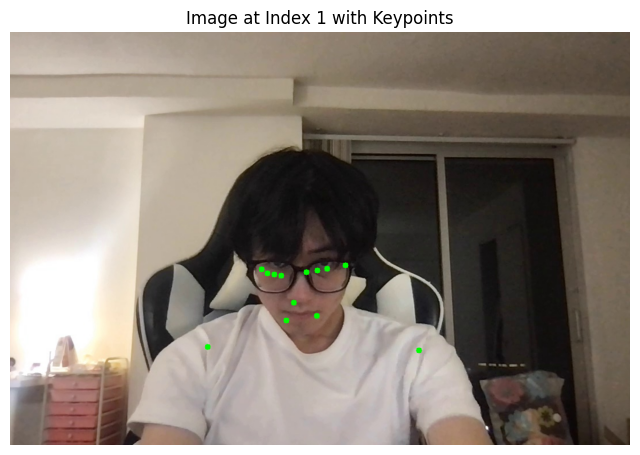

In [84]:
draw_keypoints_on_image(images, results_backwards[-7:], 1)  # Replace '1' with the desired index

In [4]:
# Usage in main code:
save_path = os.path.join(keypoints_path, "backward_keypoints")
save_keypoints(results_backwards, save_path)

Saved 5820 keypoints with shape (5820, 33, 3)


In [8]:
# Testing the function
data_path = "../../AI System Data/Normal posture/frames"
image_files = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
batch_size = 20
counter = 0
results_normal = []

# Initialize the model
initialize_model()

for i in range(len(image_files) // batch_size):
    # Load a batch of images
    images = [Image.open(os.path.join(data_path, image_file)) for image_file in image_files[counter:counter + batch_size]]
    
    # Perform posture detection on the batch
    batch_results = postureDetect(images)
    
    # Append batch results to the main results list
    results_normal.extend(batch_results)

    # Print keypoints results for the current batch
    # for idx, keypoints in enumerate(batch_results):
    #     print(f"Image {counter + idx}: Keypoints - {keypoints}")
    
    counter += batch_size

# Process remaining images
images = [Image.open(os.path.join(data_path, image_file)) for image_file in image_files[counter:]]
if images:
    batch_results = postureDetect(images)
    results_normal.extend(batch_results)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-51836b740846>", line 16, in <module>
    batch_results = postureDetect(images)
  File "<ipython-input-3-d0f756cf66fc>", line 91, in postureDetect
    results = inference(images)
  File "<ipython-input-3-d0f756cf66fc>", line 42, in inference
    image_np = np.array(image)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/PIL/Image.py", line 673, in __array_interface__
    new["data"] = self.tobytes()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/PIL/Image.py", line 732, in tobytes
    self.load()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/PIL/ImageFile.py", line 269, in load
    n, err_code = decoder.decode(b)
Keyboa

TypeError: object of type 'NoneType' has no len()

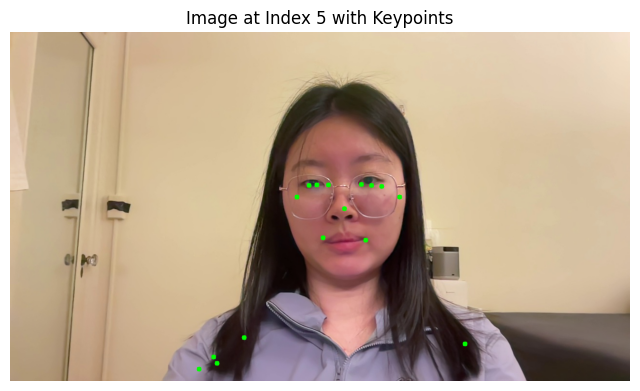

In [92]:
draw_keypoints_on_image(images, results_normal[-6:], 5)  # Replace '1' with the desired index

In [7]:
# keypoints_path = "/Users/idrissunmola/Library/CloudStorage/OneDrive-JohnsHopkins/AI System Data/keypoints/"
# Usage in main code
save_path = os.path.join(keypoints_path, "normal_keypoints")
save_keypoints(results_normal, save_path)

Saved 7426 keypoints with shape (7426, 33, 3)


In [ ]:

# testing
# local storage path
data_path = "../../AI System Data/Backwards/frames/"
# Get all files in the data_path folder
image_files = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]

batch_size = 20
counter = 0

for i in tqdm(np.arange(1000)):    
    
    images = [Image.open(os.path.join(data_path, image_files[i]))]

    if i == 0:
        results_backwards = postureDetect(images)

    else:
        results_backwards = np.concatenate((results_backwards, postureDetect(images)), axis = 0)

  # assert len(results) == len(images)

# Print keypoints results
for idx, keypoints in enumerate(results):
    print(f"Image {idx}: Keypoints - {keypoints}")
counter += batch_size

# assert len(results) == len(images)

# Print keypoints results
for idx, keypoints in enumerate(results):
    print(f"Image {idx}: Keypoints - {keypoints}")

In [17]:
np.save('results_forwards.npy',results_forward)

In [ ]:
results_backward = np.load('../../AI System Data/results_backwards.npy')
results_normal = np.load('../../AI System Data/results_normal.npy')

In [ ]:
results_forward = results_forward[:,:7, :]
results_backward =  results_backward[:,:7, :]
results_normal =  results_normal[:,:7, :]

In [67]:
for i in range(len(results_forward)):
    results_forward[i,:,1] = results_forward[i,:, 1] - results_forward[i,0, 1]
    results_forward[i,:,0] = results_forward[i,:, 0] - results_forward[i,0, 0]
    results_backward[i,:,1] = results_backward[i,:, 1] - results_backward[i,0, 1]
    results_backward[i,:,0] = results_backward[i,:, 0] - results_backward[i,0, 0]
    results_normal[i,:,1] = results_normal[i,:, 1] - results_normal[i,0, 1]
    results_normal[i,:,0] = results_normal[i,:, 0] - results_normal[i,0, 0]

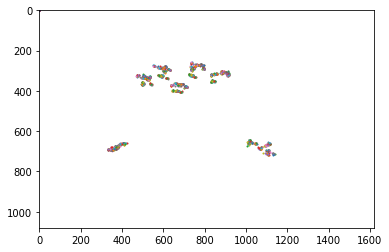

In [40]:
for i in range(1000):
    if int(image_files[i][-8:-4])<1269:
        plt.scatter(results_forward[i, :, 0],results_forward[i, :, 1], s = 1)
plt.xlim(0,1620)
plt.ylim(1080,0)
plt.show()

In [94]:
data_path = "../../AI System Data/Backwards/frames/"
# Get all files in the data_path folder
image_files = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
arr = []
for i in range(1000):
     if int(image_files[i][-8:-4])<1265:
            arr.append(i)

In [95]:
arr

[3,
 6,
 13,
 18,
 24,
 25,
 26,
 33,
 38,
 39,
 40,
 64,
 69,
 77,
 78,
 83,
 90,
 91,
 98,
 102,
 103,
 105,
 113,
 114,
 117,
 122,
 123,
 132,
 137,
 139,
 140,
 147,
 153,
 160,
 163,
 167,
 174,
 175,
 176,
 182,
 217,
 218,
 226,
 228,
 229,
 232,
 239,
 247,
 251,
 254,
 255,
 262,
 268,
 269,
 276,
 277,
 280,
 286,
 287,
 288,
 295,
 297,
 302,
 310,
 315,
 316,
 323,
 324,
 337,
 352,
 353,
 360,
 364,
 365,
 367,
 375,
 376,
 379,
 388,
 396,
 406,
 407,
 408,
 417,
 419,
 426,
 427,
 434,
 438,
 454,
 466,
 468,
 475,
 476,
 482,
 483,
 487,
 493,
 500,
 502,
 504,
 509,
 512,
 513,
 521,
 522,
 523,
 529,
 534,
 544,
 545,
 546,
 559,
 560,
 567,
 569,
 574,
 595,
 600,
 605,
 607,
 616,
 619,
 620,
 630,
 635,
 644,
 646,
 653,
 654,
 655,
 661,
 664,
 666,
 673,
 674,
 676,
 681,
 686,
 692,
 693,
 698,
 700,
 707,
 711,
 730,
 739,
 740,
 749,
 751,
 756,
 759,
 770,
 771,
 775,
 782,
 785,
 791,
 794,
 805,
 806,
 814,
 823,
 824,
 829,
 830,
 838,
 843,
 859,
 865,
 

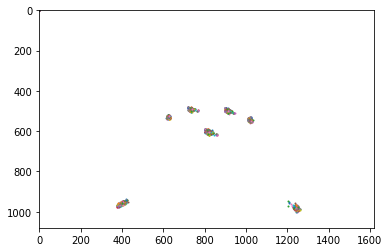

In [44]:
for i in range(1000):
    if 1269<=int(image_files[i][-8:-4])<3029:
        plt.scatter(results_forward[i, :, 0],results_forward[i, :, 1], s = 1)
plt.xlim(0,1620)
plt.ylim(1080, 0)
plt.show()

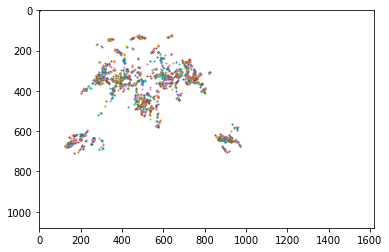

In [42]:
for i in range(1000):
    if 3029<=int(image_files[i][-8:-4])<5007:
        plt.scatter(results_forward[i, :, 0],results_forward[i, :, 1], s = 1)
plt.xlim(0,1620)
plt.ylim(1080, 0)
plt.show()

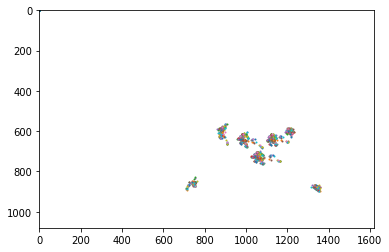

In [45]:
for i in range(1000):
    if int(image_files[i][-8:-4])>=5007:
        plt.scatter(results_forward[i, :, 0],results_forward[i, :, 1], s = 1)
plt.xlim(0,1620)
plt.ylim(1080, 0)
plt.show()

In [ ]:
for i in range(1000):
    if int(image_files[i][-8:-4])<1269:
        plt.scatter(results_forward[i, :, 0],results_forward[i, :, 1], s = 1)
plt.xlim(0,1620)
plt.ylim(1080, 0)
plt.show()

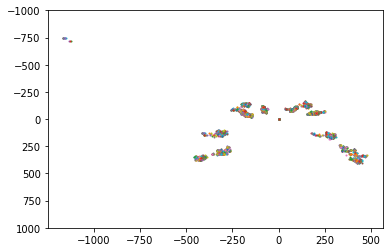

In [86]:
for i in range(1000):
#     if int(image_files[i][-8:-4])<1269:
    if not 3029<=int(image_files[i][-8:-4])<5007:
        plt.scatter(results_forward[i, :, 0],results_forward[i, :, 1], s = 1)
# plt.xlim(0,1620)
plt.ylim(1000, -1000)
plt.show()

In [81]:
results_backward =  results_backward[:,:7, :]
results_normal =  results_normal[:,:7, :]

In [82]:
for i in range(len(results_forward)):
    results_backward[i,:,1] = results_backward[i,:, 1] - results_backward[i,0, 1]
    results_backward[i,:,0] = results_backward[i,:, 0] - results_backward[i,0, 0]
    results_normal[i,:,1] = results_normal[i,:, 1] - results_normal[i,0, 1]
    results_normal[i,:,0] = results_normal[i,:, 0] - results_normal[i,0, 0]

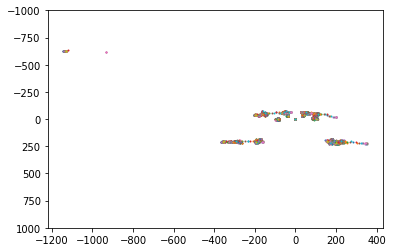

In [83]:
for i in range(1000):
#     if int(image_files[i][-8:-4])<1269:
    plt.scatter(results_backward[i, :, 0],results_backward[i, :, 1], s = 1)
# plt.xlim(0,1620)
plt.ylim(1000, -1000)
plt.show()

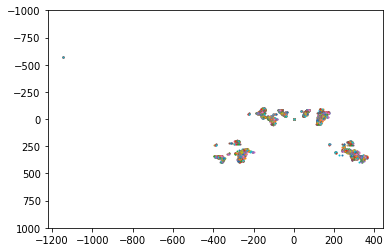

In [84]:
for i in range(1000):
#     if int(image_files[i][-8:-4])<1269:
    plt.scatter(results_normal[i, :, 0],results_normal[i, :, 1], s = 1)
# plt.xlim(0,1620)
plt.ylim(1000, -1000)
plt.show()

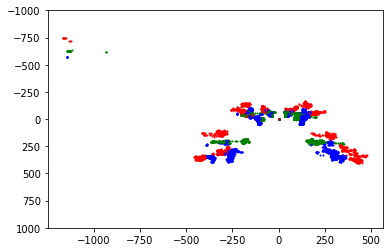

In [87]:
for i in range(1000):
#     if int(image_files[i][-8:-4])<1269:
    plt.scatter(results_normal[i, :, 0],results_normal[i, :, 1], s = 1, color = 'blue')
    plt.scatter(results_backward[i, :, 0],results_backward[i, :, 1], s = 1, color = 'green')
    if not 3029<=int(image_files[i][-8:-4])<5007:
        plt.scatter(results_forward[i, :, 0],results_forward[i, :, 1], s = 1, color = 'red')
        
# plt.xlim(0,1620)
plt.ylim(1000, -1000)
plt.show()

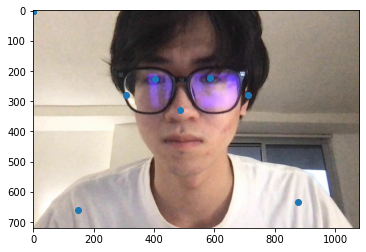

In [32]:
plt.imshow(images[1])
plt.scatter(results[1,:,0], results[1, :, 1])

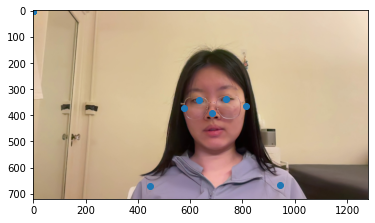

In [20]:
plt.imshow(images[0])
plt.scatter(results[0,:,0], results[0, :, 1])

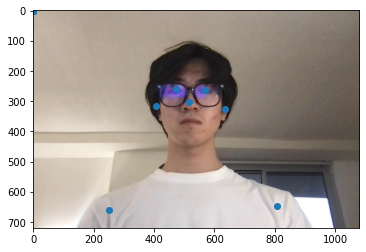

In [21]:
plt.imshow(images[1])
plt.scatter(results[1,:,0], results[1, :, 1])